In [1]:
!unzip /content/cnndata.zip -d /content/


Archive:  /content/cnndata.zip
   creating: /content/cnndata/
   creating: /content/cnndata/images/
  inflating: /content/cnndata/images/70_crop_pyttext_$0.00_easyOCR_text_30_.00_ts_20250819_2255.jpg  
  inflating: /content/cnndata/images/70_crop_pyttext_$0.00_easyOCR_text_S0,00_ts_20250820_2024.jpg  
  inflating: /content/cnndata/images/70_crop_pyttext_$0.00_easyOCR_text_S0_,00_ts_20250820_2024.jpg  
  inflating: /content/cnndata/images/70_crop_pyttext_$0.00_easyOCR_text_S0_,_00_ts_20250820_2024.jpg  
  inflating: /content/cnndata/images/70_crop_pyttext_$0.00_easyOCR_text_S0_._00_ts_20250820_2024.jpg  
  inflating: /content/cnndata/images/70_crop_pyttext_$1.97_J_easyOCR_text_0_ts_20250821_0040.jpg  
  inflating: /content/cnndata/images/70_crop_pyttext_$1.97_J_easyOCR_text_3T.97_J_ts_20250821_0040.jpg  
  inflating: /content/cnndata/images/70_crop_pyttext_$1.97_J_easyOCR_text_931,_97_J_ts_20250821_0040.jpg  
  inflating: /content/cnndata/images/70_crop_pyttext_$1.97_J_easyOCR_text_J_ts

In [2]:
# Install OpenCV
!pip install opencv-python

# NumPy and TensorFlow are usually pre-installed, but you can upgrade if needed
!pip install numpy tensorflow


In [3]:
import os,json
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -------------------
# Config
# -------------------
img_height = 31
num_channels = 1
vocab = "0123456789.,-}{ABCDEFGHIJKLMNOPQRSTUVWXYZ$;pco~ " # Added space to vocab
num_classes = len(vocab) + 2  # last index for CTC blank
max_label_len = 9           # 13max length of text in dataset
batch_size = 16

# -------------------
# Vocabulary mapping
# -------------------
char_to_idx = {c:i+1 for i,c in enumerate(vocab)}  # 0 reserved for blank
idx_to_char = {i+1:c for i,c in enumerate(vocab)}

def text_to_labels(text):
    return [char_to_idx[c] for c in text]

# -------------------
# Load data
# -------------------
data_path = "/content/cnndata/images"
label_file = "/content/cnndata/labels.json"

# Load JSON
with open(label_file, "r", encoding="utf-8") as f:
    labels = json.load(f)

image_paths = []
label_sequences = []
texts = []
for item in labels:
    fname = item["filename"]
    text = item["annotation"]
    texts.append(text)

    image_paths.append(os.path.join(data_path, fname))
    label_sequences.append(list(text_to_labels(text)))

print('label_sequences',label_sequences)
print('texts',texts)

# -------------------
# Data generator
# -------------------
def data_generator(batch_size, img_height, downsample_factor=4): # Removed max_label_len=32 from here
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = label_sequences[i:i+batch_size]

            images = []
            labels = []
            label_lengths = []
            input_lengths = []

            # --- preprocess each image ---
            processed = []
            for img_path, lbl in zip(batch_paths, batch_labels):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                  print(f"[WARN] Could not read image: {img_path}")
                  continue

                # keep aspect ratio, resize height
                ratio = img_height / img.shape[0]
                new_w = int(img.shape[1] * ratio)
                resized = cv2.resize(img, (new_w, img_height))

                resized = resized.astype(np.float32) / 255.0
                resized = np.expand_dims(resized, axis=-1)  # add channel

                processed.append(resized)
                labels.append(lbl)
                label_lengths.append(len(lbl))

            # --- pad images in this batch ---
            max_w = max(img.shape[1] for img in processed)
            padded_imgs = np.ones((len(processed), img_height, max_w, 1), dtype=np.float32)  # white padding
            for j, img in enumerate(processed):
                padded_imgs[j, :, :img.shape[1], :] = img

            # --- pad labels ---
            Y_padded = np.zeros((len(labels), max_label_len), dtype=np.int32)
            for j, lbl in enumerate(labels):
              # truncate if longer than 13
              trunc = lbl[:max_label_len]
              Y_padded[j, :len(trunc)] = trunc
            # for j, lbl in enumerate(labels):
            #     Y_padded[j, :len(lbl)] = lbl


            # --- compute input lengths after CNN downsampling ---
            input_lengths = np.array([[img.shape[1] // downsample_factor] for img in processed])
            label_lengths = np.array(label_lengths).reshape(-1, 1)

            yield {
                "input": padded_imgs,
                "label": Y_padded,
                "input_length": input_lengths,
                "label_length": label_lengths
            }, np.zeros(len(processed))



# -------------------
# Build CRNN
# -------------------
inputs = layers.Input(shape=(img_height,None,num_channels), name="input")

x = layers.Conv2D(64, 5, padding="same", activation="relu")(inputs)
# x = layers.Conv2D(64, 5, padding="same", activation="relu")(x) #new
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, 5, padding="same", activation="relu")(x)
# x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)  # Added
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
# x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)  # Added
x = layers.BatchNormalization()(x)

x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,1))(x)

x = layers.Conv2D(512, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
# x = layers.Conv2D(512, 3, padding="same", activation="relu")(x)  # Added
x = layers.MaxPooling2D((2,1))(x)

# Dropout before RNN
x = layers.Dropout(0.25)(x)

# Reshape for RNN
new_shape = (-1, x.shape[1]*x.shape[3])
x = layers.Reshape(target_shape=new_shape)(x)

# RNN layers
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)


outputs = layers.Dense(num_classes, activation="softmax")(x)

base_model = models.Model(inputs, outputs, name="CRNN")

# -------------------
# CTC Loss
# -------------------
labels = layers.Input(name="label", shape=(max_label_len,), dtype="int32")
input_length = layers.Input(name="input_length", shape=(1,), dtype="int32")
label_length = layers.Input(name="label_length", shape=(1,), dtype="int32")

def ctc_lambda(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = layers.Lambda(ctc_lambda, output_shape=(1,), name="ctc")(
    [outputs, labels, input_length, label_length]
)

training_model = models.Model(
    inputs=[inputs, labels, input_length, label_length],
    outputs=loss_out
)

# Set your learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

training_model.compile(optimizer="adam", loss={"ctc": lambda y_true, y_pred: y_pred})

# -------------------
# Training
# -------------------
# steps_per_epoch = len(image_paths) // batch_size
# training_model.fit(
#     data_generator(batch_size),
#     steps_per_epoch=steps_per_epoch,
#     epochs=100
# )

# Define early stopping
early_stop = EarlyStopping(
    monitor="loss",        # or "val_loss" if you have validation data
    patience=5,            # stop if no improvement for 5 epochs
    restore_best_weights=True # roll back to the best model
)

steps_per_epoch = len(image_paths) // batch_size

training_model.fit(
    data_generator(batch_size,img_height),
    steps_per_epoch=steps_per_epoch,
    epochs=60,
    callbacks=[early_stop]
)

label_sequences [[42, 1, 11, 1, 1], [42, 1, 11, 1, 1], [42, 1, 11, 1, 1], [42, 1, 11, 1, 1], [42, 1, 11, 1, 1], [42, 2, 11, 10, 8], [42, 2, 11, 10, 8], [42, 2, 11, 10, 8], [42, 2, 11, 10, 8], [42, 2, 1, 11, 10, 5], [42, 2, 1, 11, 10, 5], [42, 2, 1, 11, 10, 5], [42, 2, 1, 11, 10, 5], [42, 2, 1, 11, 10, 5], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 2, 11, 4, 9], [42, 2, 3, 11, 1, 9], [42, 2, 3, 11, 1, 9], [42, 2, 3, 11, 1, 9], [42, 2, 3, 11, 1, 9], [42, 2, 3, 11, 1, 9], [42, 2, 3, 11, 1, 9], [42, 2, 4, 11, 1, 6], [42, 2, 4, 11, 1, 6], [42, 2, 4, 11, 1, 6], [42, 2, 4, 11, 1, 6], [42, 3, 11, 10, 8], [42, 3, 11, 10, 8], [42, 4, 11, 5, 1], [42, 4, 11, 5, 1],

In [4]:
import json

label_file = "/content/cnndata/labels.json"

with open(label_file, "r", encoding="utf-8") as f:
    labels_data = json.load(f)

max_annotation_length = 0
for item in labels_data:
    annotation_length = len(item["annotation"])
    if annotation_length > max_annotation_length:
        max_annotation_length = annotation_length

print(f"Maximum annotation length found: {max_annotation_length}")

Maximum annotation length found: 8


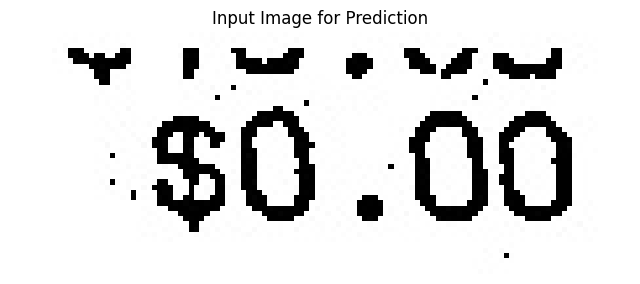

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
Decoded: ['8', '0', '.', '0']
Decoded: ['8', '0', '.', '0', '0']


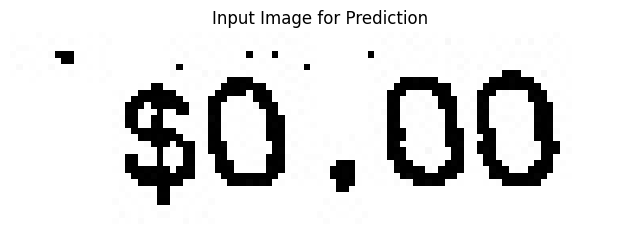

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Decoded: ['$', '0', '.', '0']
Decoded: ['$', '0', '.', '0', '0']


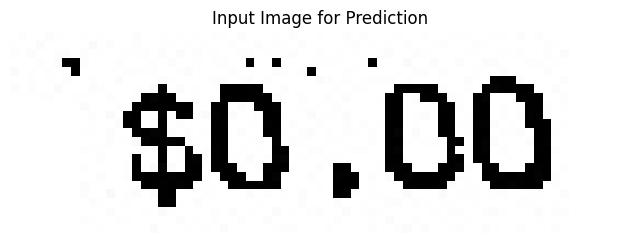

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Decoded: ['$', '0', '.', '0']
Decoded: ['$', '0', '.', '0', '0']


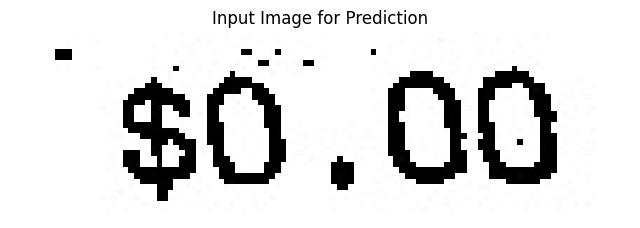

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Decoded: ['$', '0', '.', '0']
Decoded: ['$', '0', '.', '0', '0']


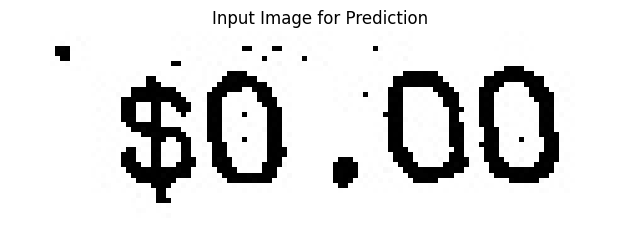

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Decoded: ['$', '0', '.', '0']
Decoded: ['$', '0', '.', '0', '0']


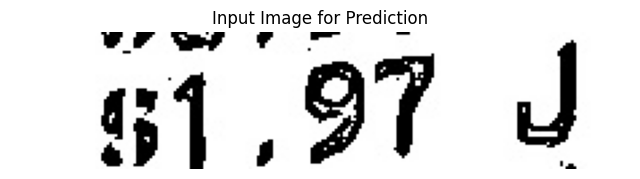

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
Decoded: ['$', '1', '.', '9', '7']
Decoded: ['$', '1', '.', '9', '7']


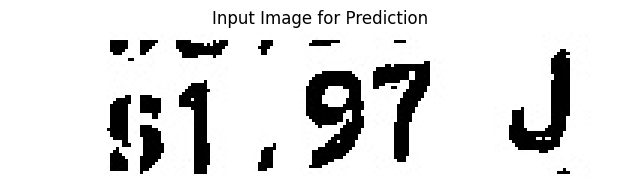

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
Decoded: ['$', '1', '.', '9', '7']
Decoded: ['$', '1', '.', '9', '7']


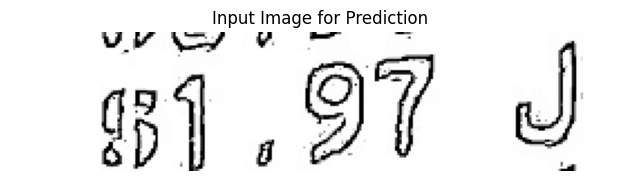

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Decoded: ['$', '1', '.', '9', '7']
Decoded: ['$', '1', '.', '9', '7']


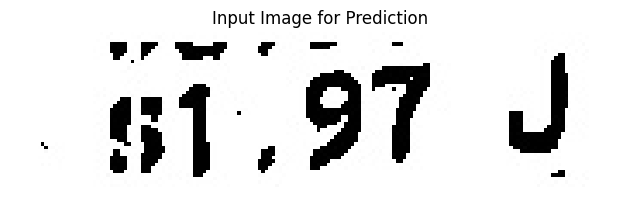

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Decoded: ['$', '1', '.', '9', '7']
Decoded: ['$', '1', '.', '9', '7']


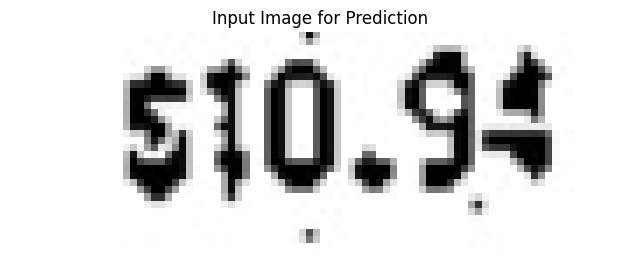

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Decoded: ['$', '1', '0', '.', '9', '4']
Decoded: ['$', '1', '0', '.', '9', '4']


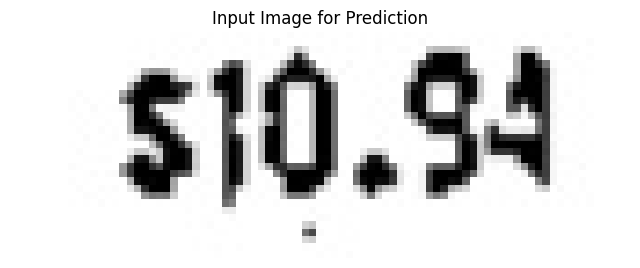

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Decoded: ['$', '1', '0', '.', '9', '4']
Decoded: ['$', '1', '0', '.', '9', '4']


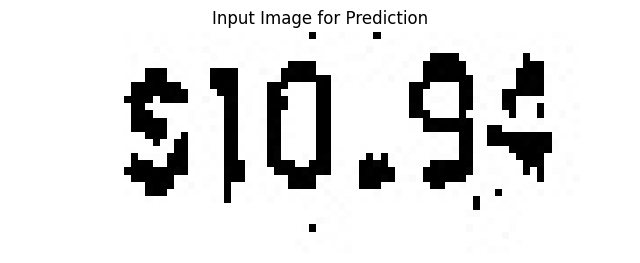

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


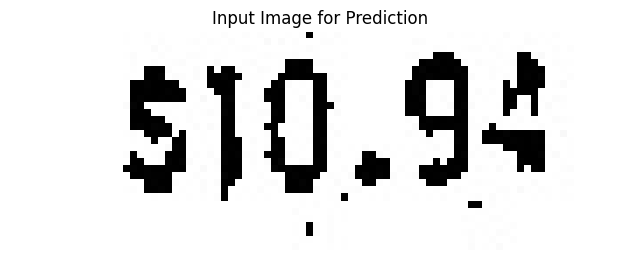

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['$', '1', '0', '.', '9', '4']
Decoded: ['$', '1', '0', '.', '9', '4']


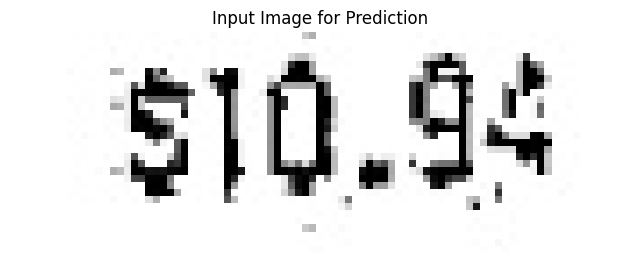

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


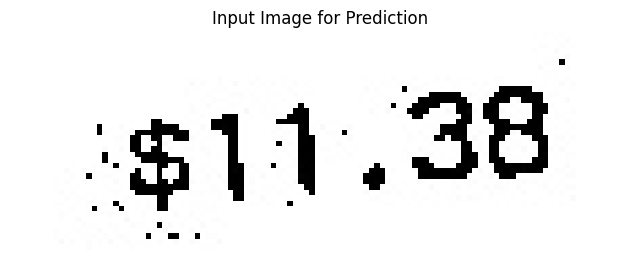

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['$', '1', '.', '3', '8']
Decoded: ['$', '1', '1', '.', '3', '8']


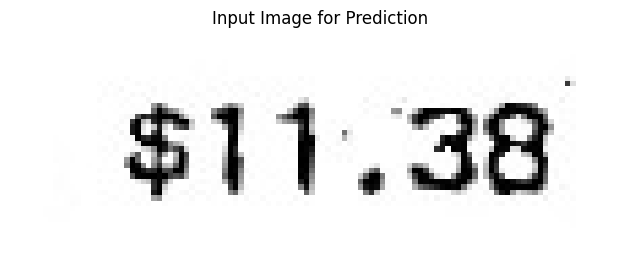

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


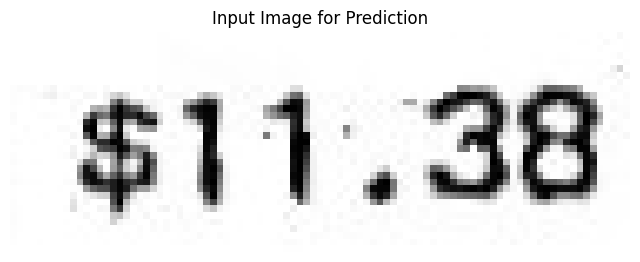

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['$', '1', '.', '3', '8']
Decoded: ['$', '1', '1', '.', '3', '8']


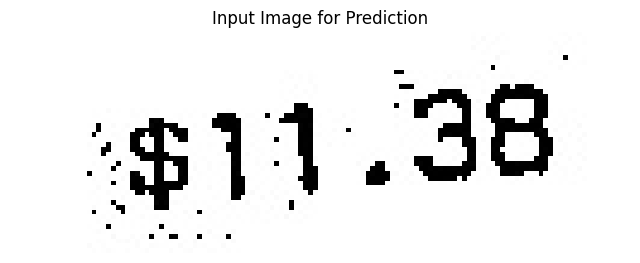

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['$', '1', '.', '3', '8']
Decoded: ['$', '1', '1', '.', '3', '8']


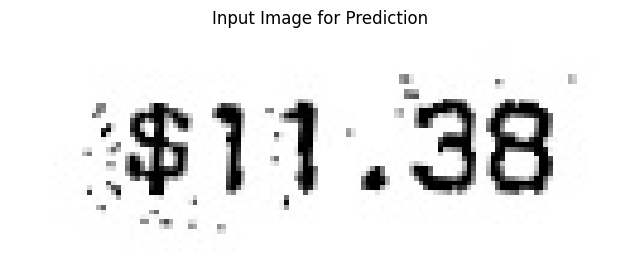

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['$', '7', '.', '3', '8']
Decoded: ['$', '7', '7', '.', '3', '8']


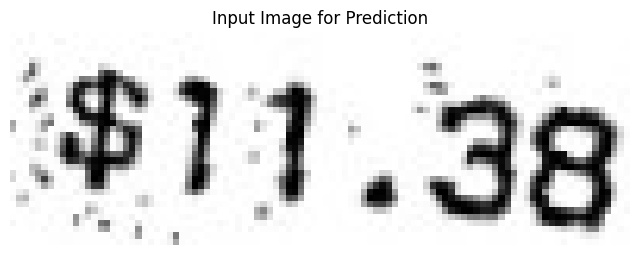

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Decoded: ['$', '1', '.', '3', '8']
Decoded: ['$', '1', '1', '.', '3', '8']


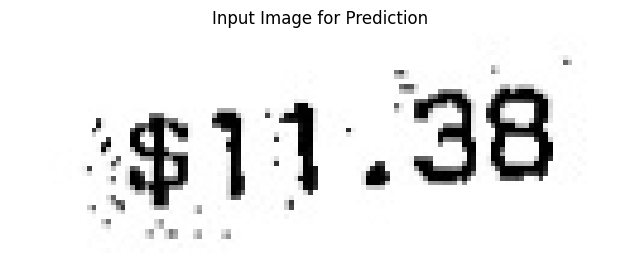

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['$', '1', '.', '3', '8']
Decoded: ['$', '1', '1', '.', '3', '8']


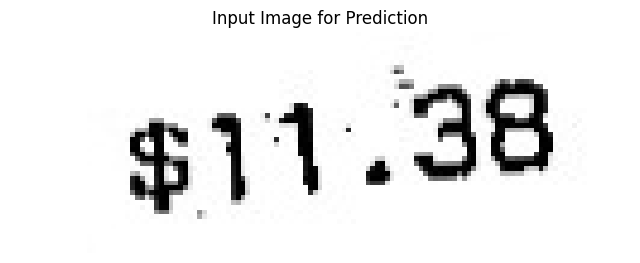

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['$', '7', '1', '.', '3', '8']
Decoded: ['$', '7', '1', '.', '3', '8']


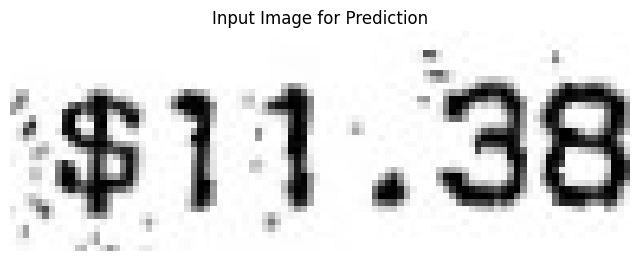

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['$', '1', '.', '3', '8']
Decoded: ['$', '1', '1', '.', '3', '8']


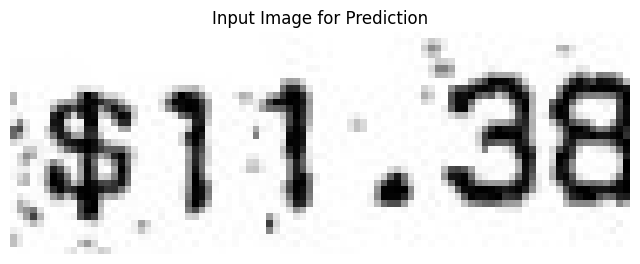

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Decoded: ['$', '1', '.', '3', '8']
Decoded: ['$', '1', '1', '.', '3', '8']


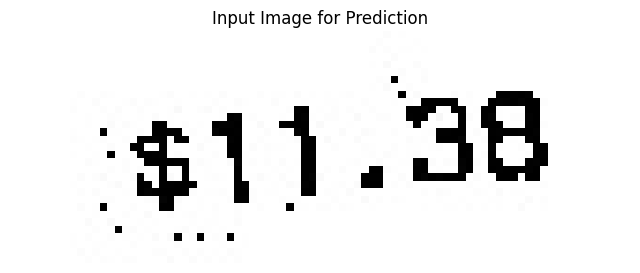

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Decoded: ['$', '7', '1', '.', '3', '8']
Decoded: ['$', '7', '1', '.', '3', '8']


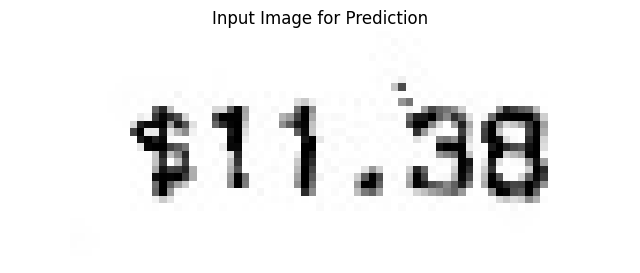

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


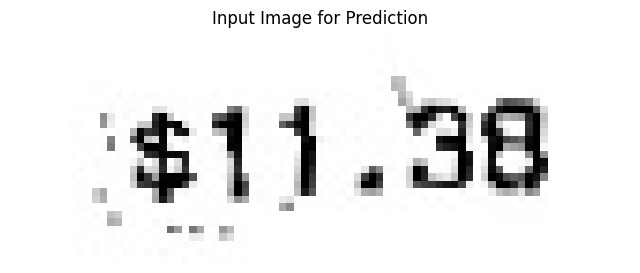

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['$', '7', '1', '.', '3', '9']
Decoded: ['$', '7', '1', '.', '3', '9']


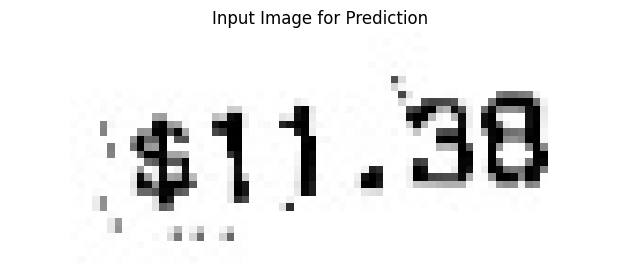

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Decoded: ['$', '7', '1', '.', '3', '8']
Decoded: ['$', '7', '1', '.', '3', '8']


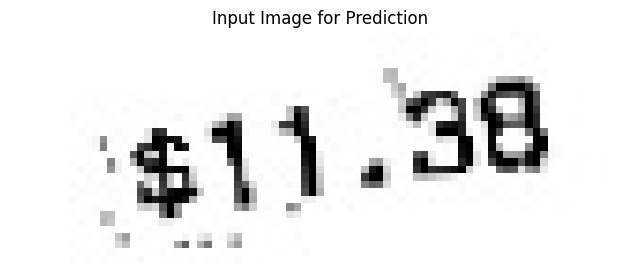

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['$', '7', '1', '.', '3', '8']
Decoded: ['$', '7', '1', '.', '3', '8']


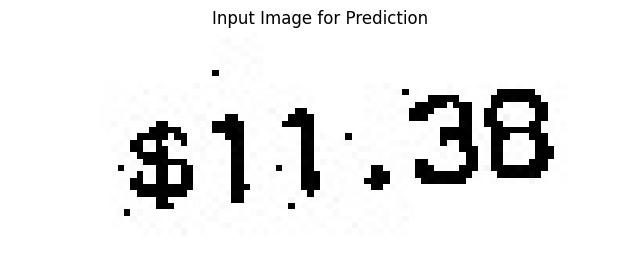

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Decoded: ['$', '1', '.', '3', '8']
Decoded: ['$', '1', '1', '.', '3', '8']


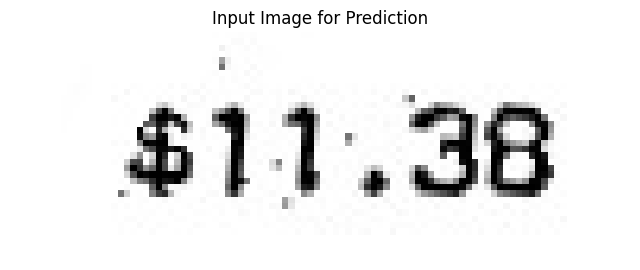

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '7', '.', '3', '9']
Decoded: ['$', '7', '7', '.', '3', '9']


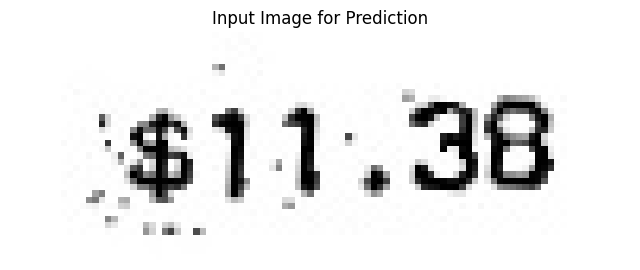

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '1', '.', '3', '8']
Decoded: ['$', '1', '1', '.', '3', '8']


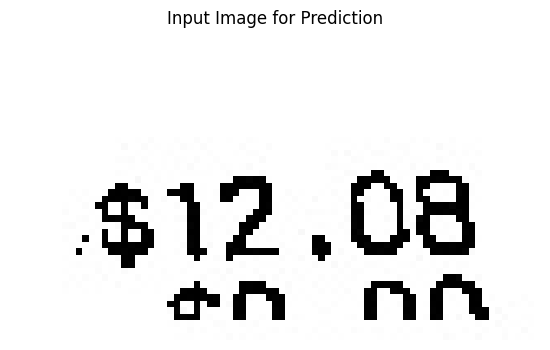

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0']


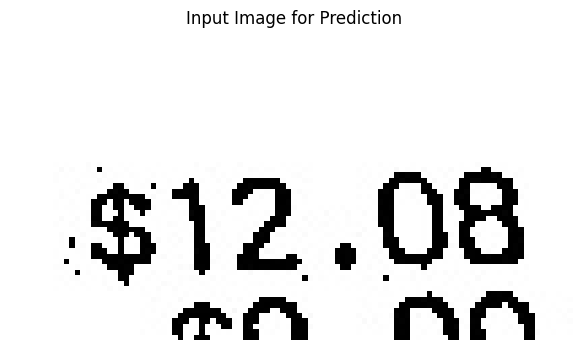

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Decoded: ['1', '.', '0', '8']
Decoded: ['1', '.', '0', '8']


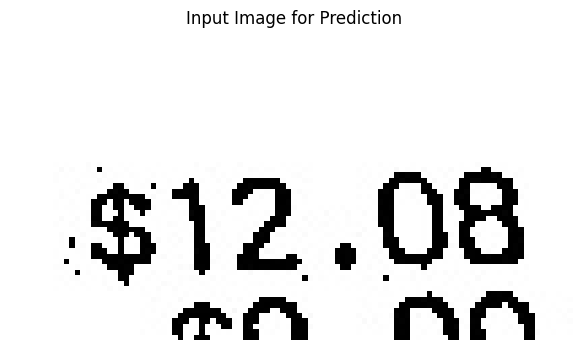

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['1', '.', '0', '8']
Decoded: ['1', '.', '0', '8']


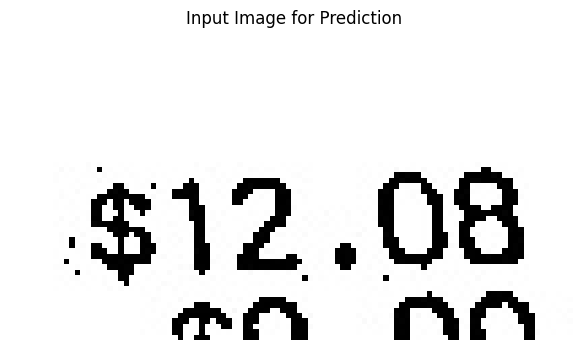

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '.', '0', '8']
Decoded: ['1', '.', '0', '8']


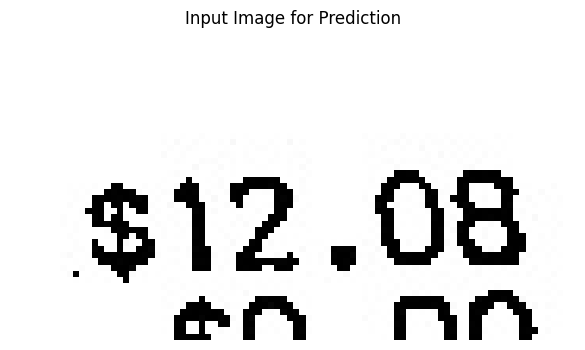

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0']


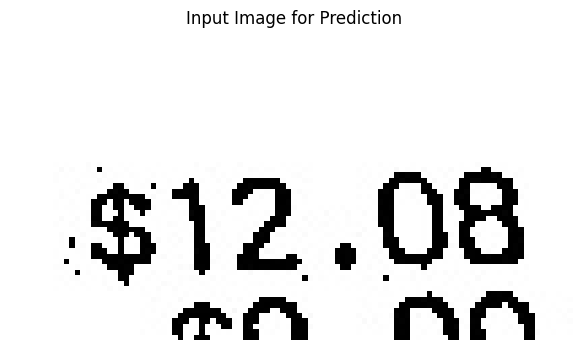

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '.', '0', '8']
Decoded: ['1', '.', '0', '8']


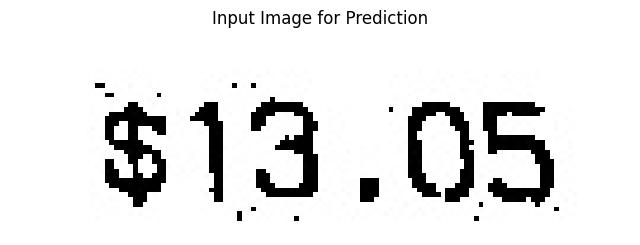

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Decoded: ['$', '1', '3', '.', '0', '8']
Decoded: ['$', '1', '3', '.', '0', '8']


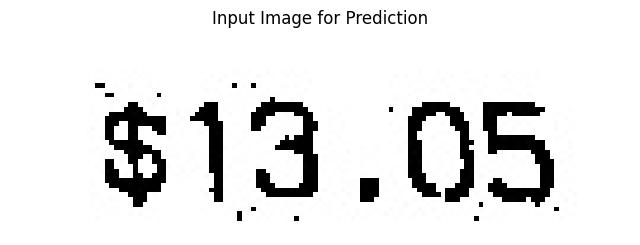

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '1', '3', '.', '0', '8']
Decoded: ['$', '1', '3', '.', '0', '8']


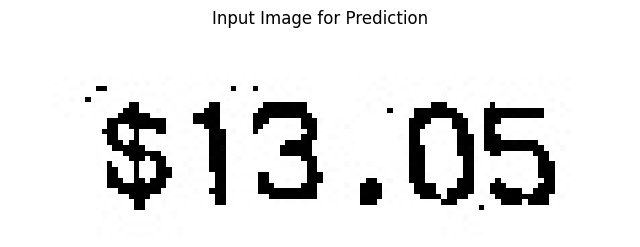

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Decoded: ['$', '1', '3', '.', '0', '5']
Decoded: ['$', '1', '3', '.', '0', '5']


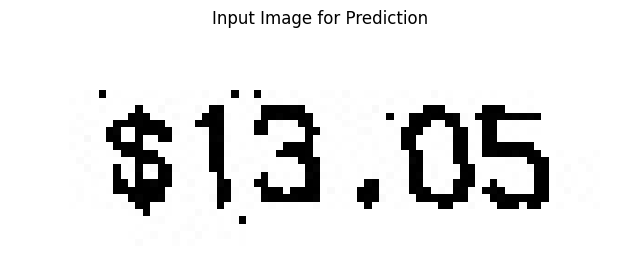

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Decoded: ['$', '1', '3', '.', '0', '5']
Decoded: ['$', '1', '3', '.', '0', '5']


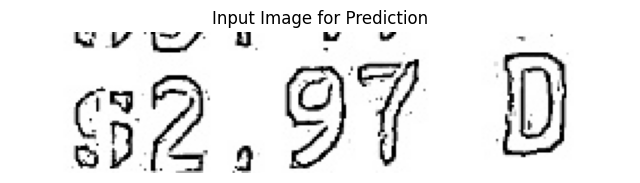

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Decoded: ['$', '1', '.', '9', '7']
Decoded: ['$', '1', '.', '9', '7']


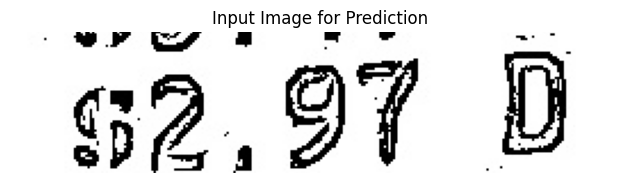

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['$', '2', '.', '9', '7']
Decoded: ['$', '2', '.', '9', '7']


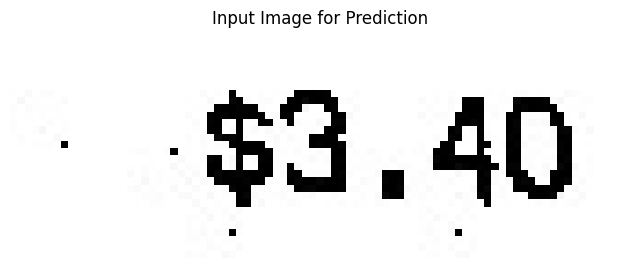

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '3', '.', '4', '0']
Decoded: ['$', '3', '.', '4', '0']


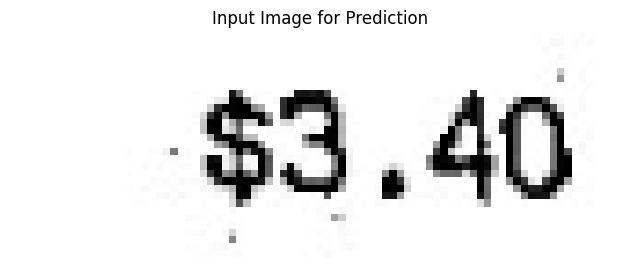

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['$', '3', '.', '4', '0']
Decoded: ['$', '3', '.', '4', '0']


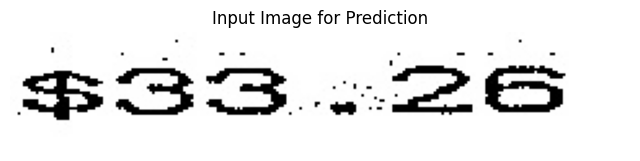

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Decoded: ['$', '3', '.', '2', '6']
Decoded: ['$', '3', '3', '.', '2', '6']


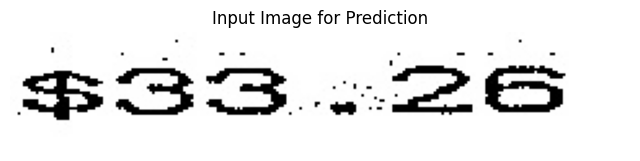

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['$', '3', '.', '2', '6']
Decoded: ['$', '3', '3', '.', '2', '6']


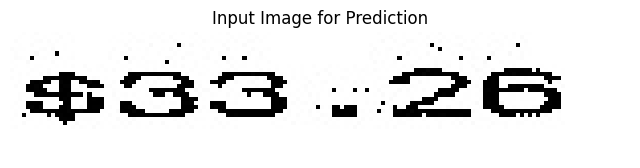

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Decoded: ['$', '3', '.', '2', '6']
Decoded: ['$', '3', '3', '.', '2', '6']


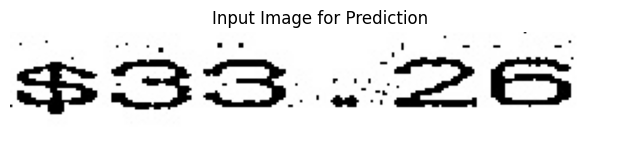

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Decoded: ['$', '3', '.', '2', '6']
Decoded: ['$', '3', '3', '.', '2', '6']


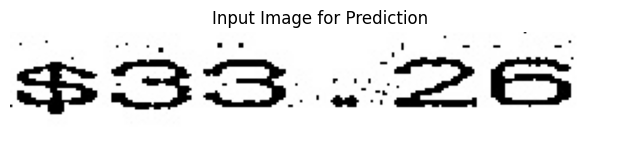

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['$', '3', '.', '2', '6']
Decoded: ['$', '3', '3', '.', '2', '6']


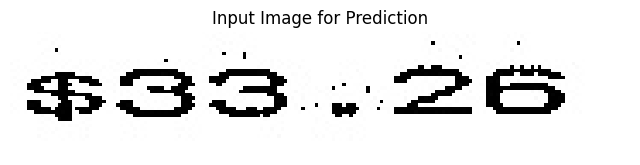

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Decoded: ['$', '3', '.', '2', '6']
Decoded: ['$', '3', '3', '.', '2', '6']


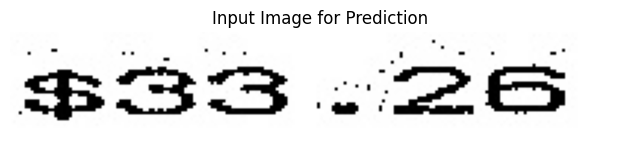

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Decoded: ['$', '3', '.', '2', '6']
Decoded: ['$', '3', '3', '.', '2', '6']


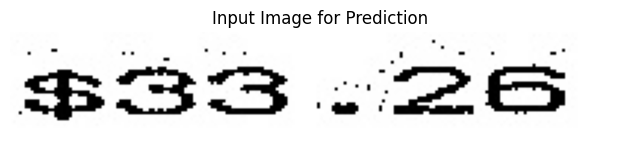

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['$', '3', '.', '2', '6']
Decoded: ['$', '3', '3', '.', '2', '6']


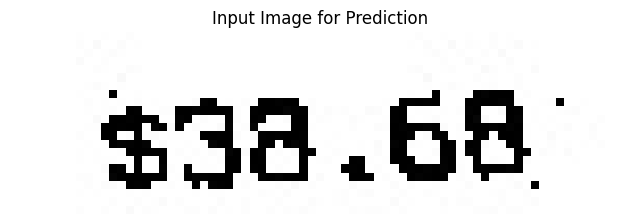

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Decoded: ['$', '3', '8', '.', '6', '8']
Decoded: ['$', '3', '8', '.', '6', '8']


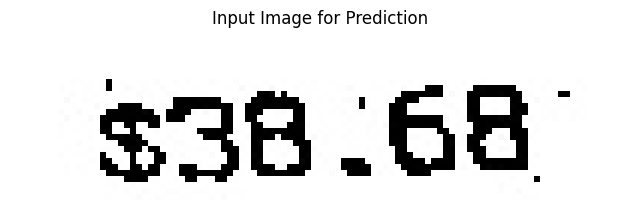

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Decoded: ['$', '3', '8', '.', '6', '8']
Decoded: ['$', '3', '8', '.', '6', '8']


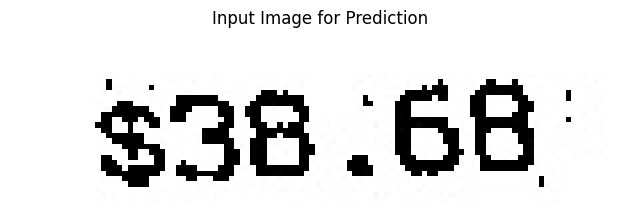

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Decoded: ['$', '3', '8', '.', '6', '8']
Decoded: ['$', '3', '8', '.', '6', '8']


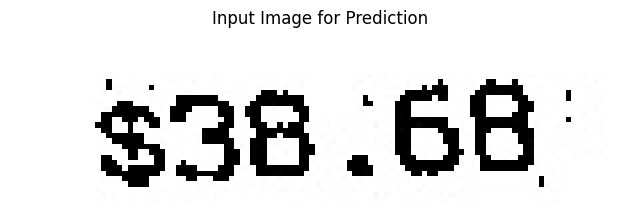

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Decoded: ['$', '3', '8', '.', '6', '8']
Decoded: ['$', '3', '8', '.', '6', '8']


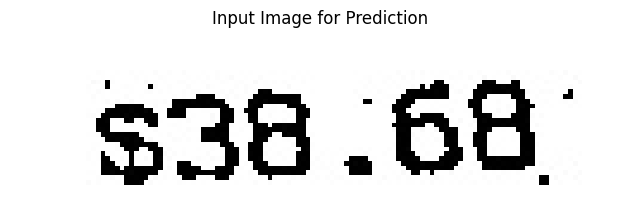

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['$', '3', '8', '.', '6', '8']
Decoded: ['$', '3', '8', '.', '6', '8']


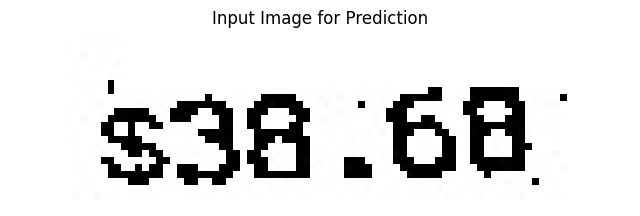

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Decoded: ['$', '3', '8', '.', '6', '8']
Decoded: ['$', '3', '8', '.', '6', '8']


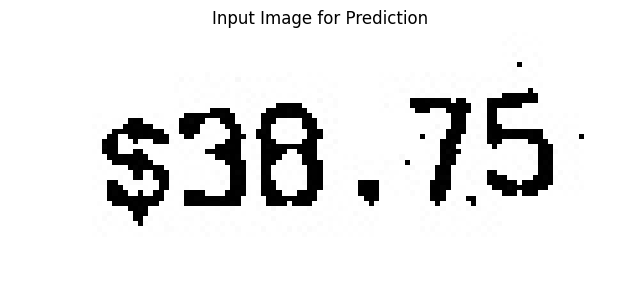

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Decoded: ['$', '3', '9', '.', '7', '9']
Decoded: ['$', '3', '9', '.', '7', '9']


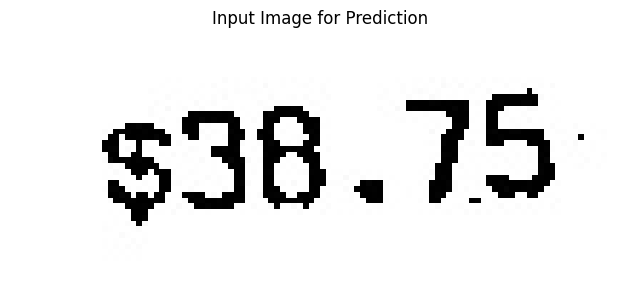

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['$', '3', '9', '.', '7', '9']
Decoded: ['$', '3', '9', '.', '7', '9']


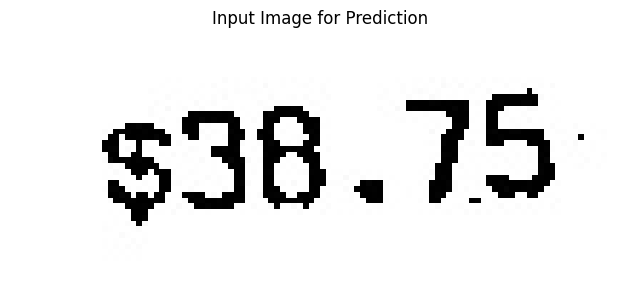

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['$', '3', '9', '.', '7', '9']
Decoded: ['$', '3', '9', '.', '7', '9']


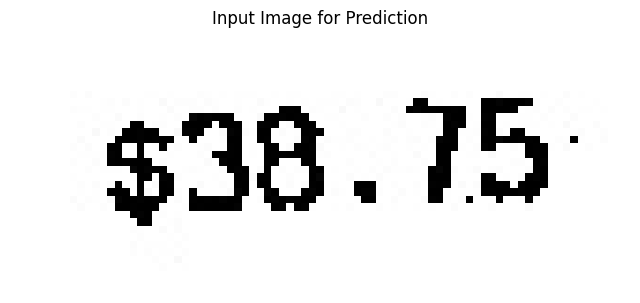

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Decoded: ['2', '3', '9', '.', '9']
Decoded: ['2', '3', '9', '.', '9', '9']


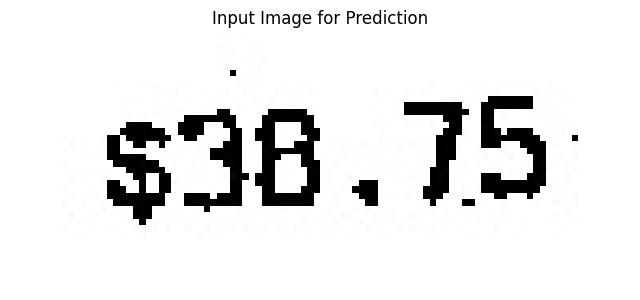

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Decoded: ['2', '9', '.', '9', '0']
Decoded: ['2', '9', '.', '9', '0']


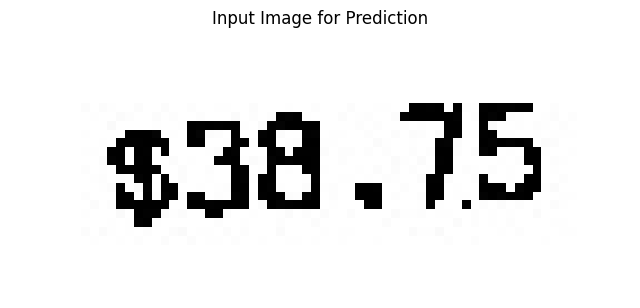

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Decoded: ['$', '3', '9', '.', '7', '0']
Decoded: ['$', '3', '9', '.', '7', '0']


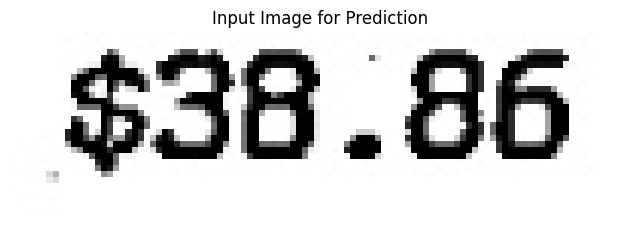

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['$', '3', '8', '.', '8', '6']
Decoded: ['$', '3', '8', '.', '8', '6']


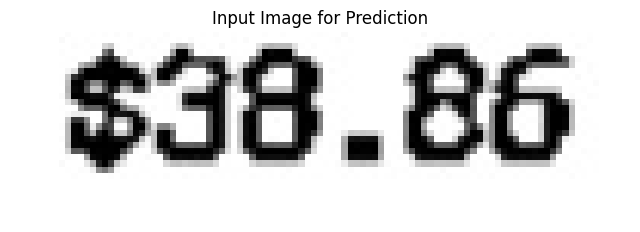

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['$', '3', '8', '.', '8', '6']
Decoded: ['$', '3', '8', '.', '8', '6']


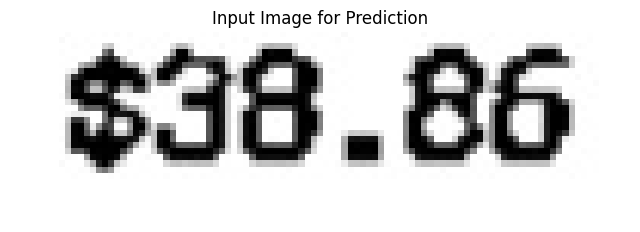

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['$', '3', '8', '.', '8', '6']
Decoded: ['$', '3', '8', '.', '8', '6']


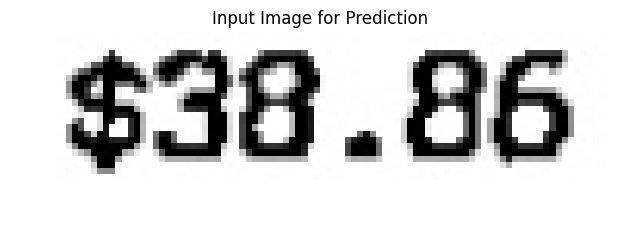

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['$', '3', '8', '.', '8', '6']
Decoded: ['$', '3', '8', '.', '8', '6']


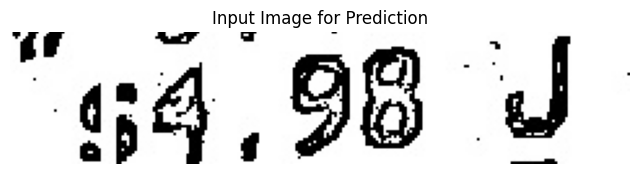

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Decoded: ['$', '4', '.', '9', '8']
Decoded: ['$', '4', '.', '9', '8']


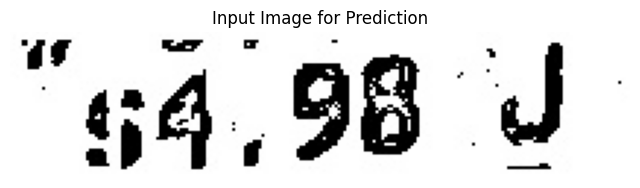

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Decoded: ['$', '4', '.', '9', '8']
Decoded: ['$', '4', '.', '9', '8']


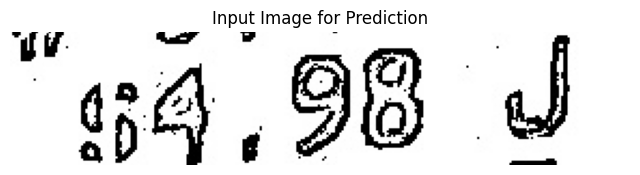

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['$', '4', '.', '9', '8']
Decoded: ['$', '4', '.', '9', '8']


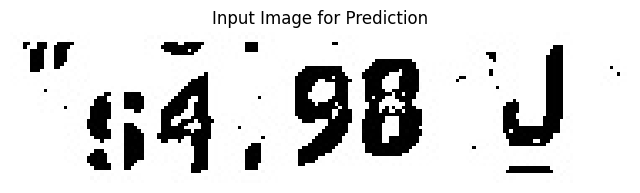

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['$', '4', '.', '9', '8']
Decoded: ['$', '4', '.', '9', '8']


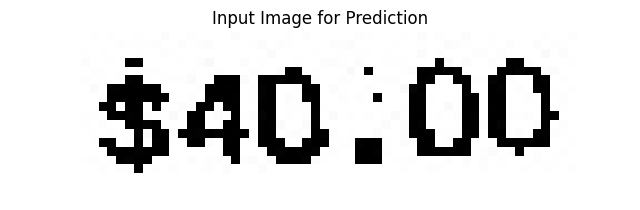

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '4', '0', '.', '0']
Decoded: ['$', '4', '0', '.', '0', '0']


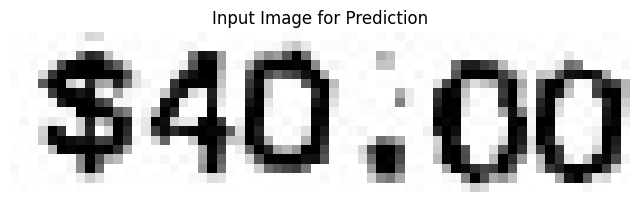

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Decoded: ['$', '4', '0', '.', '0']
Decoded: ['$', '4', '0', '.', '0', '0']


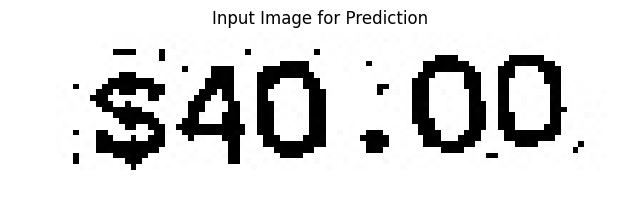

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['$', '4', '0', '.', '0']
Decoded: ['$', '4', '0', '.', '0', '0']


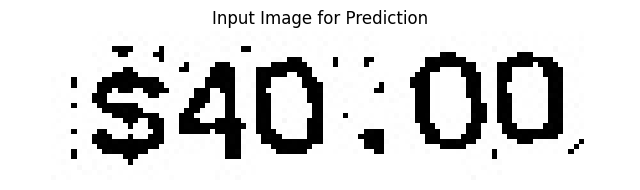

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Decoded: ['$', '4', '0', '.', '0']
Decoded: ['$', '4', '0', '.', '0', '0']


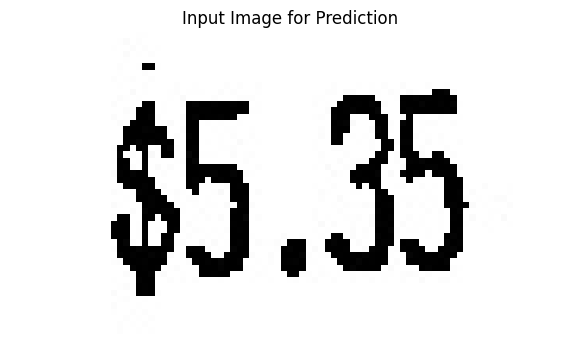

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['$', '7', '.', '0', '5']
Decoded: ['$', '7', '.', '0', '5']


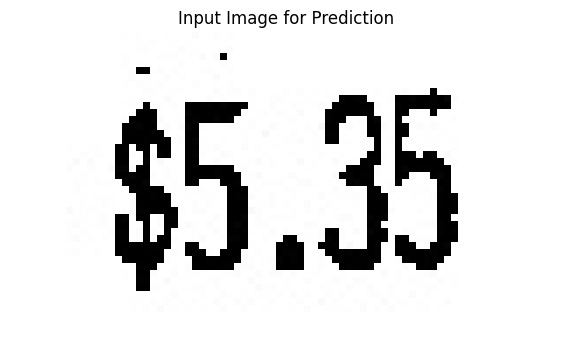

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Decoded: ['2', '.', '9']
Decoded: ['2', '.', '9', '9']


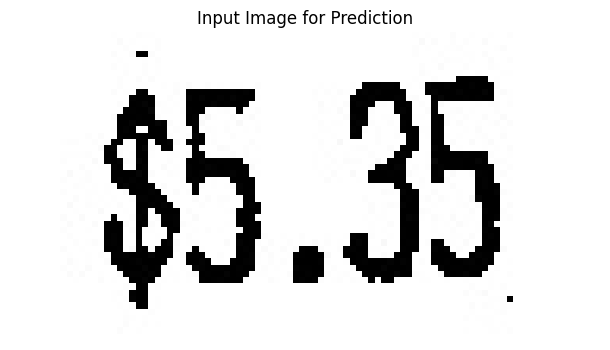

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Decoded: ['2', '5', '.', '0']
Decoded: ['2', '5', '.', '0', '0']


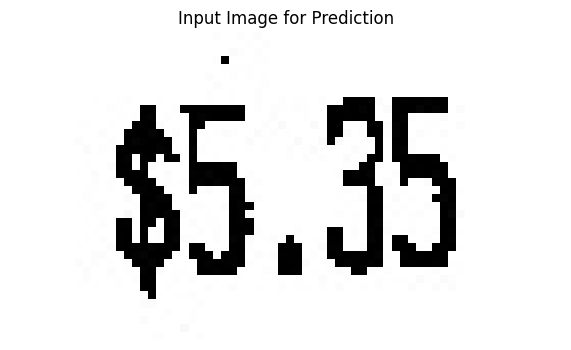

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['2', '.', '9']
Decoded: ['2', '.', '9', '9']


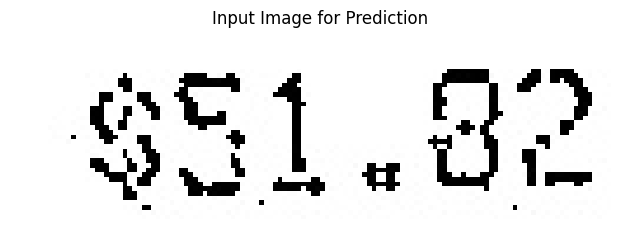

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Decoded: ['$', '5', '1', '.', '8', '2']
Decoded: ['$', '5', '1', '.', '8', '2']


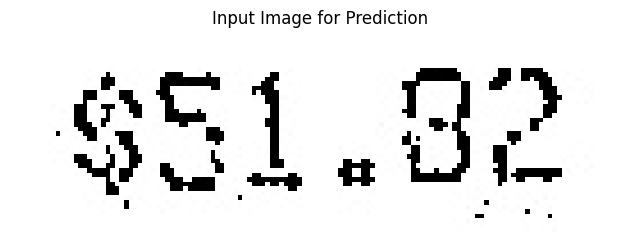

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '5', '1', '.', '8', '2']
Decoded: ['$', '5', '1', '.', '8', '2']


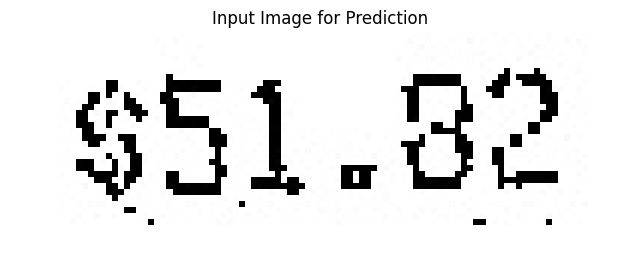

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Decoded: ['$', '5', '1', '.', '8', '2']
Decoded: ['$', '5', '1', '.', '8', '2']


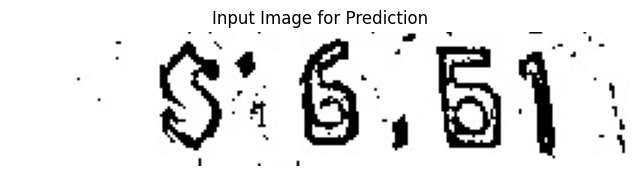

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Decoded: ['$', '6', '.', '5', '1']
Decoded: ['$', '6', '.', '5', '1']


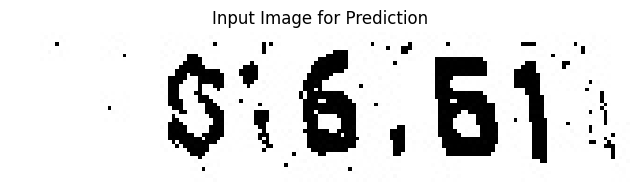

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['$', '6', '.', '5', '1']
Decoded: ['$', '6', '.', '5', '1']


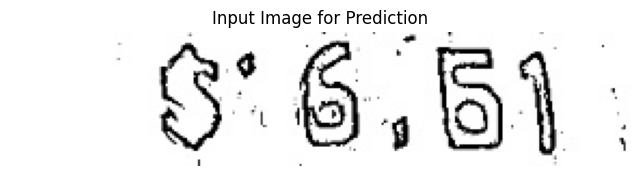

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['$', '6', '.', '5', '1']
Decoded: ['$', '6', '.', '5', '1']


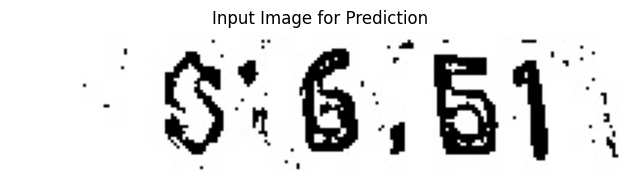

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['$', '6', '.', '5', '1']
Decoded: ['$', '6', '.', '5', '1']


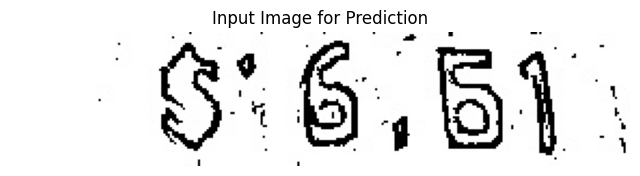

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['$', '6', '.', '5', '1']
Decoded: ['$', '6', '.', '5', '1']


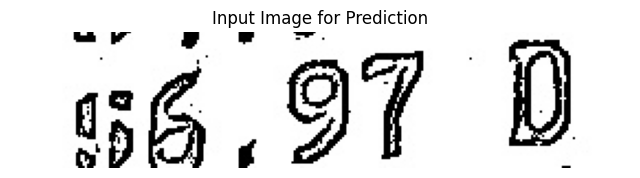

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Decoded: ['$', '6', '.', '9', '7']
Decoded: ['$', '6', '.', '9', '7']


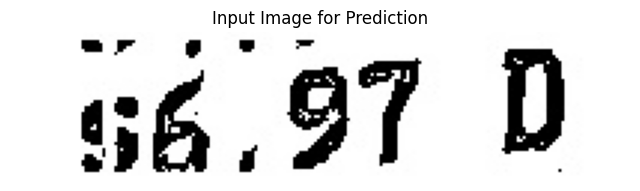

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Decoded: ['$', '6', '.', '9', '7']
Decoded: ['$', '6', '.', '9', '7']


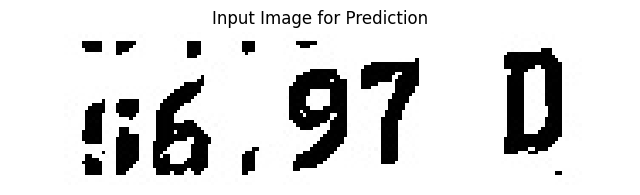

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Decoded: ['$', '6', '.', '9', '7']
Decoded: ['$', '6', '.', '9', '7']


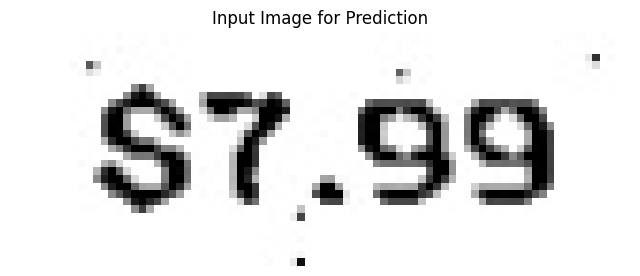

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['$', '7', '.', '0', '9']
Decoded: ['$', '7', '.', '0', '9']


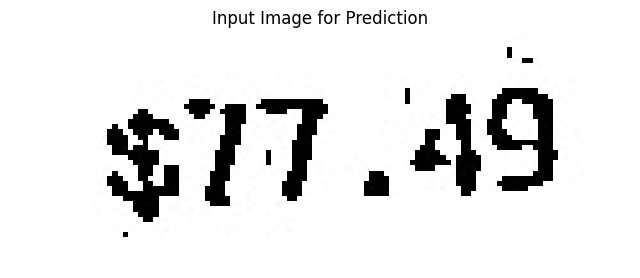

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


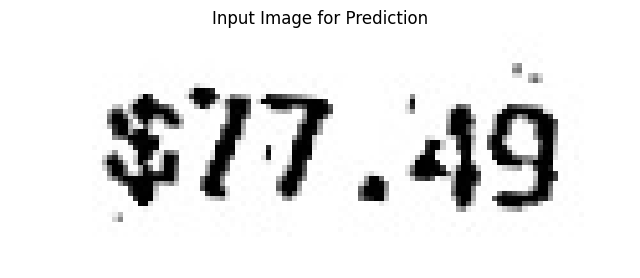

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


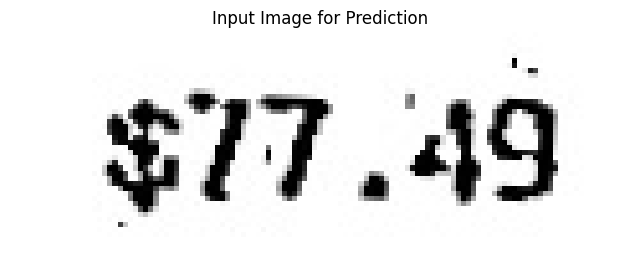

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


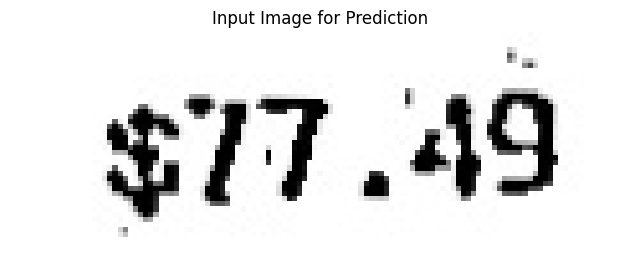

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


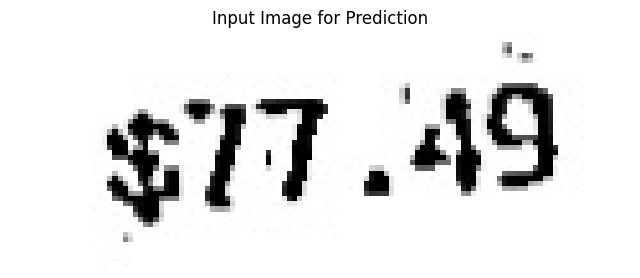

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


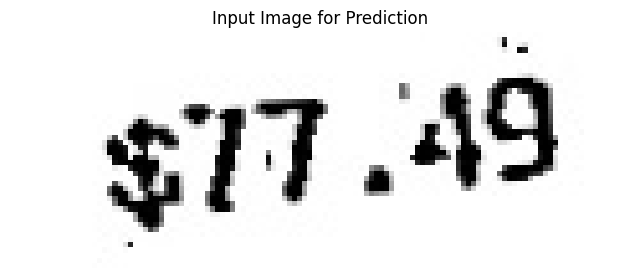

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


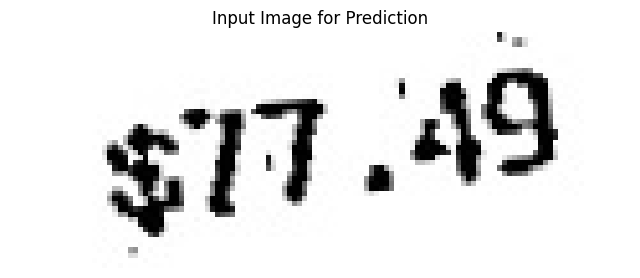

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


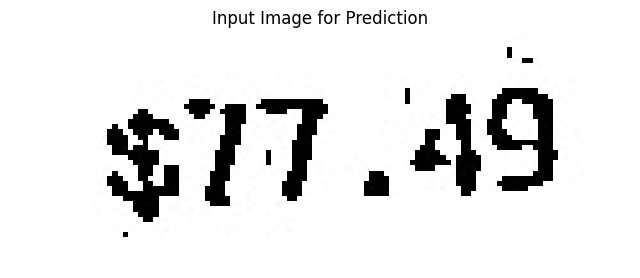

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


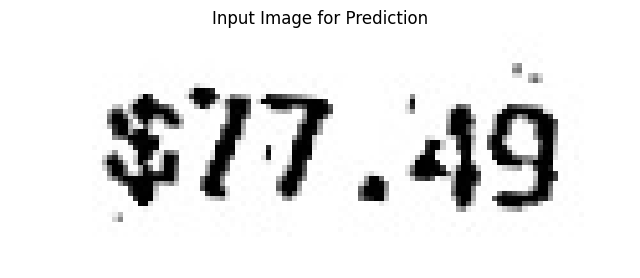

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


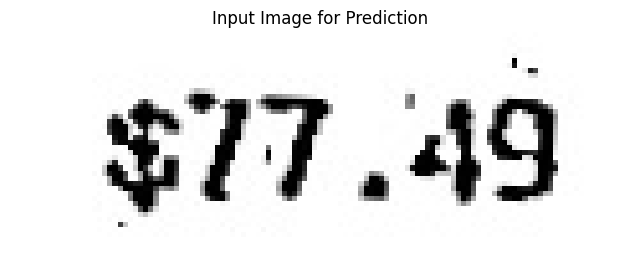

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


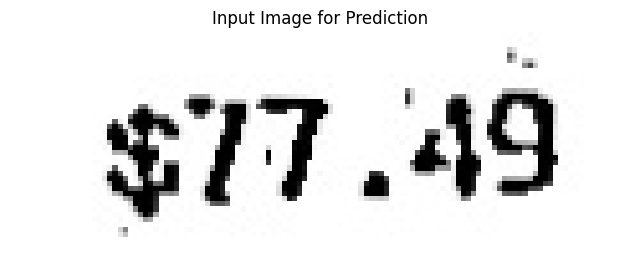

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


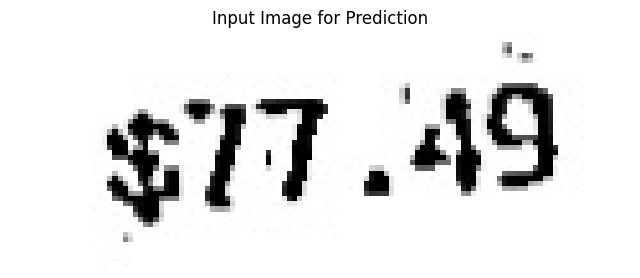

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


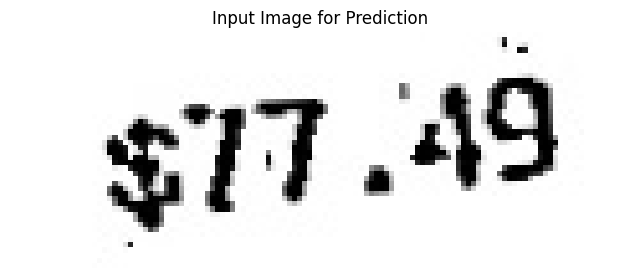

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


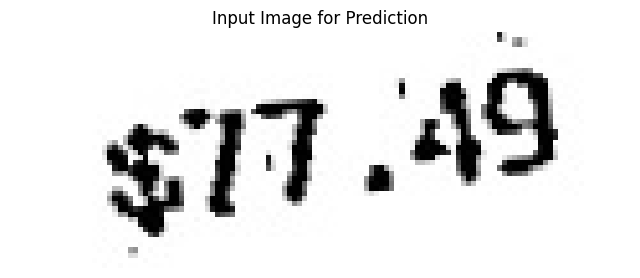

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


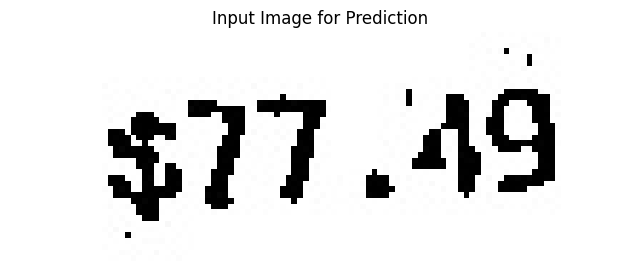

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


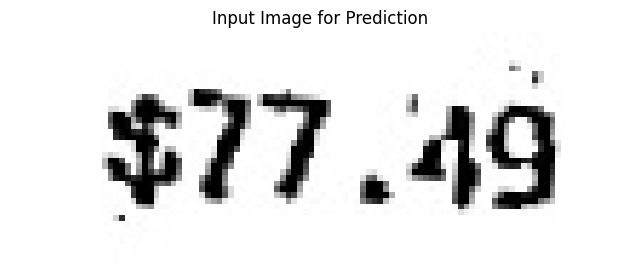

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


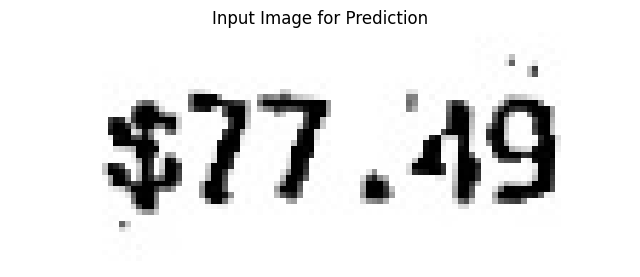

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


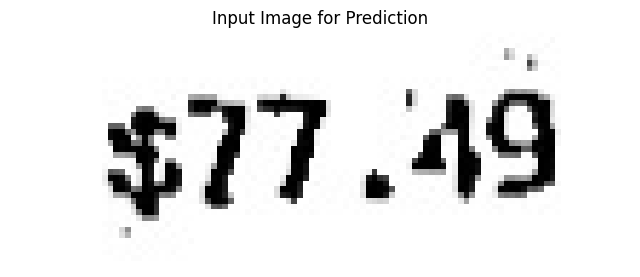

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


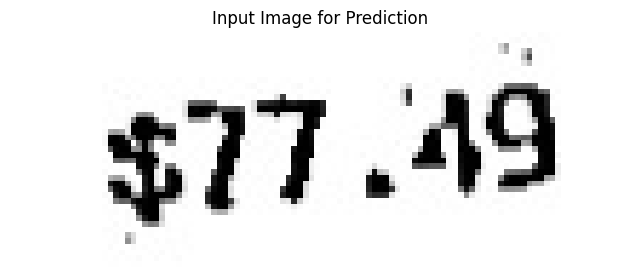

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


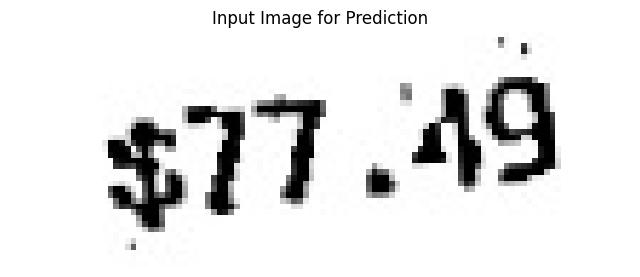

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


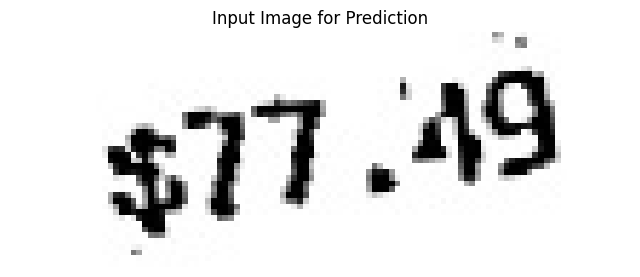

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


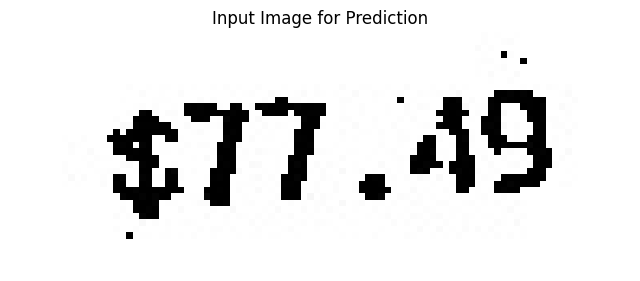

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


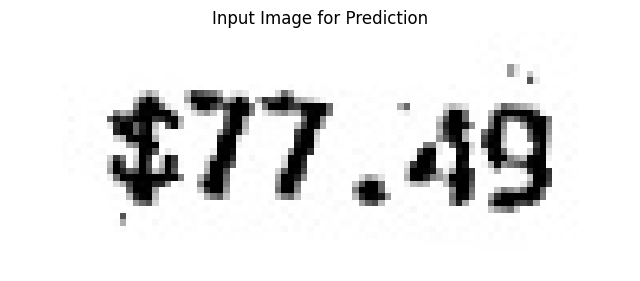

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


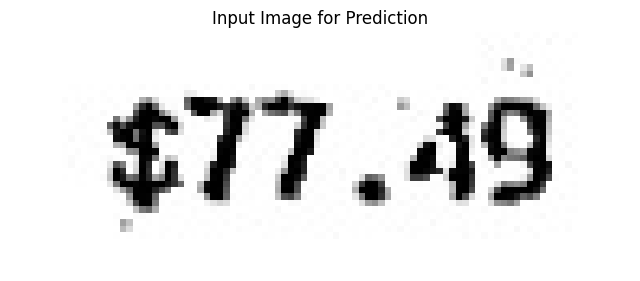

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


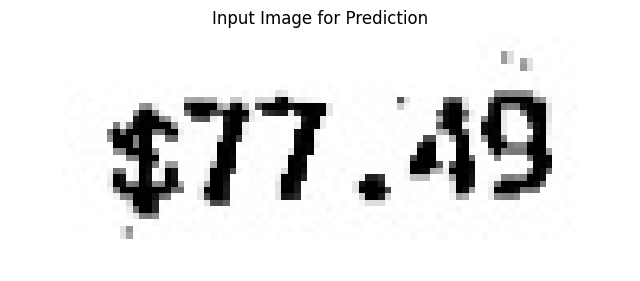

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


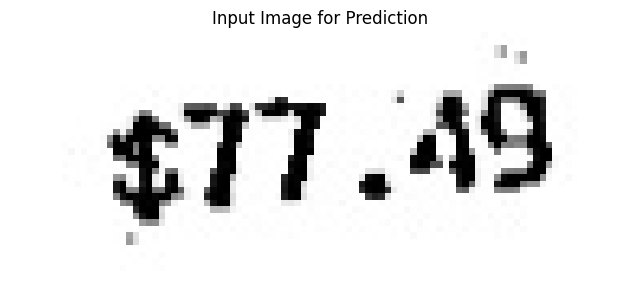

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


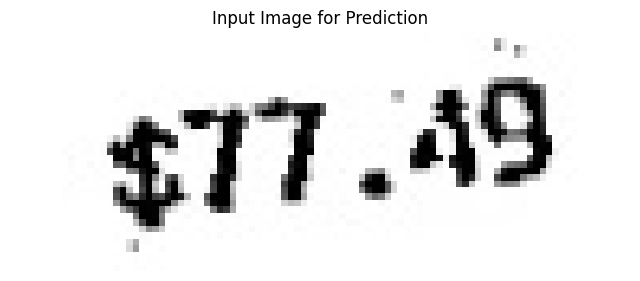

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


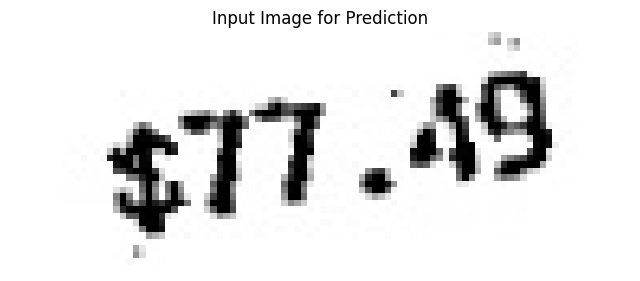

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


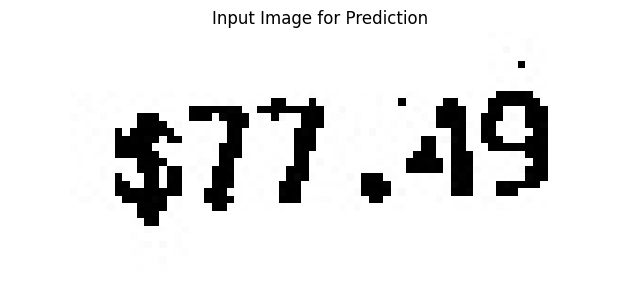

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


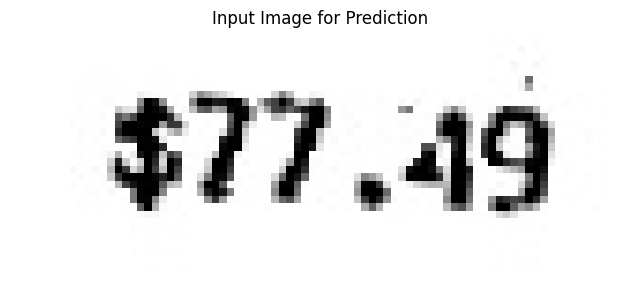

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


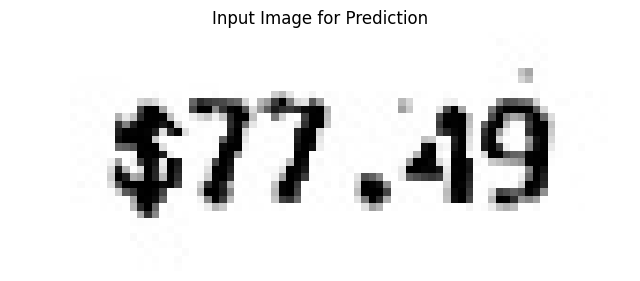

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


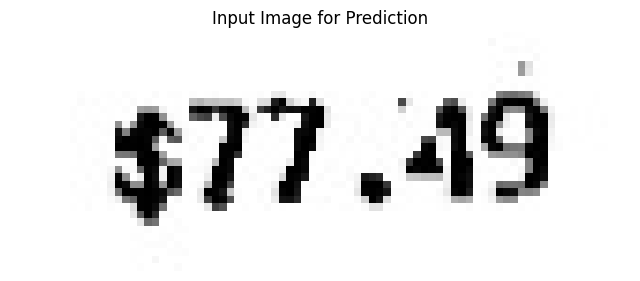

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


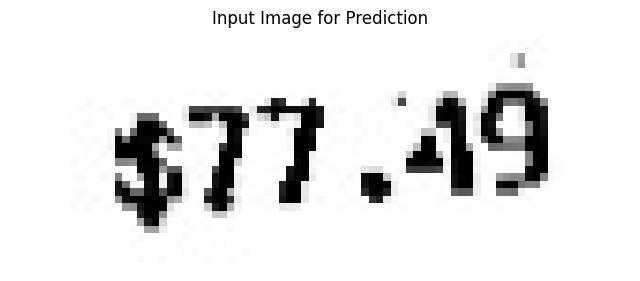

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


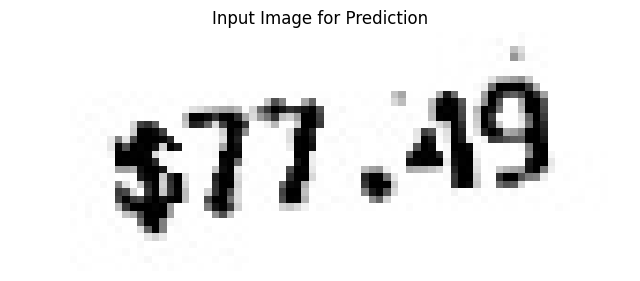

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


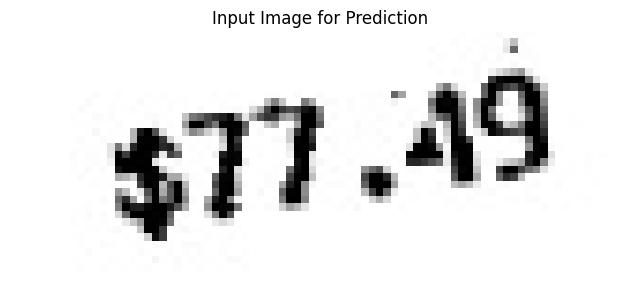

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


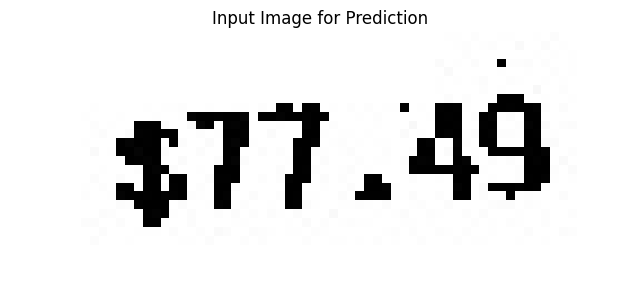

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


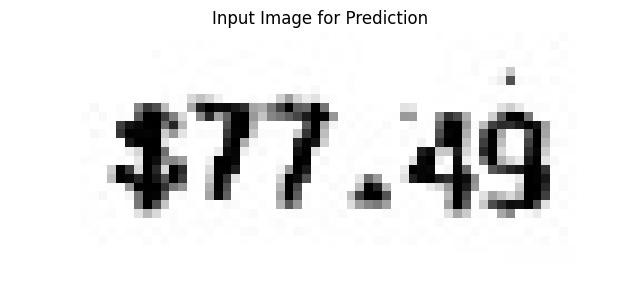

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


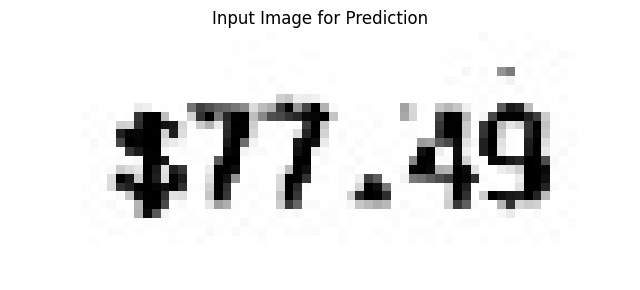

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


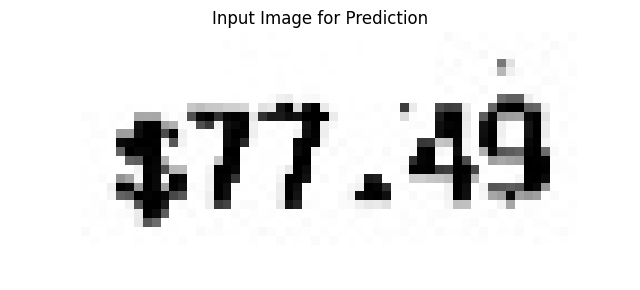

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


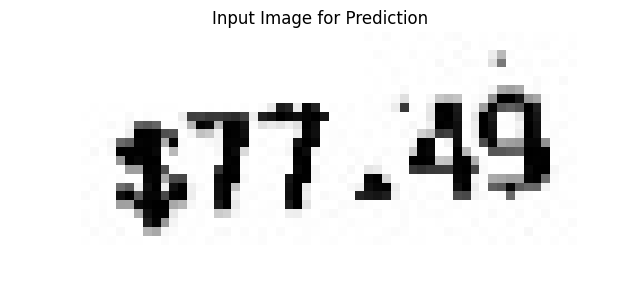

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


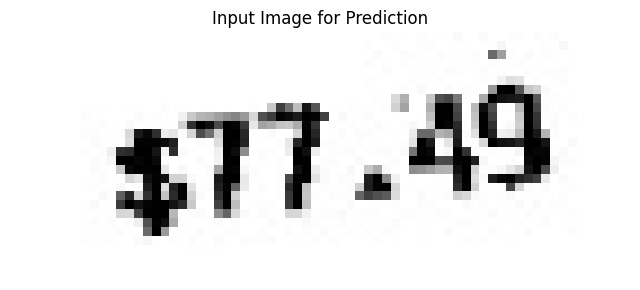

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


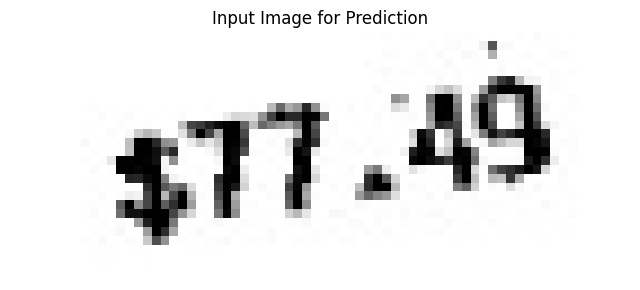

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


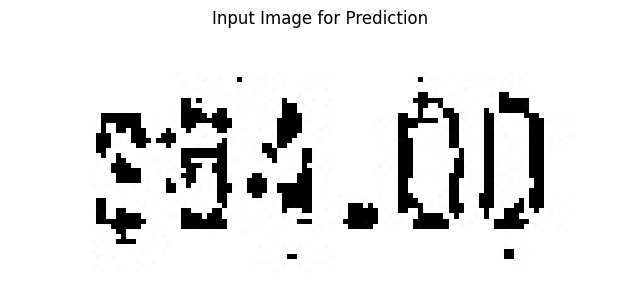

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


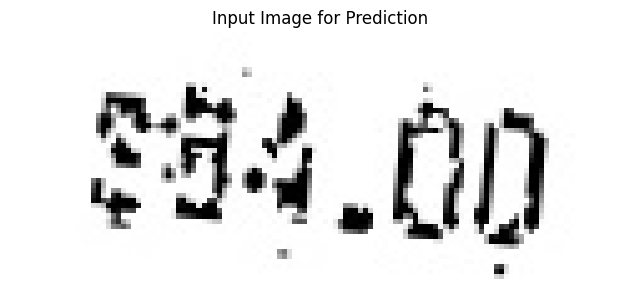

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


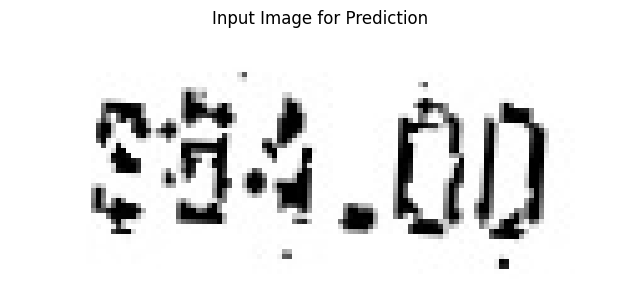

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


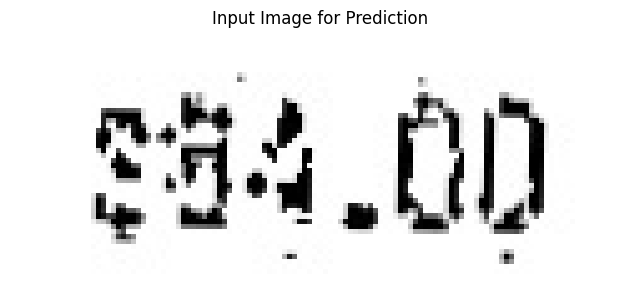

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


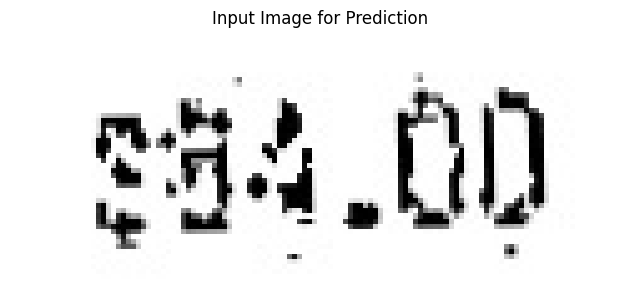

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


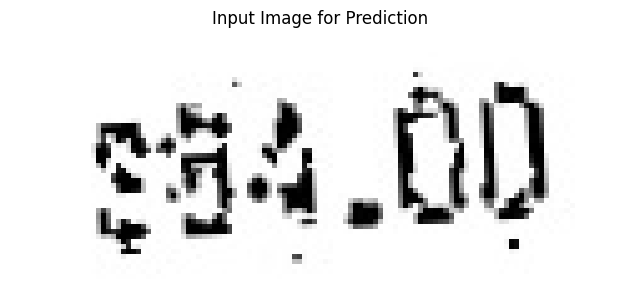

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


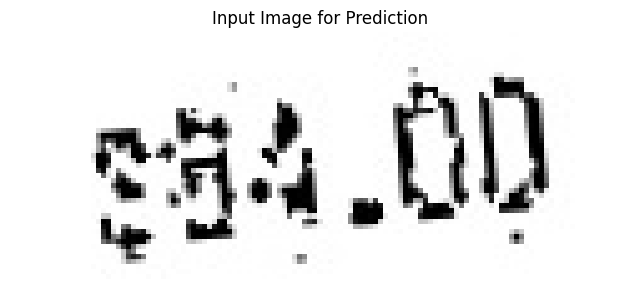

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


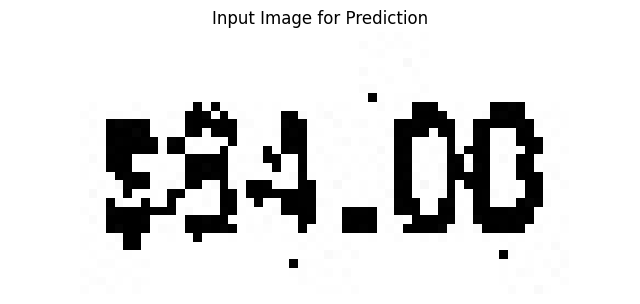

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


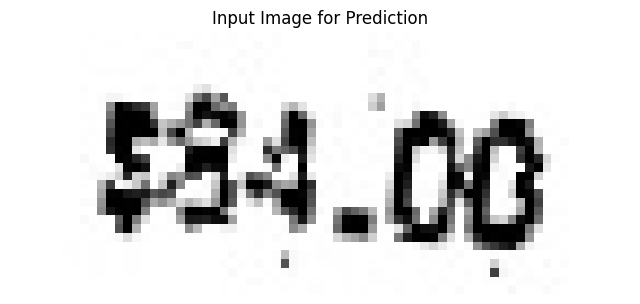

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


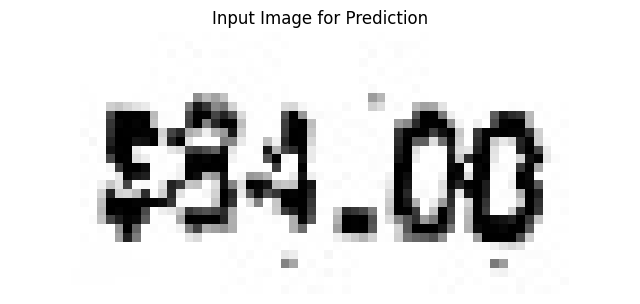

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


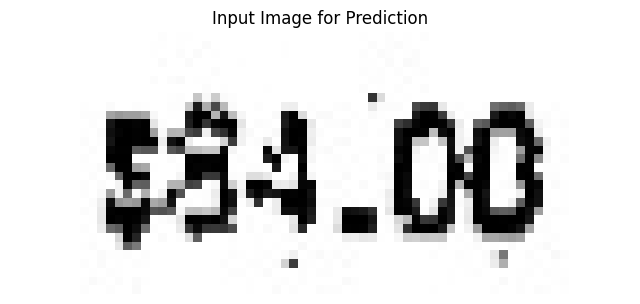

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


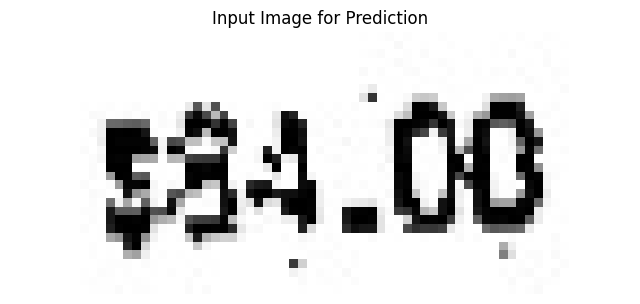

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


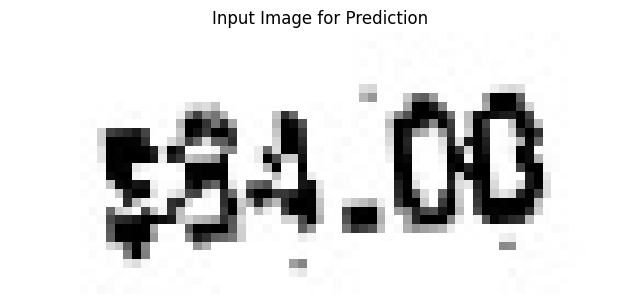

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


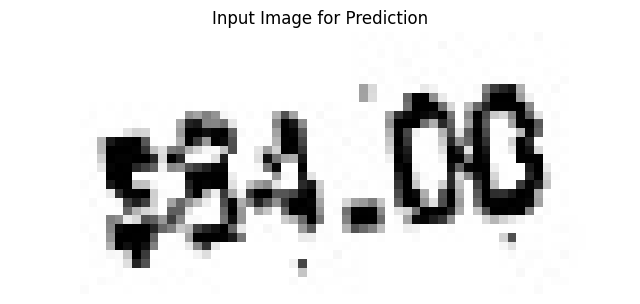

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


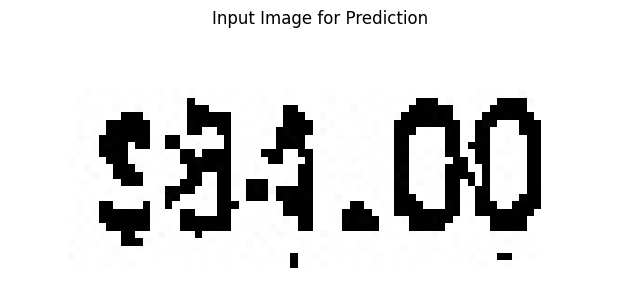

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


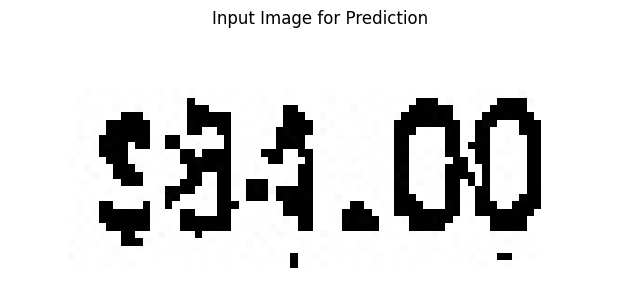

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


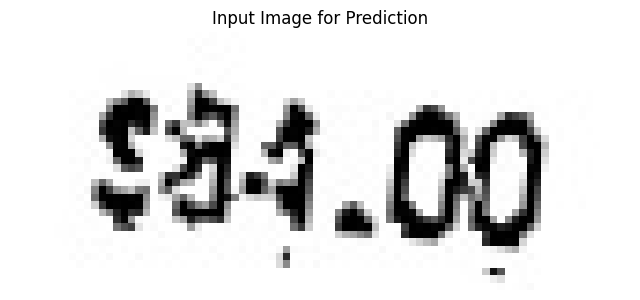

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


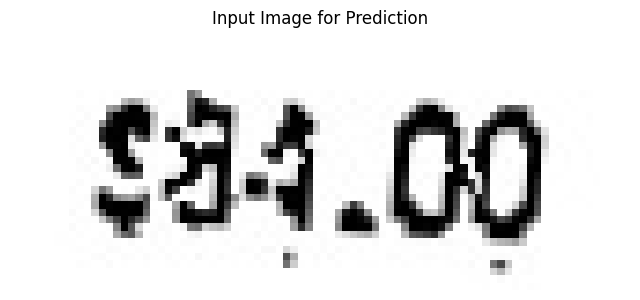

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


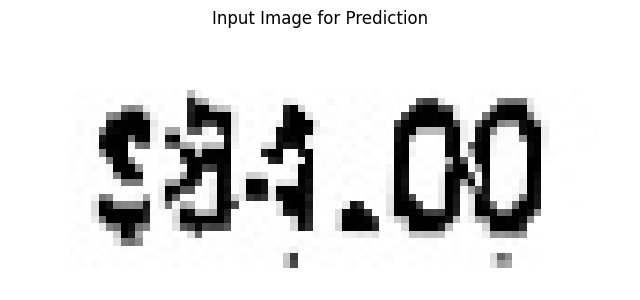

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


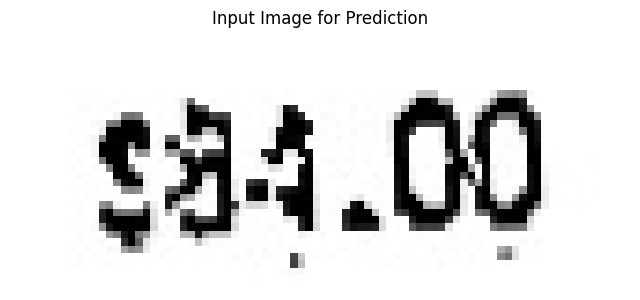

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


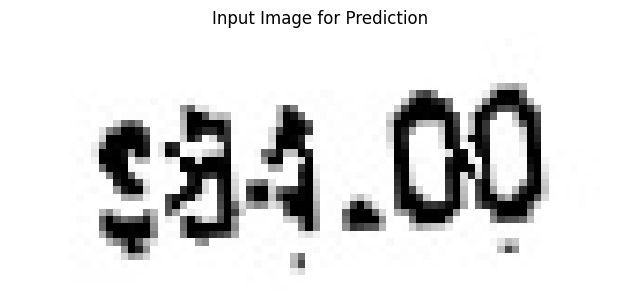

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


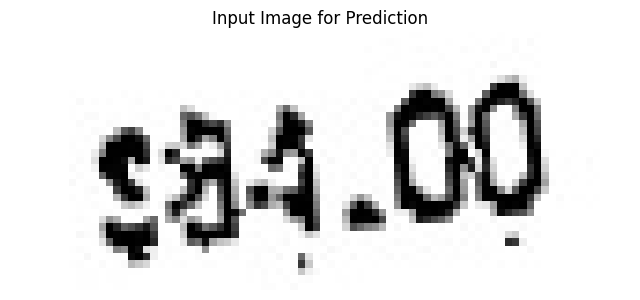

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


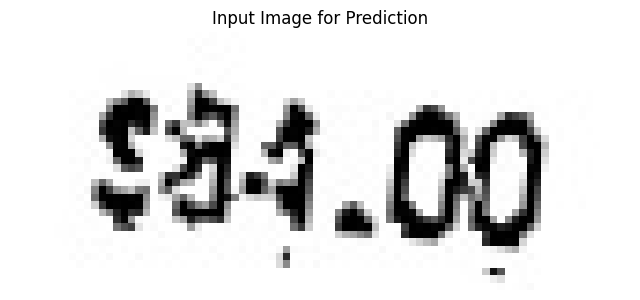

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


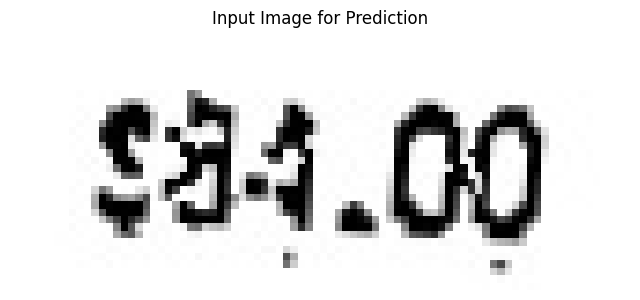

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


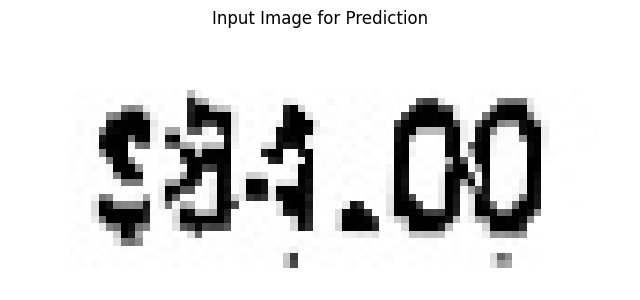

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


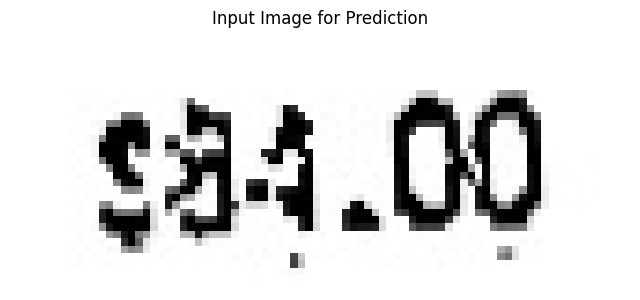

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


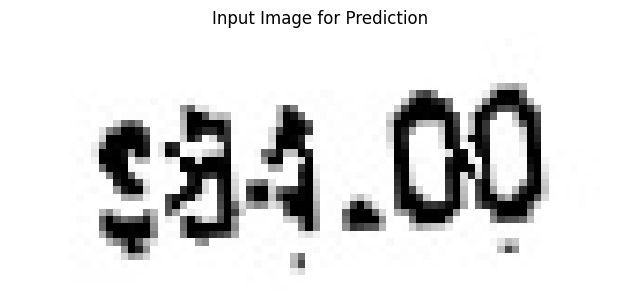

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


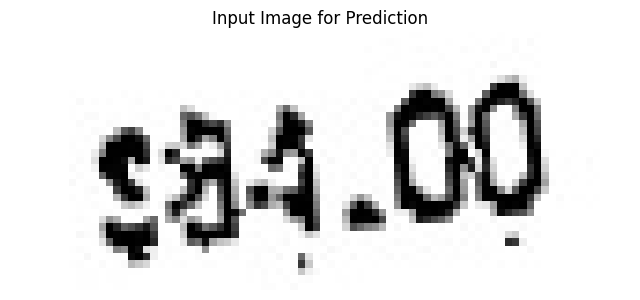

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


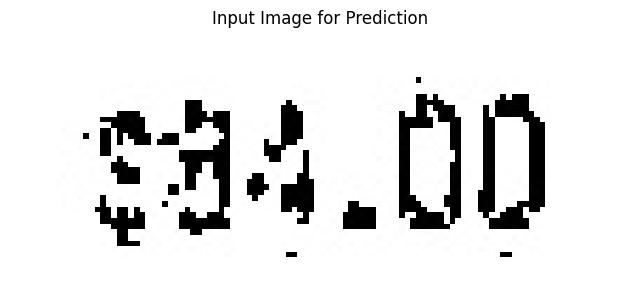

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


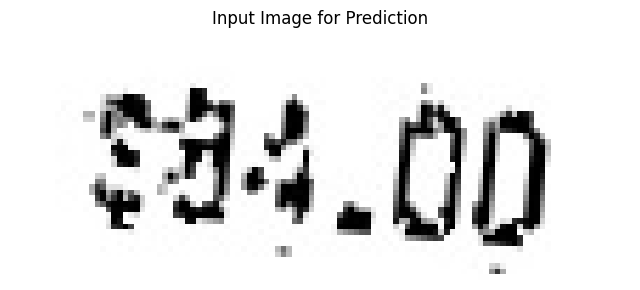

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


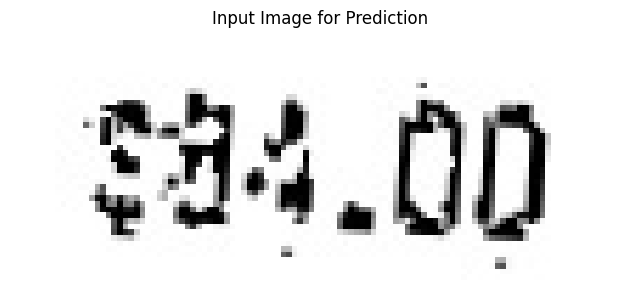

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


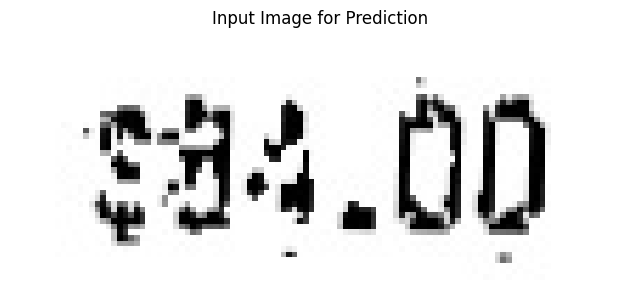

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


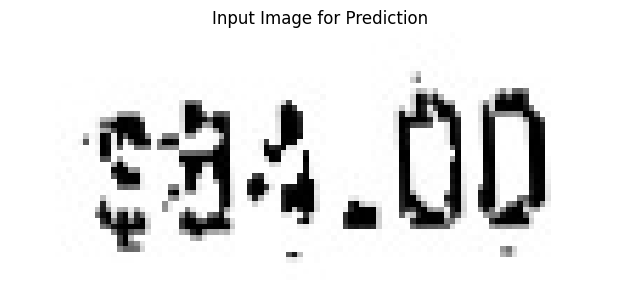

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


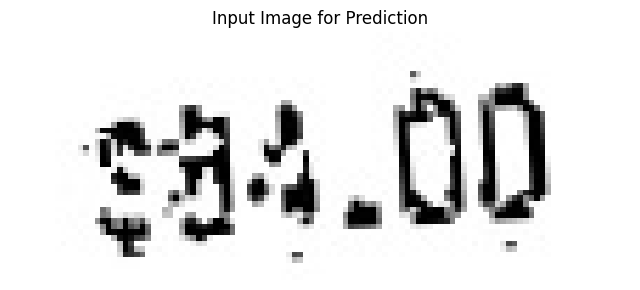

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


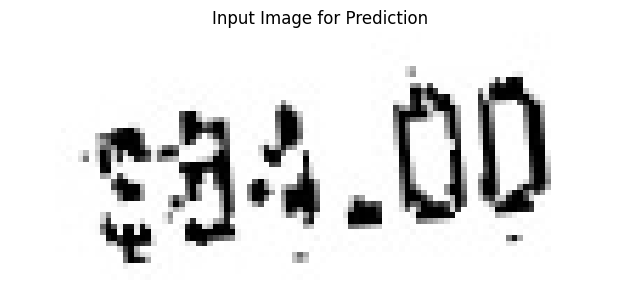

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


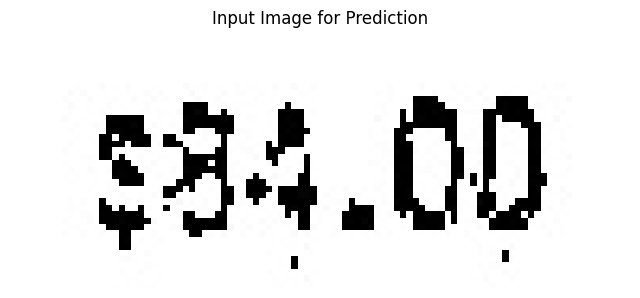

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


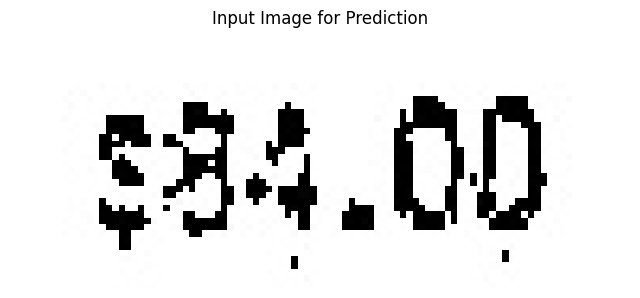

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


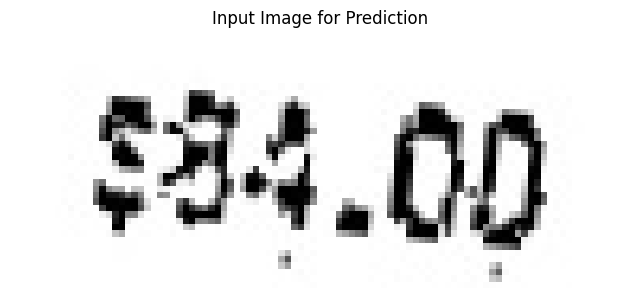

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


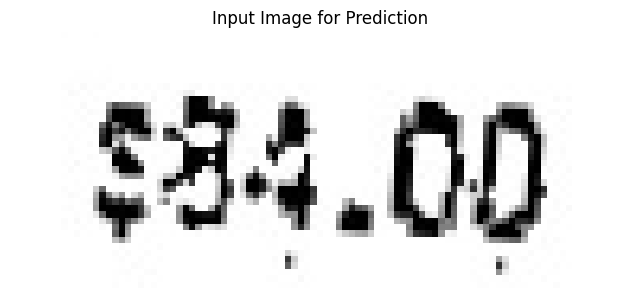

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


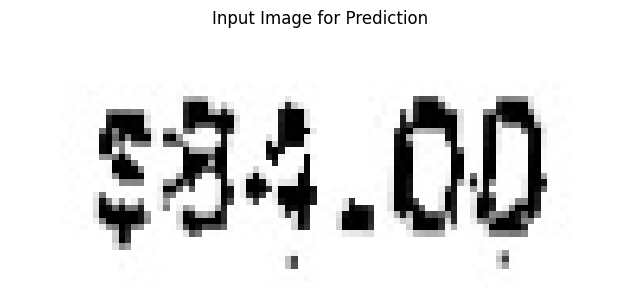

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


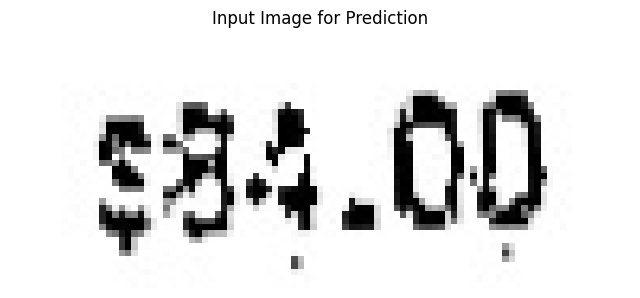

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


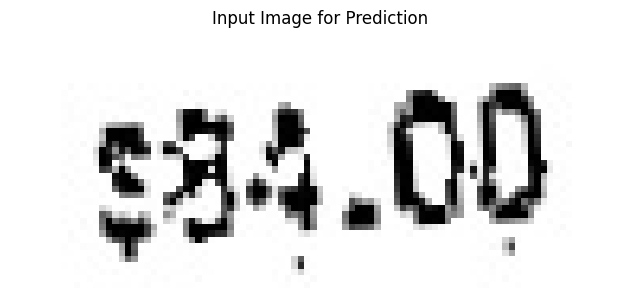

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


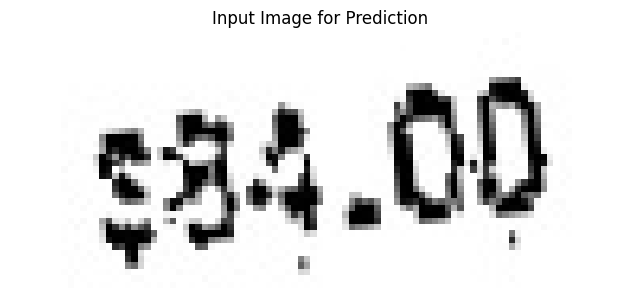

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


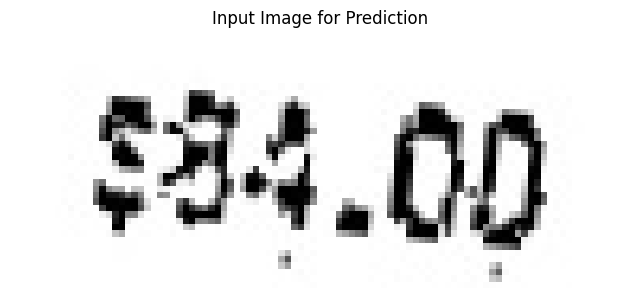

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


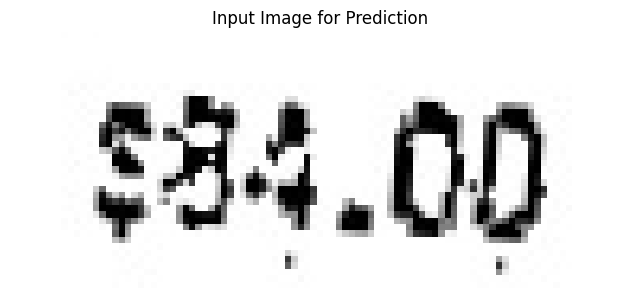

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


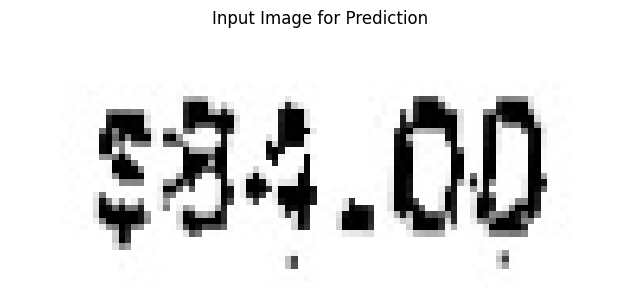

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


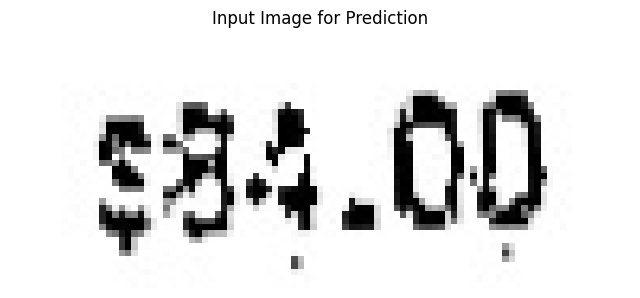

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


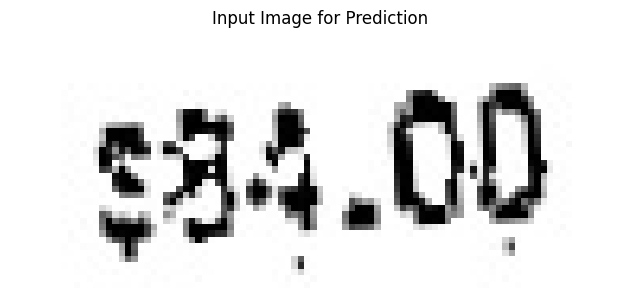

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


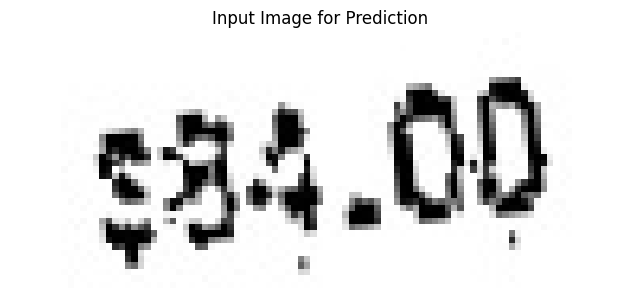

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['$', '8', '4', '.', '0']
Decoded: ['$', '8', '4', '.', '0', '0']


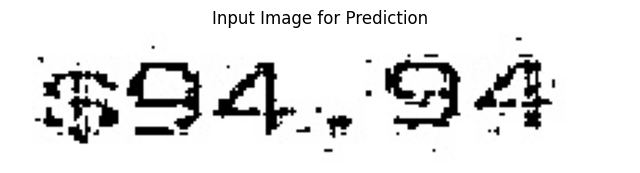

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Decoded: ['$', '9', '4', '.', '9', '4']
Decoded: ['$', '9', '4', '.', '9', '4']


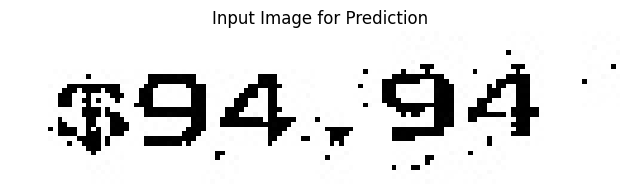

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['$', '9', '4', '.', '9', '4']
Decoded: ['$', '9', '4', '.', '9', '4']


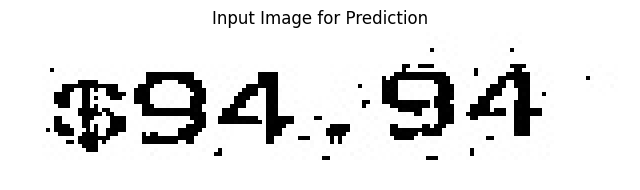

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['$', '9', '4', '.', '9', '4']
Decoded: ['$', '9', '4', '.', '9', '4']


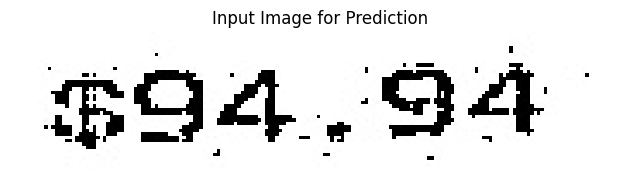

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Decoded: ['$', '9', '4', '.', '9', '4']
Decoded: ['$', '9', '4', '.', '9', '4']


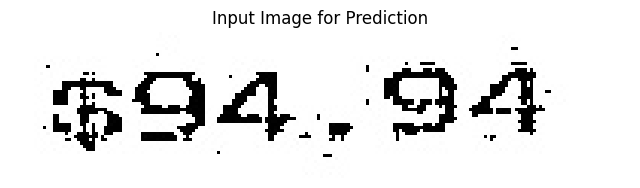

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['$', '9', '4', '.', '9', '4']
Decoded: ['$', '9', '4', '.', '9', '4']


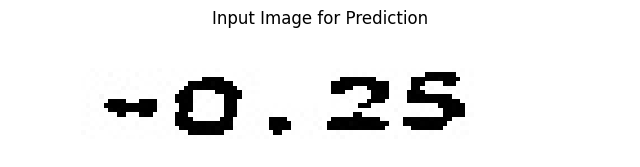

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Decoded: ['-', '0', '.', '2', '5']
Decoded: ['-', '0', '.', '2', '5']


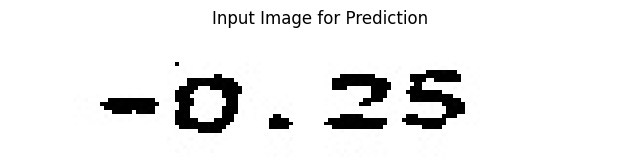

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['-', '0', '.', '2', '5']
Decoded: ['-', '0', '.', '2', '5']


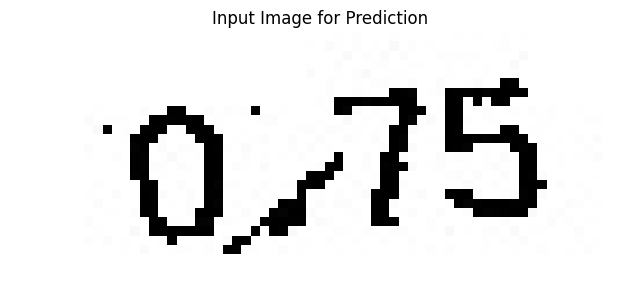

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['0', '.', '7', '0']
Decoded: ['0', '.', '7', '0']


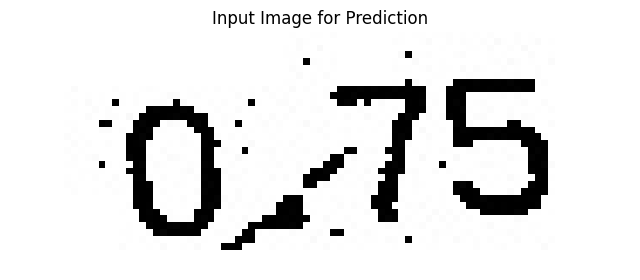

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['0', '.', '7', '5']
Decoded: ['0', '.', '7', '5']


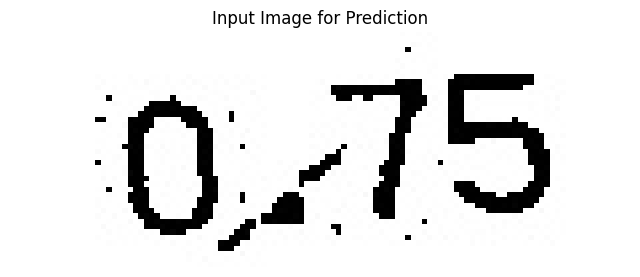

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['0', '.', '7', '5']
Decoded: ['0', '.', '7', '5']


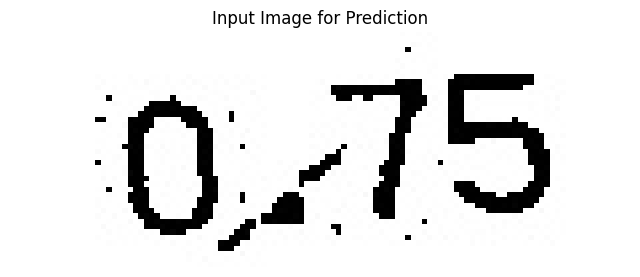

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['0', '.', '7', '5']
Decoded: ['0', '.', '7', '5']


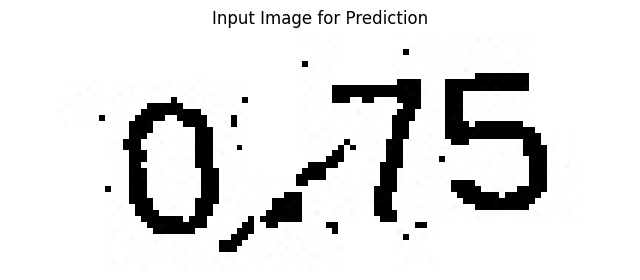

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['0', '.', '7', '5']
Decoded: ['0', '.', '7', '5']


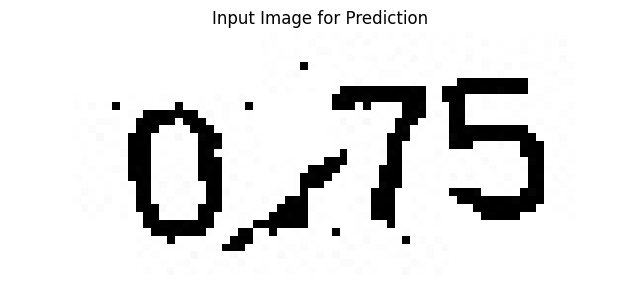

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['4', '.', '0']
Decoded: ['4', '.', '0', '0']


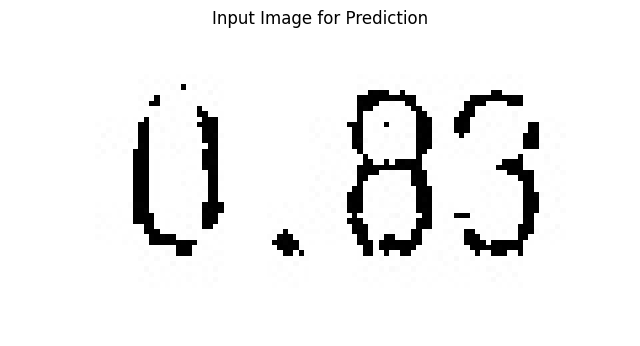

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Decoded: ['7', '.', '8', '9']
Decoded: ['7', '.', '8', '9']


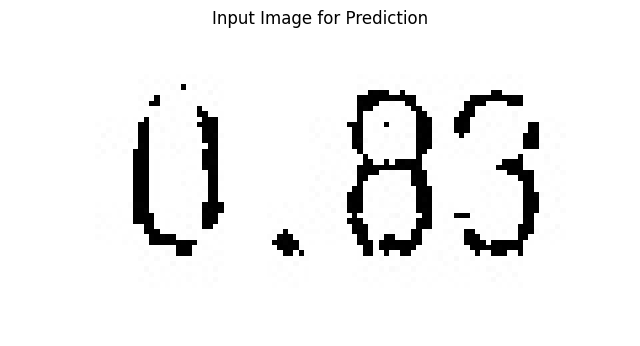

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['7', '.', '8', '9']
Decoded: ['7', '.', '8', '9']


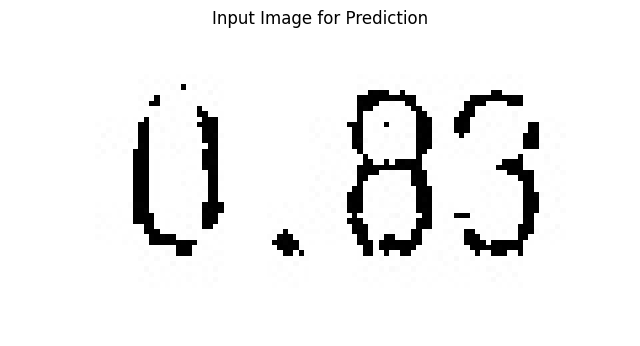

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['7', '.', '8', '9']
Decoded: ['7', '.', '8', '9']


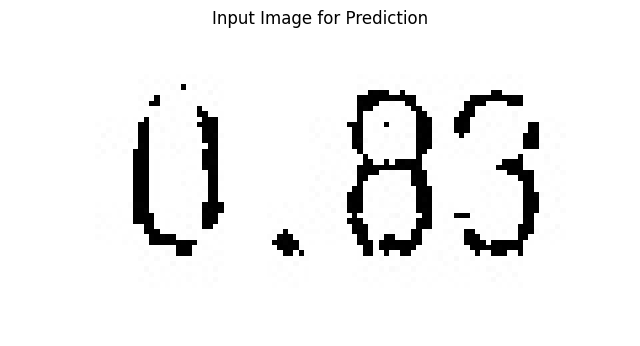

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['7', '.', '8', '9']
Decoded: ['7', '.', '8', '9']


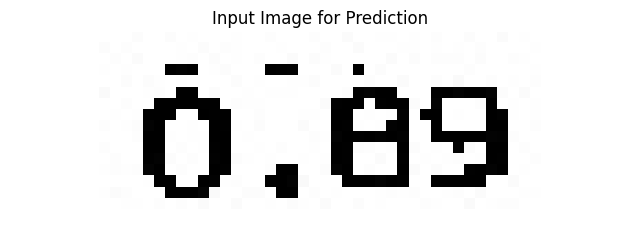

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Decoded: ['0', '.', '8', '9']
Decoded: ['0', '.', '8', '9']


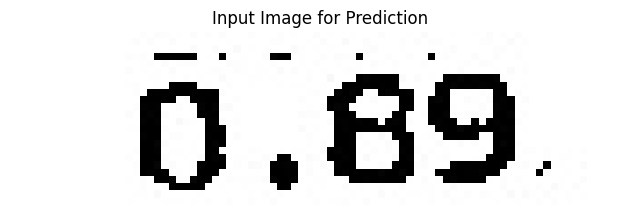

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Decoded: ['0', '.', '8', '9']
Decoded: ['0', '.', '8', '9']


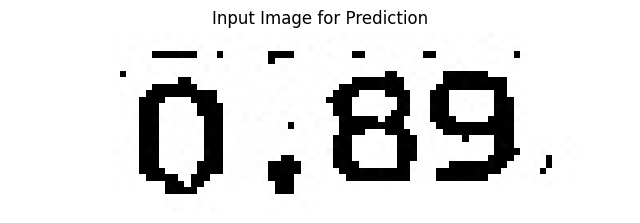

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['0', '.', '8', '9']
Decoded: ['0', '.', '8', '9']


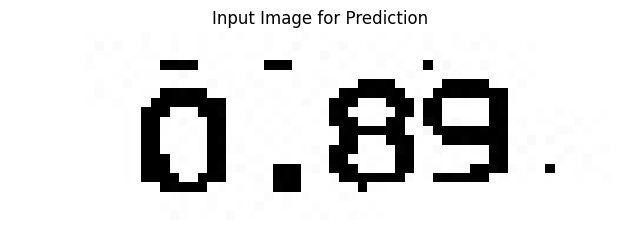

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Decoded: ['0', '.', '8', '9']
Decoded: ['0', '.', '8', '9']


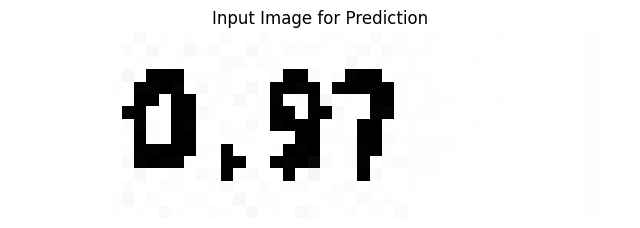

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['0', '.', '9', '7']
Decoded: ['0', '.', '9', '7']


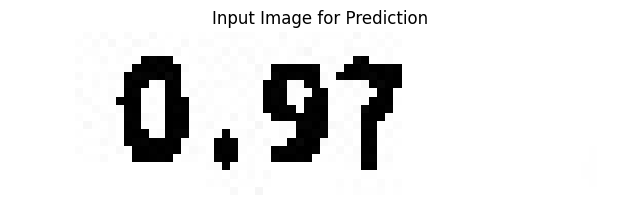

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Decoded: ['0', '.', '9', '7']
Decoded: ['0', '.', '9', '7']


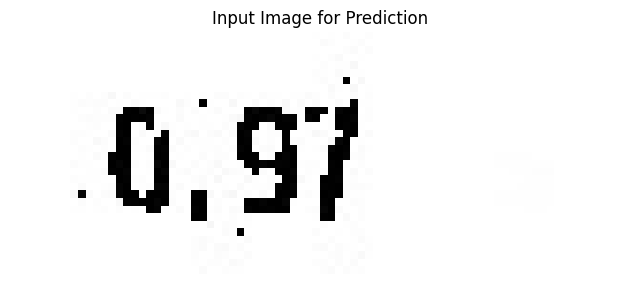

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['0', '.', '9', '7']
Decoded: ['0', '.', '9', '7']


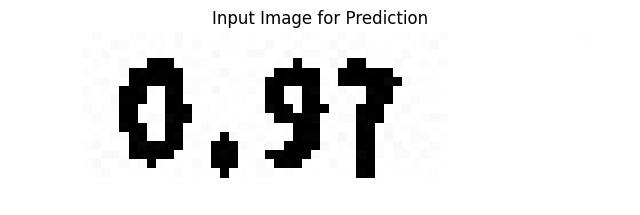

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['0', '.', '9', '7']
Decoded: ['0', '.', '9', '7']


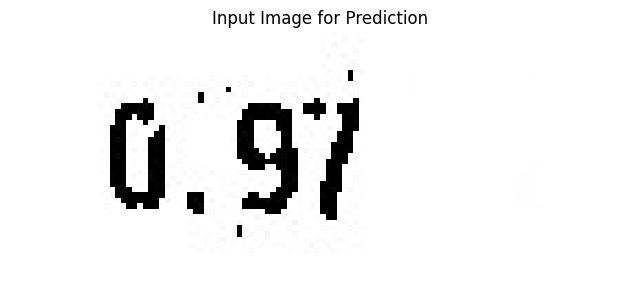

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['0', '.', '9', '7']
Decoded: ['0', '.', '9', '7']


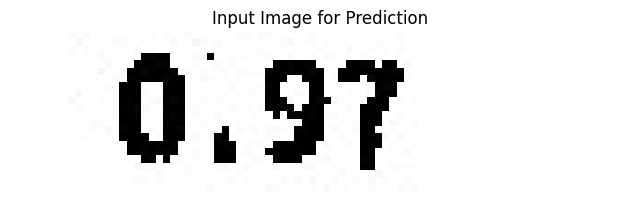

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Decoded: ['0', '.', '9', '7']
Decoded: ['0', '.', '9', '7']


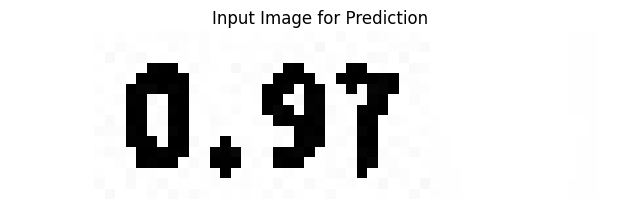

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Decoded: ['0', '.', '9', '7']
Decoded: ['0', '.', '9', '7']


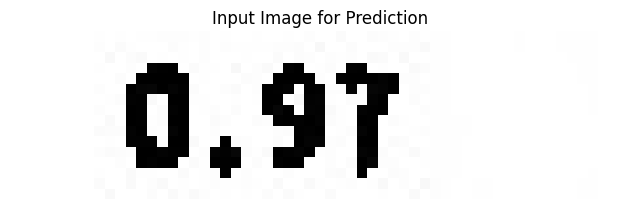

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['0', '.', '9', '7']
Decoded: ['0', '.', '9', '7']


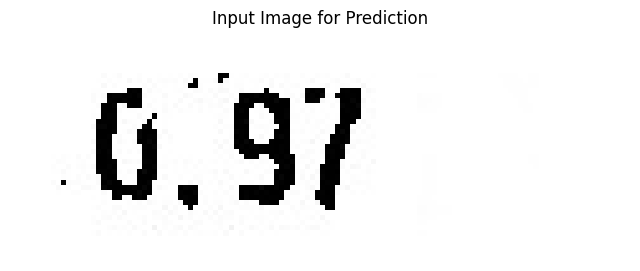

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['0', '.', '9', '7']
Decoded: ['0', '.', '9', '7']


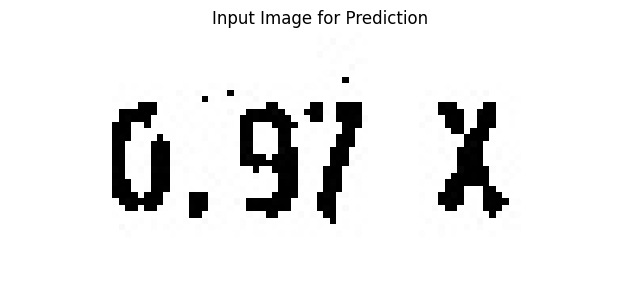

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['7', '.', '9', '7']
Decoded: ['7', '.', '9', '7']


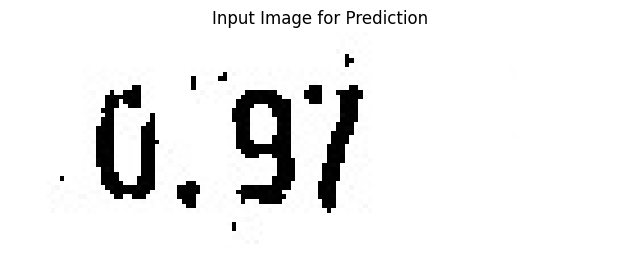

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Decoded: ['0', '.', '9', '7']
Decoded: ['0', '.', '9', '7']


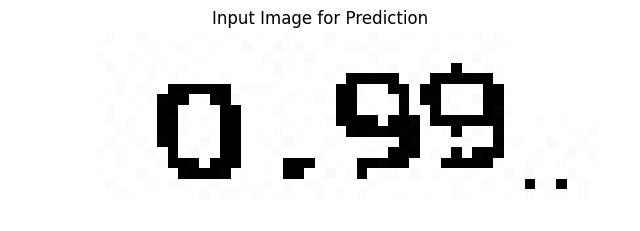

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


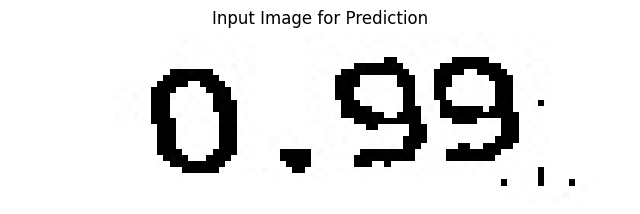

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


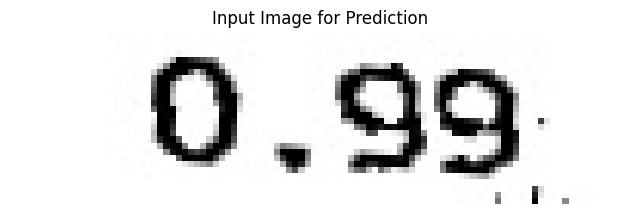

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


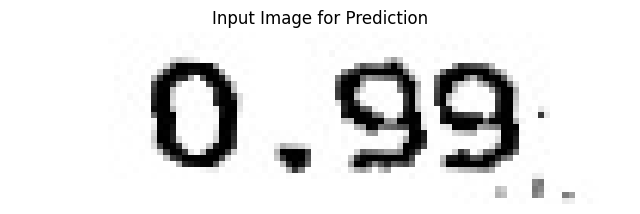

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


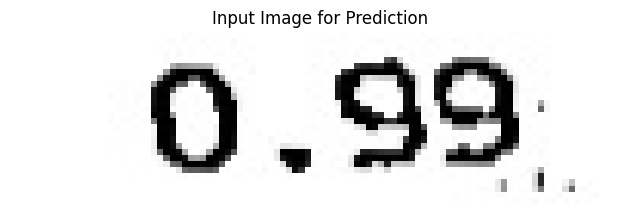

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


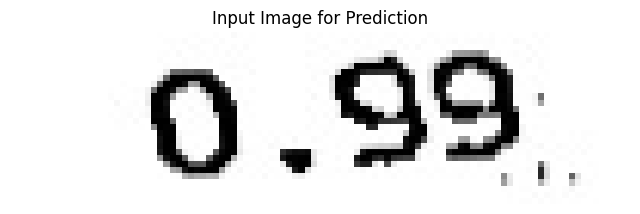

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


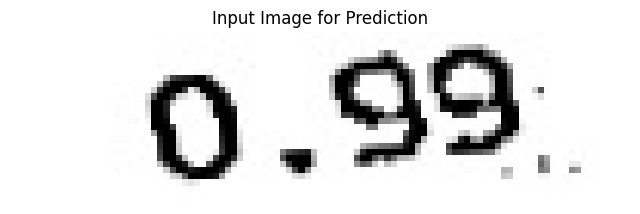

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


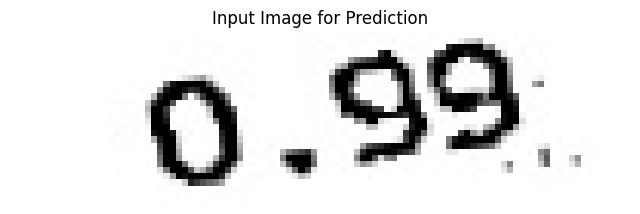

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


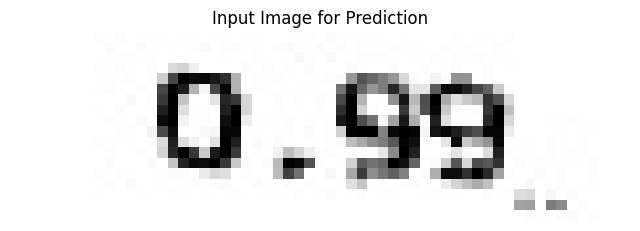

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


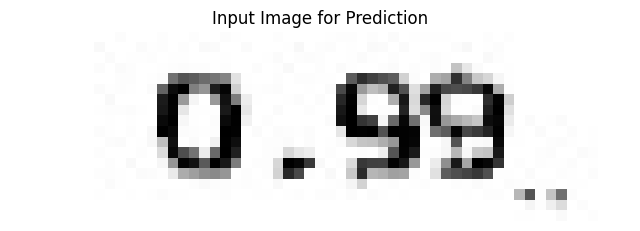

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


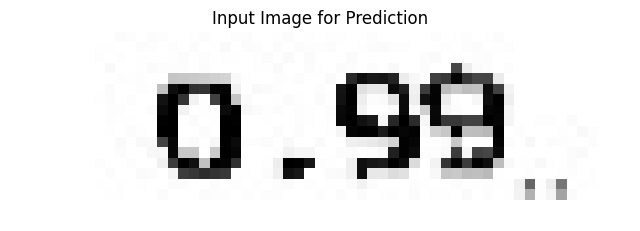

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


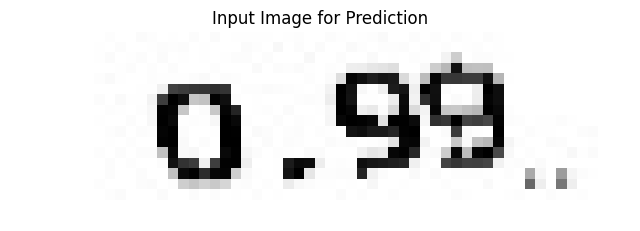

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


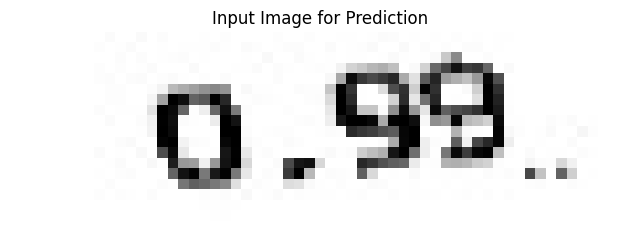

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


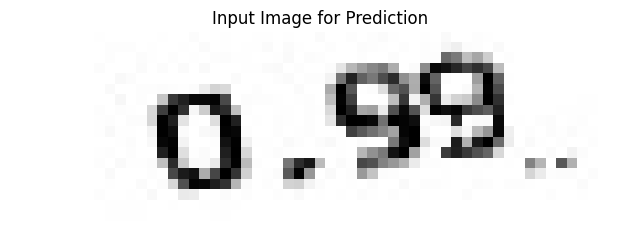

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


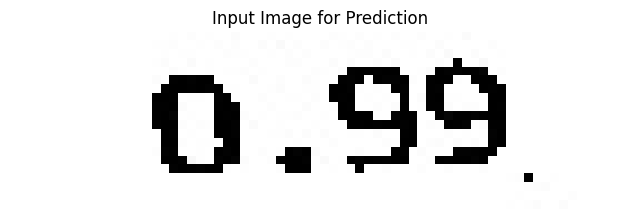

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


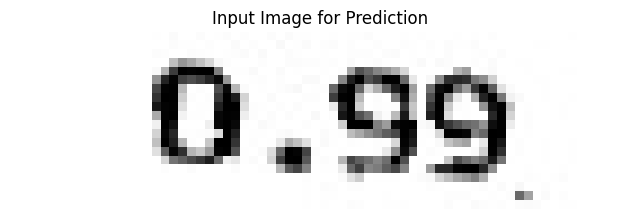

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


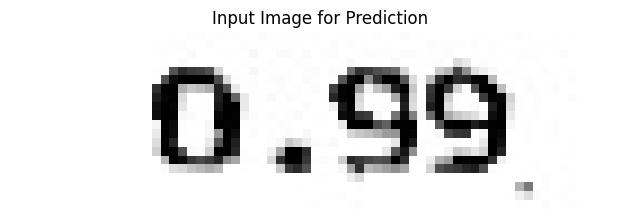

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


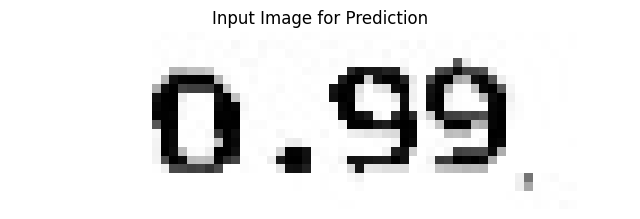

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


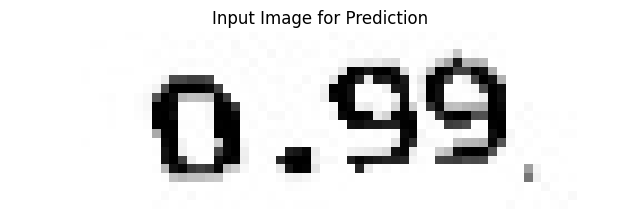

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


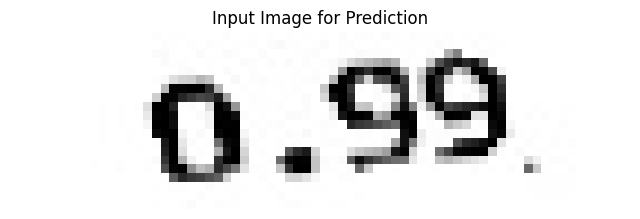

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


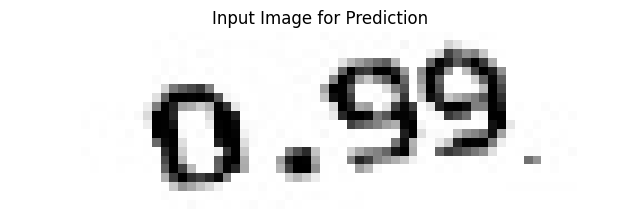

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


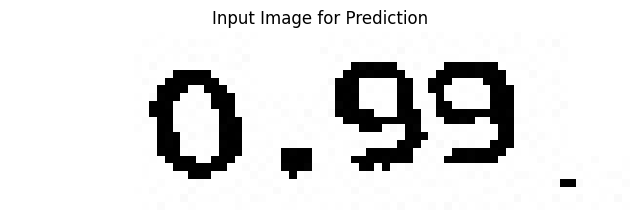

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


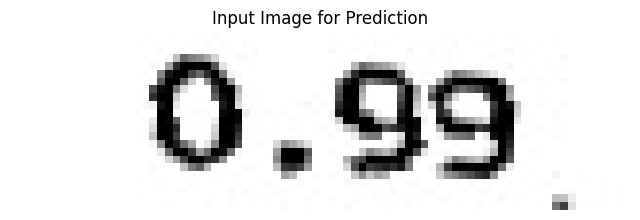

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


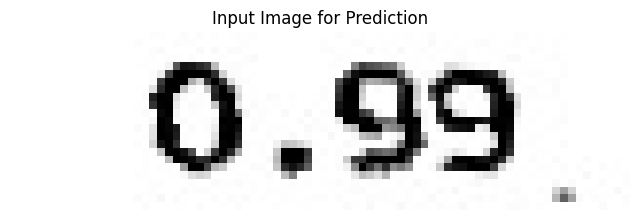

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


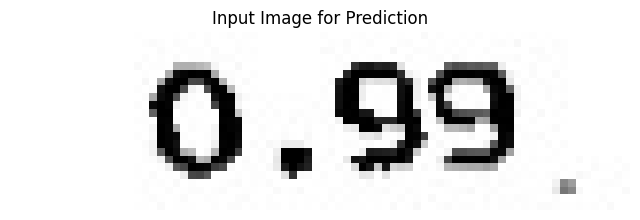

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


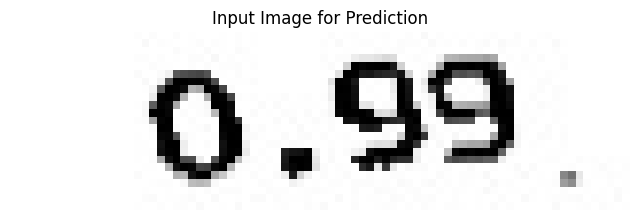

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


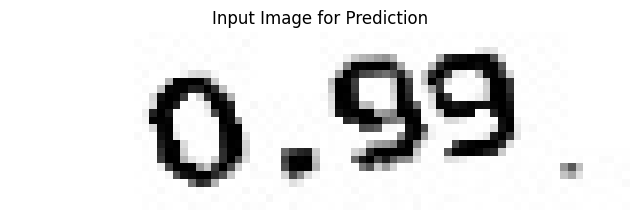

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


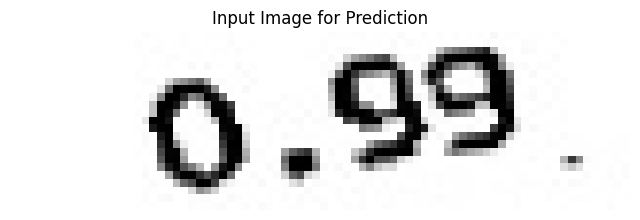

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


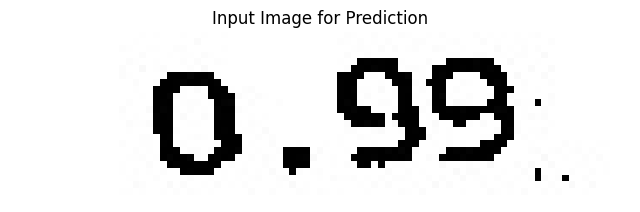

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


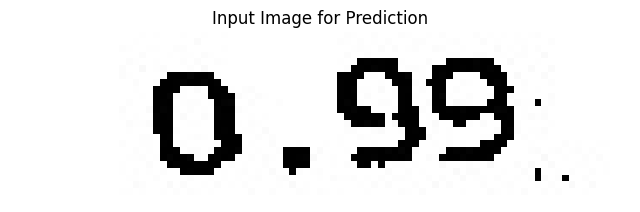

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['0', '.', '9']
Decoded: ['0', '.', '9', '9']


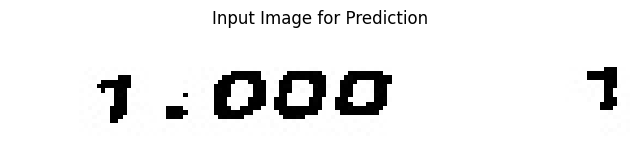

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


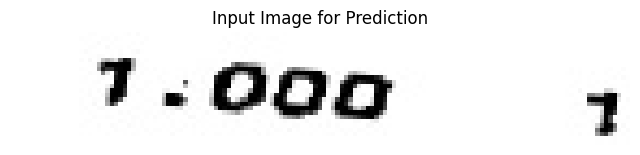

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


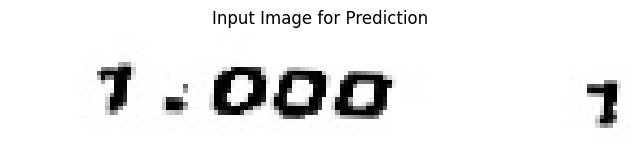

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


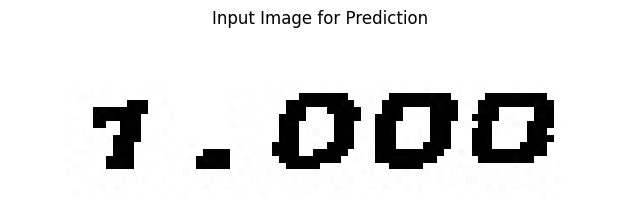

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


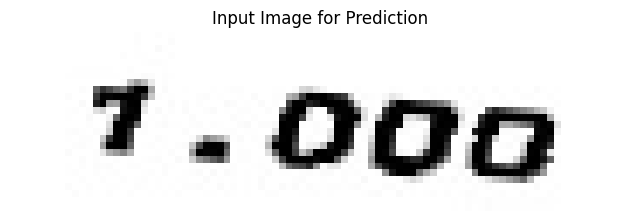

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


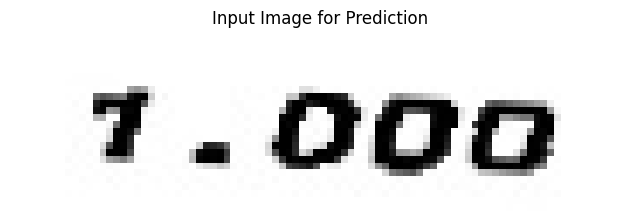

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


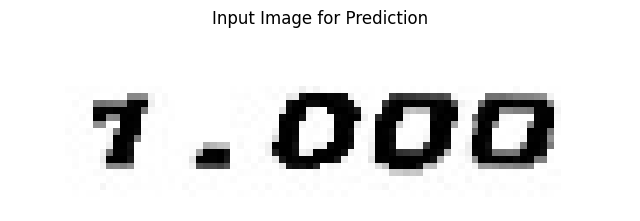

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


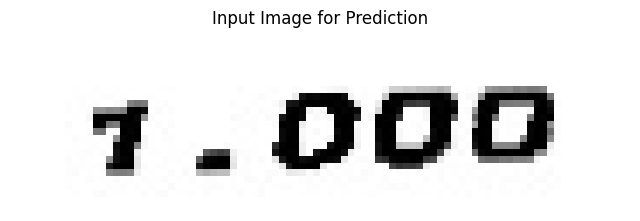

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


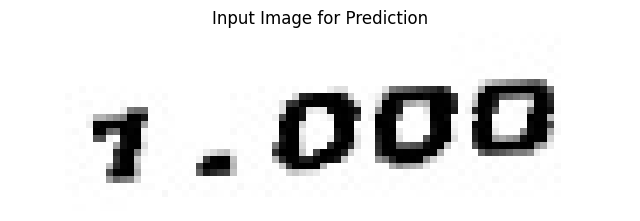

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


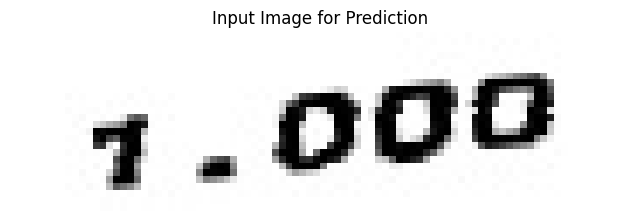

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


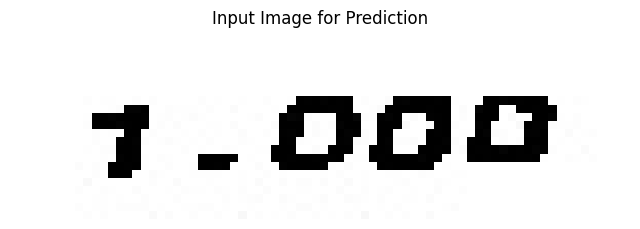

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


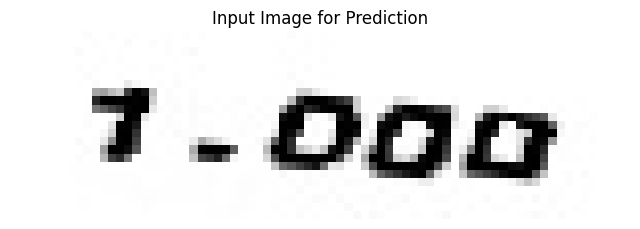

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


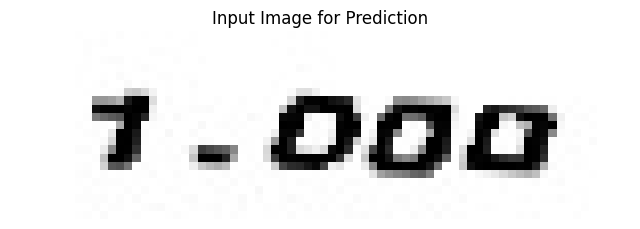

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


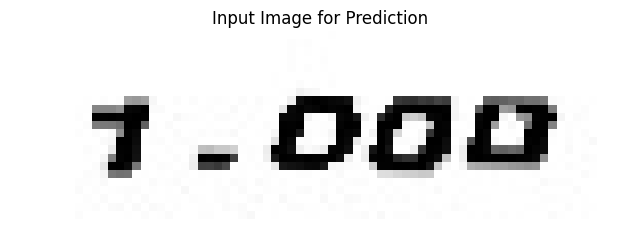

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


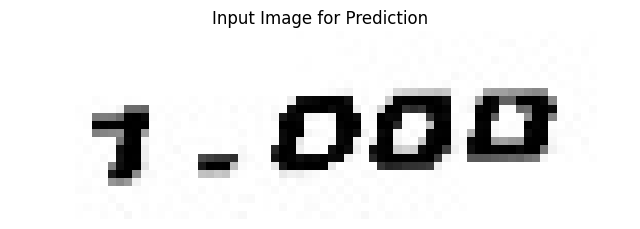

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


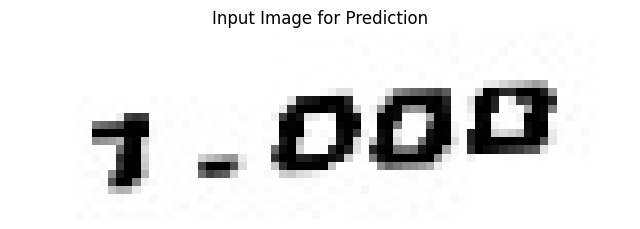

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


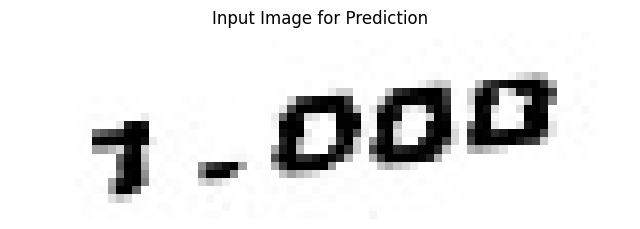

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


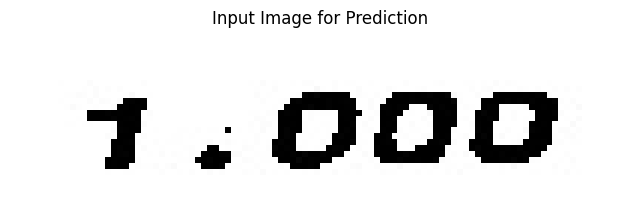

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


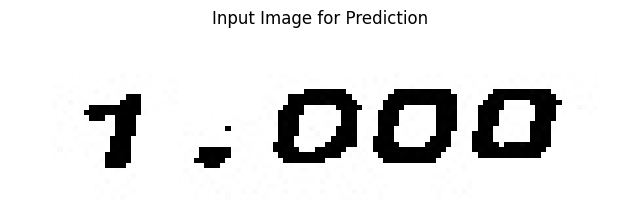

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


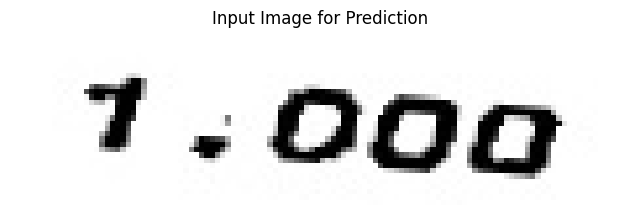

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


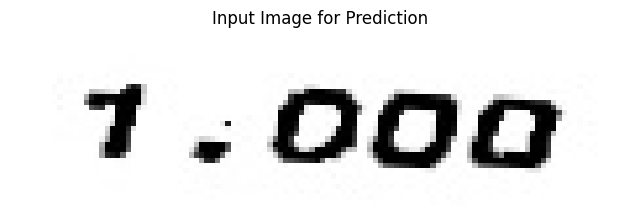

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


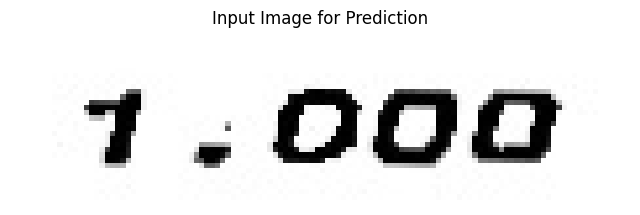

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


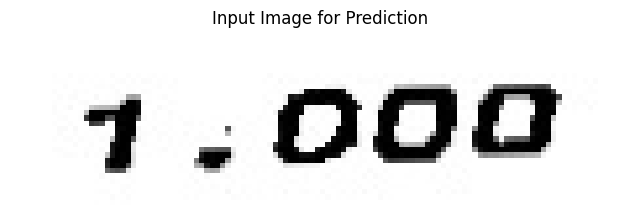

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


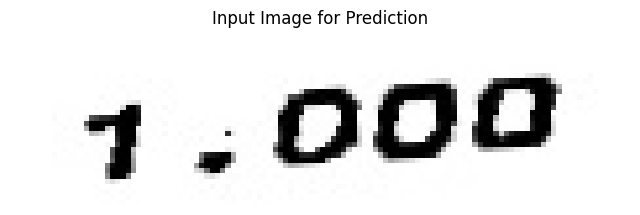

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


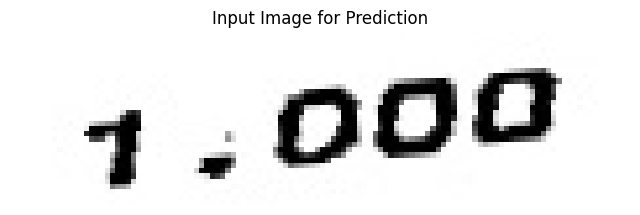

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


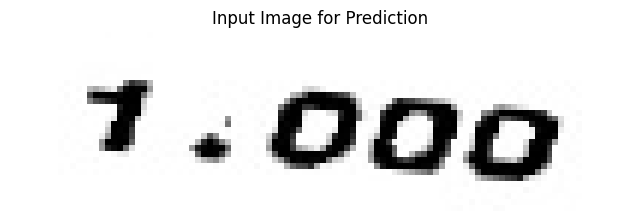

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


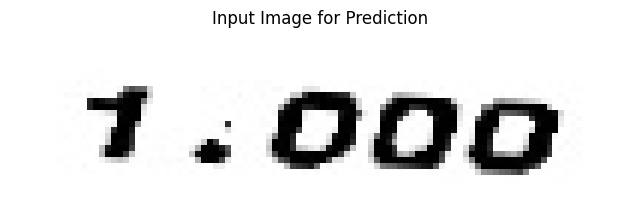

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


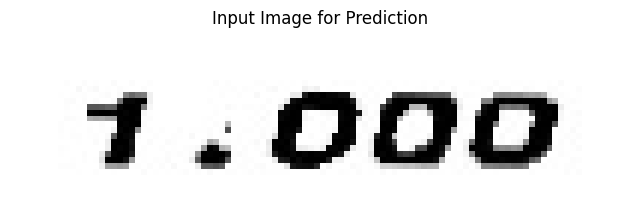

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


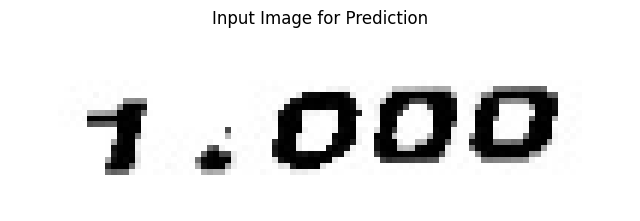

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


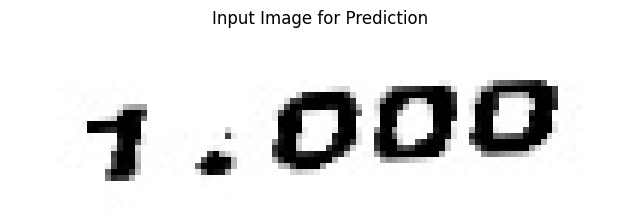

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


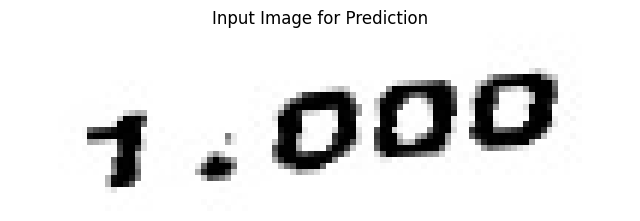

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Decoded: ['1', '.', '0']
Decoded: ['1', '.', '0', '0', '0']


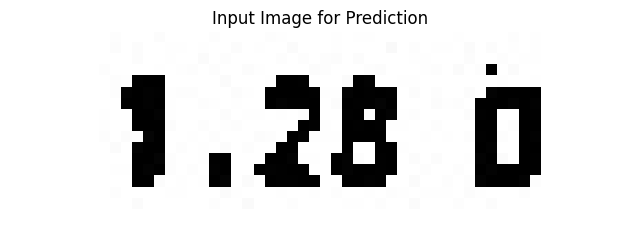

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Decoded: ['1', '.', '2', '8']
Decoded: ['1', '.', '2', '8']


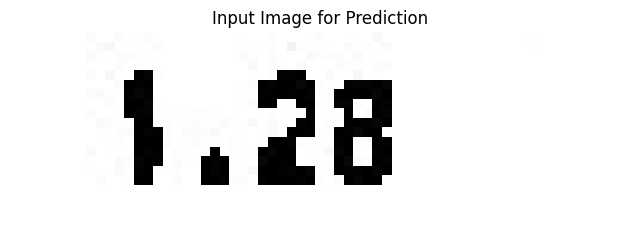

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Decoded: ['1', '.', '2', '8']
Decoded: ['1', '.', '2', '8']


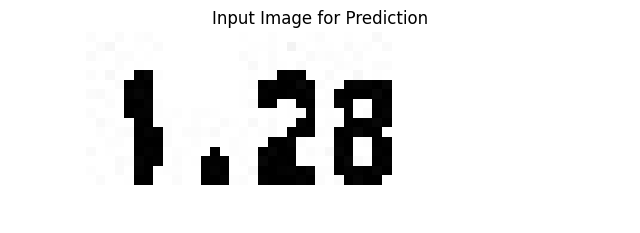

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Decoded: ['1', '.', '2', '8']
Decoded: ['1', '.', '2', '8']


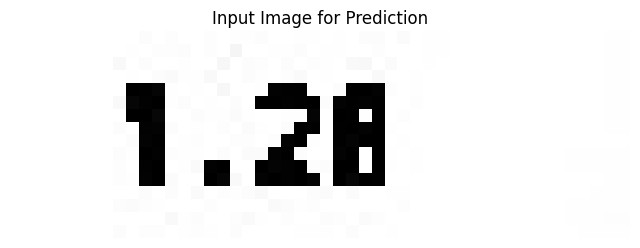

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Decoded: ['1', '.', '2', '8']
Decoded: ['1', '.', '2', '8']


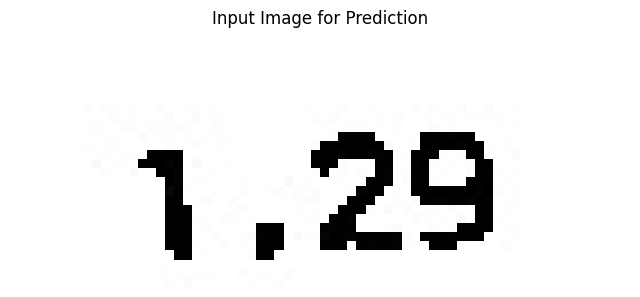

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Decoded: ['1', '.', '2', '9']
Decoded: ['1', '.', '2', '9']


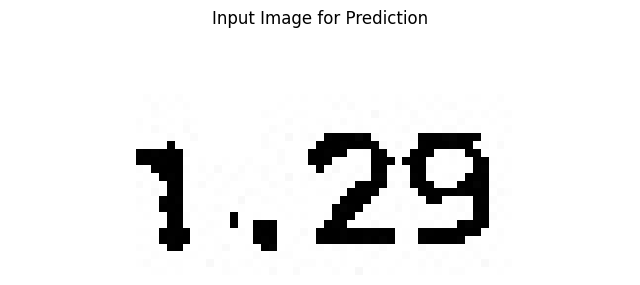

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['1', '.', '2', '9']
Decoded: ['1', '.', '2', '9']


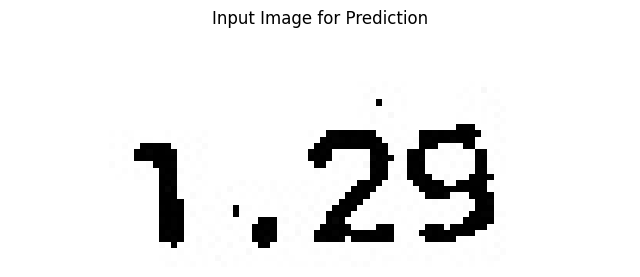

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['1', '.', '2', '9']
Decoded: ['1', '.', '2', '9']


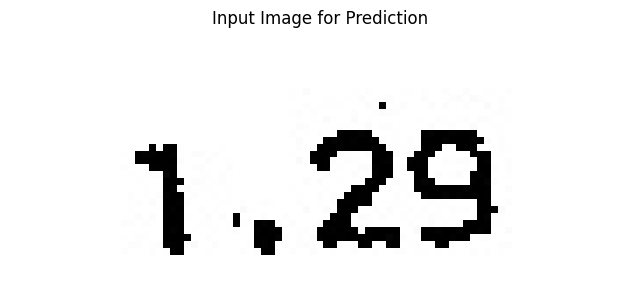

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Decoded: ['1', '.', '2', '9']
Decoded: ['1', '.', '2', '9']


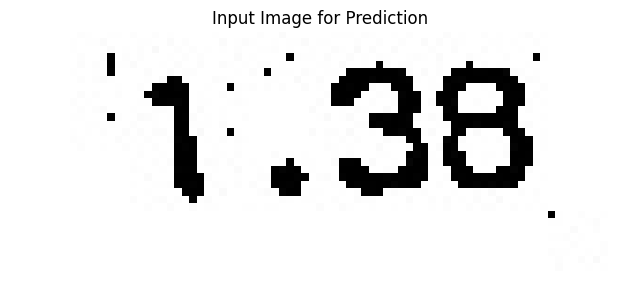

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '.', '3', '9']
Decoded: ['1', '.', '3', '9']


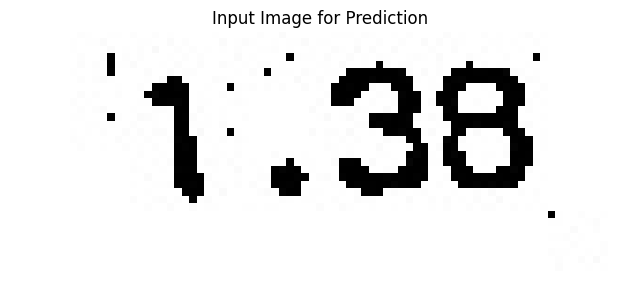

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '.', '3', '9']
Decoded: ['1', '.', '3', '9']


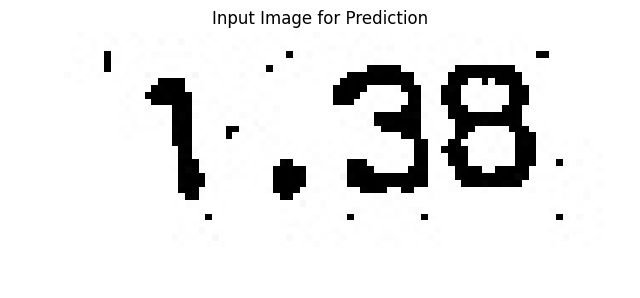

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.', '3', '8']
Decoded: ['1', '.', '3', '8']


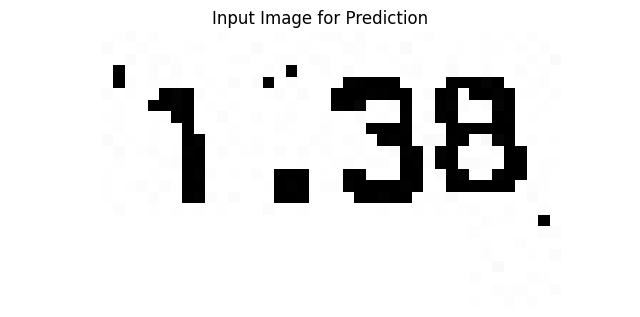

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Decoded: ['1', '.', '3', '9']
Decoded: ['1', '.', '3', '9']


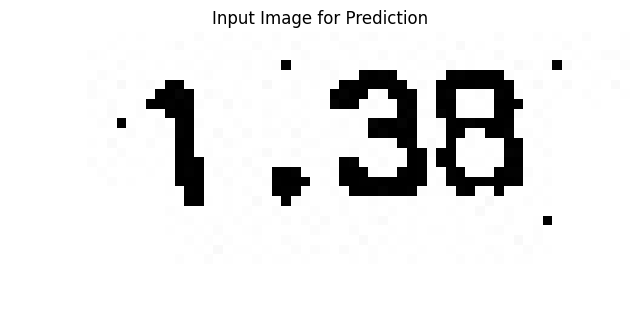

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Decoded: ['1', '.', '3', '9']
Decoded: ['1', '.', '3', '9']


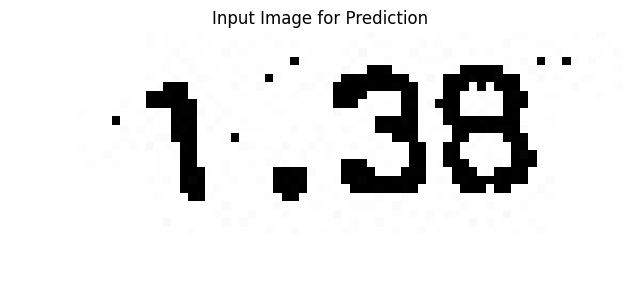

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '.', '3', '9']
Decoded: ['1', '.', '3', '9']


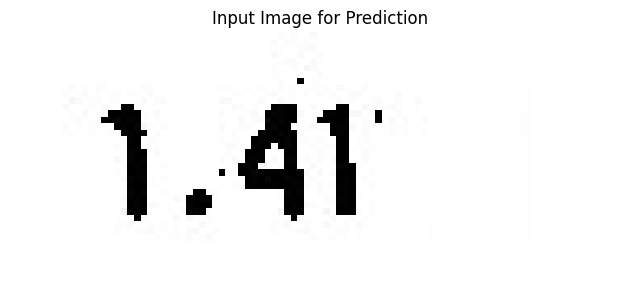

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '.', '4', '1']
Decoded: ['1', '.', '4', '1']


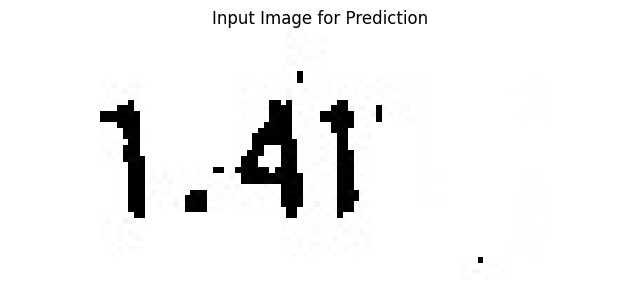

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '.', '4', '1']
Decoded: ['1', '.', '4', '1']


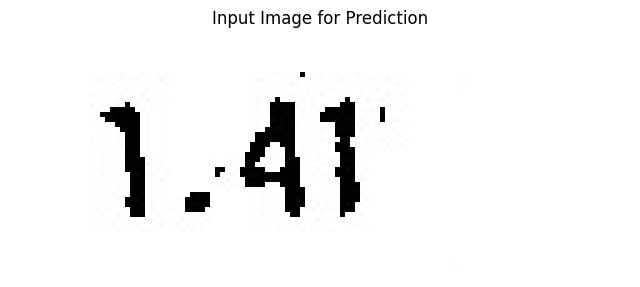

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.', '4', '1']
Decoded: ['1', '.', '4', '1']


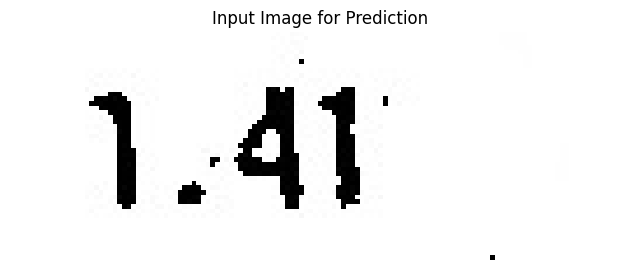

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '.', '4', '1']
Decoded: ['1', '.', '4', '1']


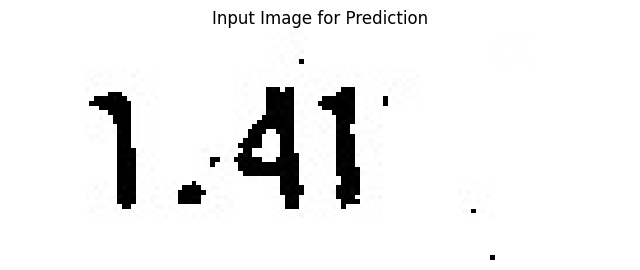

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '.', '4', '1']
Decoded: ['1', '.', '4', '1']


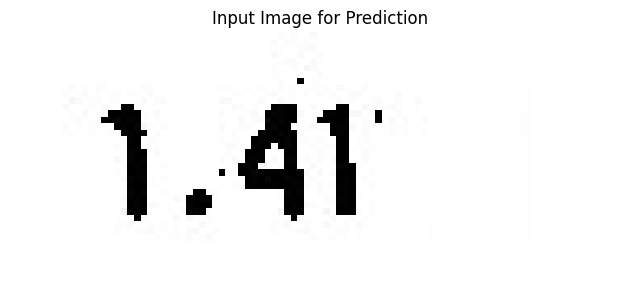

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Decoded: ['1', '.', '4', '1']
Decoded: ['1', '.', '4', '1']


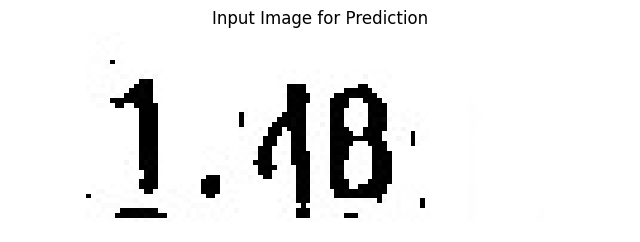

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.', '4', '8']
Decoded: ['1', '.', '4', '8']


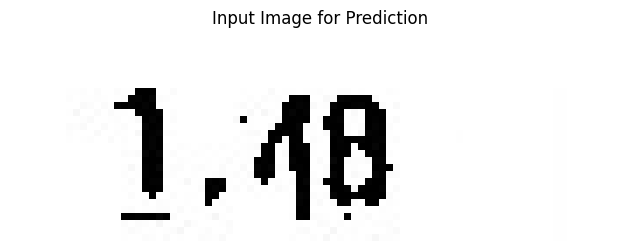

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '.', '4', '8']
Decoded: ['1', '.', '4', '8']


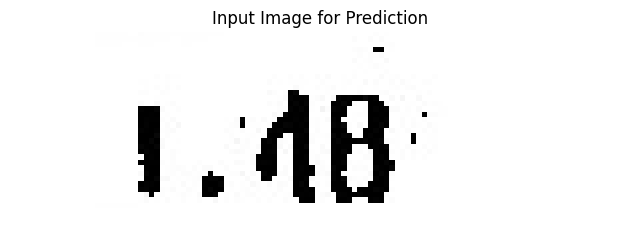

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '.', '4', '8']
Decoded: ['1', '.', '4', '8']


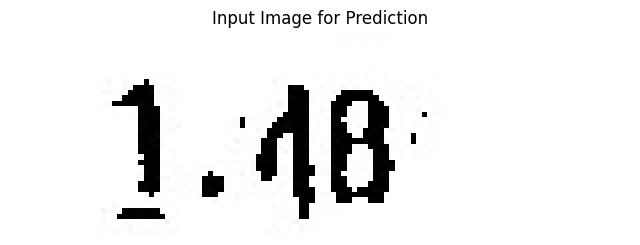

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '.', '4', '8']
Decoded: ['1', '.', '4', '8']


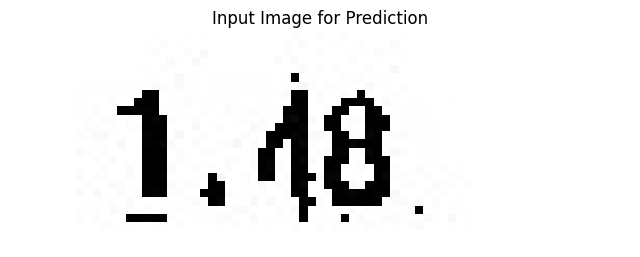

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Decoded: ['1', '.', '4', '8']
Decoded: ['1', '.', '4', '8']


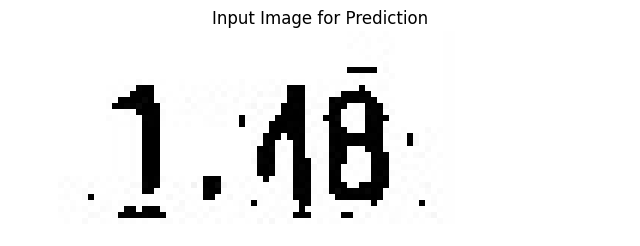

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '.', '4', '8']
Decoded: ['1', '.', '4', '8']


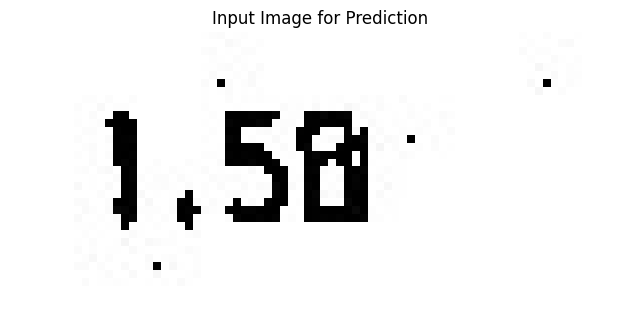

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '.', '5', '8']
Decoded: ['1', '.', '5', '8']


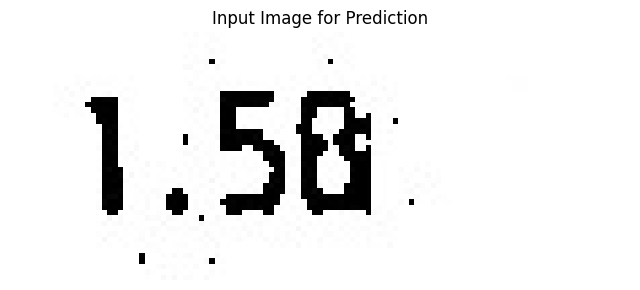

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.', '5', '8']
Decoded: ['1', '.', '5', '8']


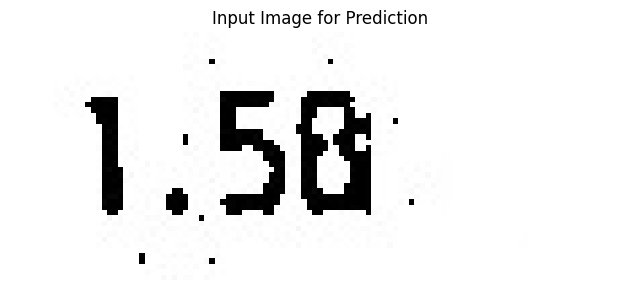

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['1', '.', '5', '8']
Decoded: ['1', '.', '5', '8']


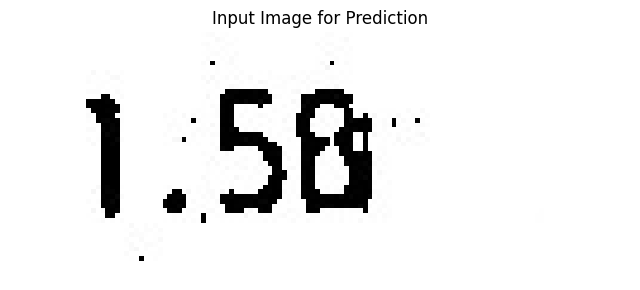

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '.', '5', '8']
Decoded: ['1', '.', '5', '8']


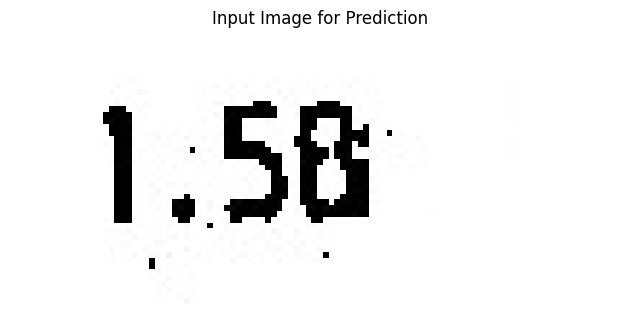

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '.', '5', '8']
Decoded: ['1', '.', '5', '8']


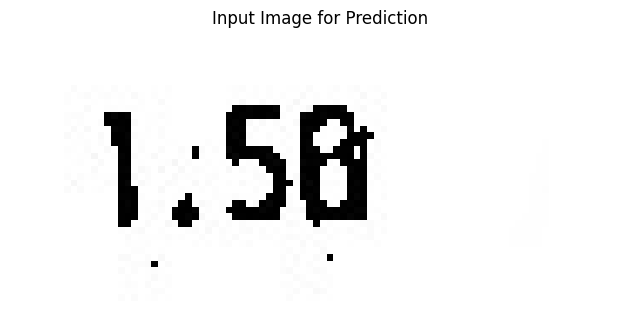

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['1', '.', '5', '8']
Decoded: ['1', '.', '5', '8']


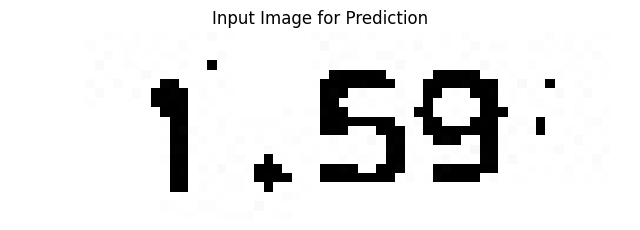

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '.', '5', '9']
Decoded: ['1', '.', '5', '9']


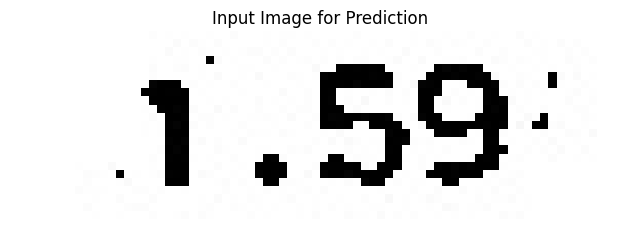

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '.', '5', '9']
Decoded: ['1', '.', '5', '9']


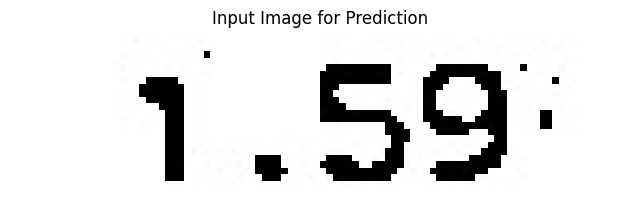

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.', '5', '9']
Decoded: ['1', '.', '5', '9']


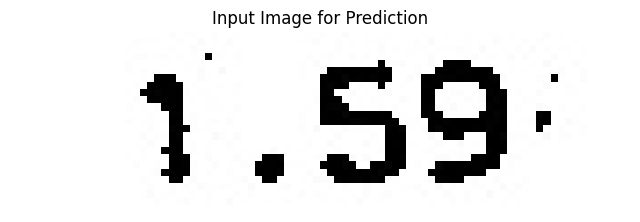

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '.', '5', '9']
Decoded: ['1', '.', '5', '9']


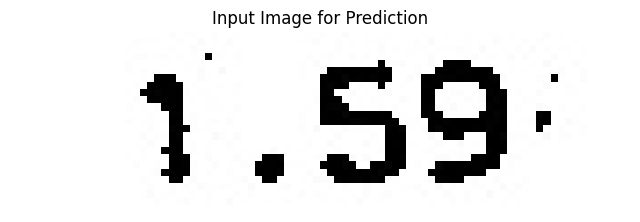

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '.', '5', '9']
Decoded: ['1', '.', '5', '9']


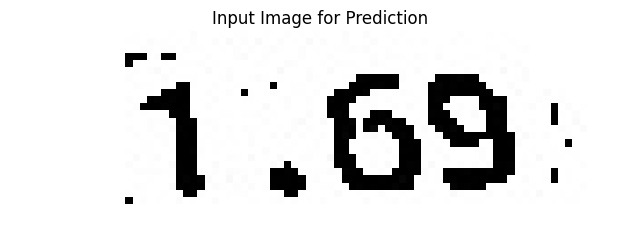

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Decoded: ['1', '.', '5', '9']
Decoded: ['1', '.', '5', '9']


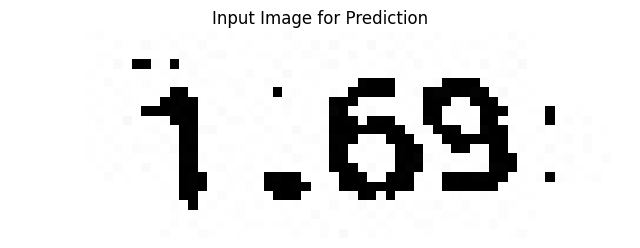

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '.', '6', '9']
Decoded: ['1', '.', '6', '9']


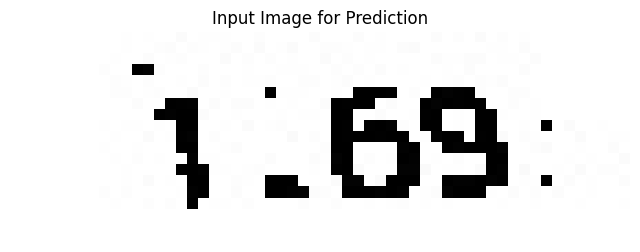

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '.', '6', '9']
Decoded: ['1', '.', '6', '9']


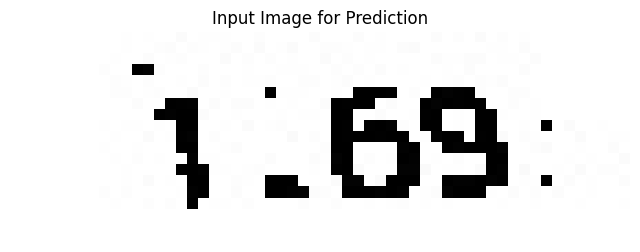

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '.', '6', '9']
Decoded: ['1', '.', '6', '9']


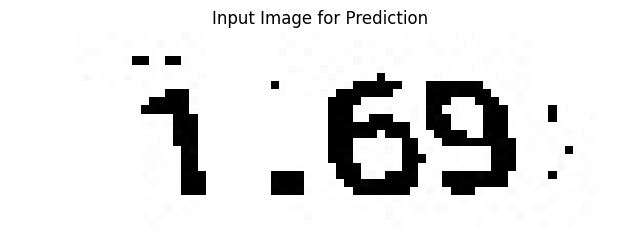

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '.', '5', '9']
Decoded: ['1', '.', '5', '9']


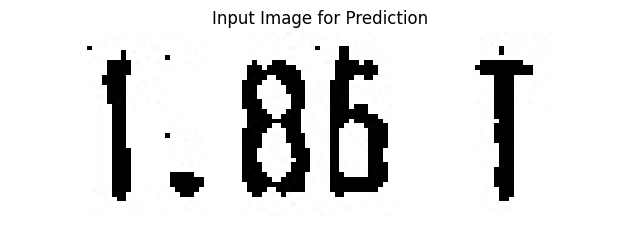

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


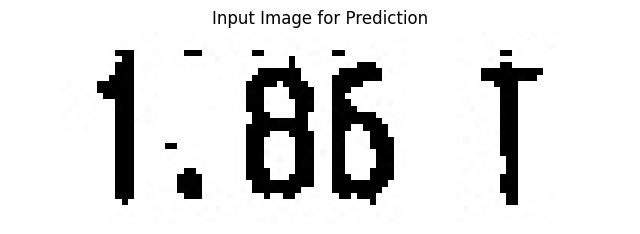

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


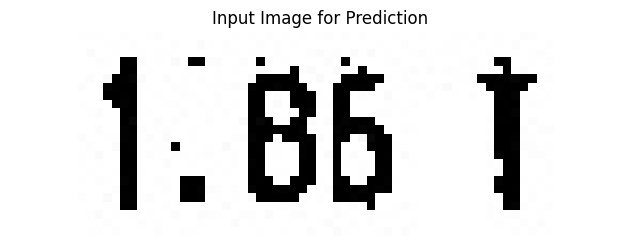

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


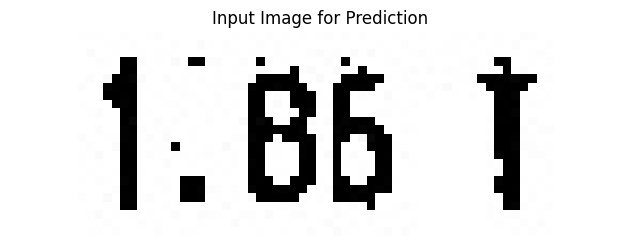

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


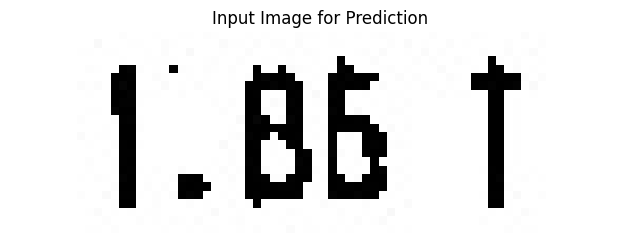

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


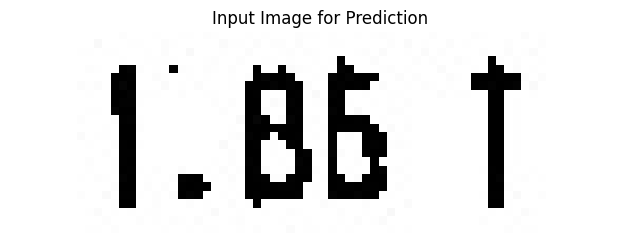

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


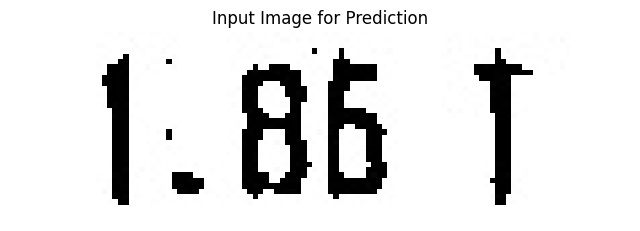

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


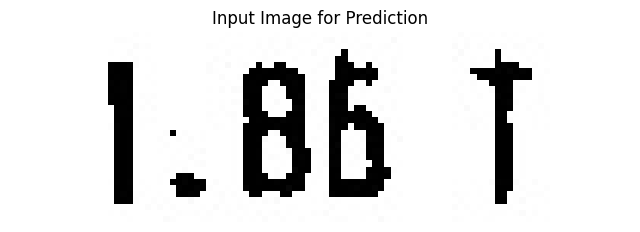

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


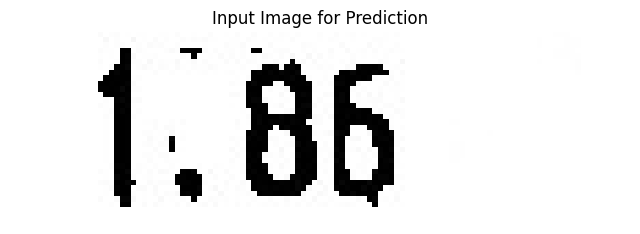

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


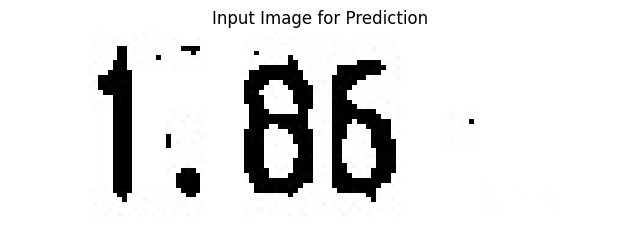

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


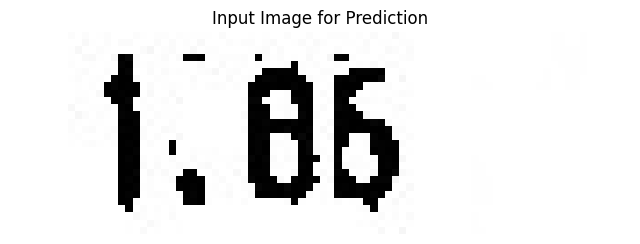

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


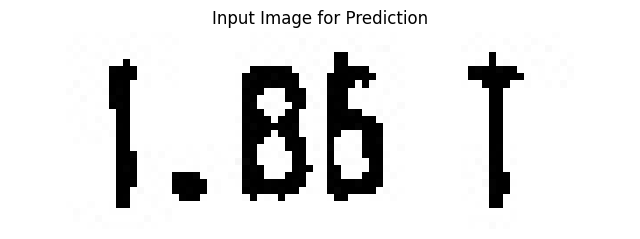

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Decoded: ['1', '.', '8', '6']
Decoded: ['1', '.', '8', '6']


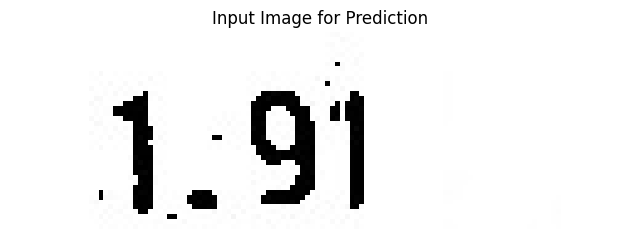

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Decoded: ['1', '.', '9', '1']
Decoded: ['1', '.', '9', '1']


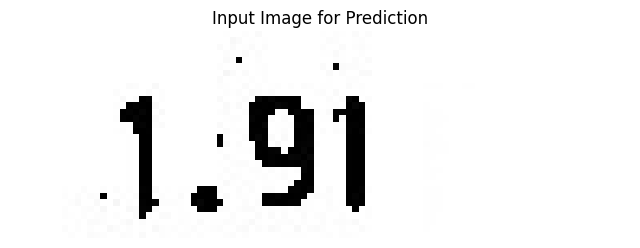

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['1', '.', '9', '1']
Decoded: ['1', '.', '9', '1']


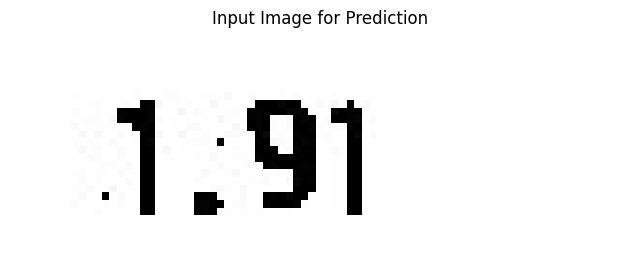

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Decoded: ['1', '.', '9', '1']
Decoded: ['1', '.', '9', '1']


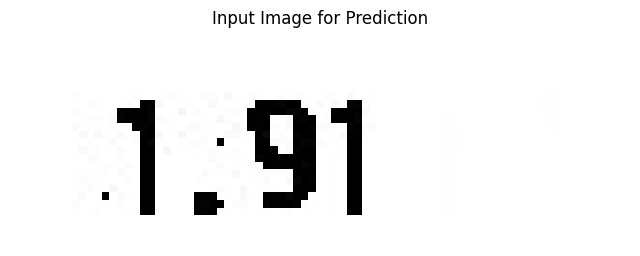

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Decoded: ['1', '.', '9', '1']
Decoded: ['1', '.', '9', '1']


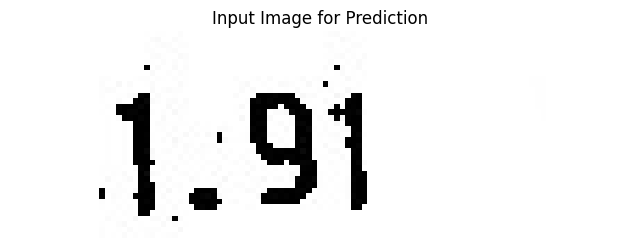

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Decoded: ['1', '.', '9', '1']
Decoded: ['1', '.', '9', '1']


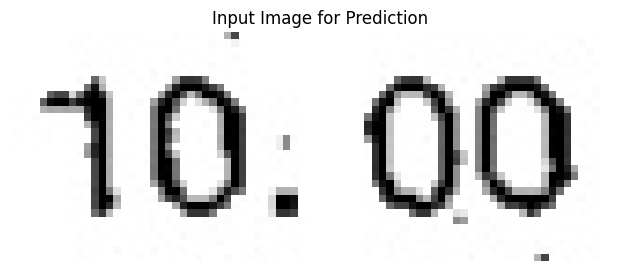

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


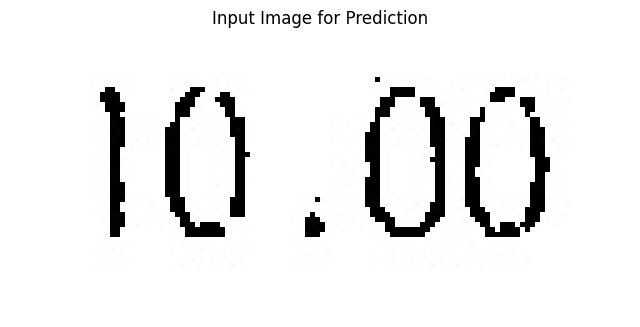

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


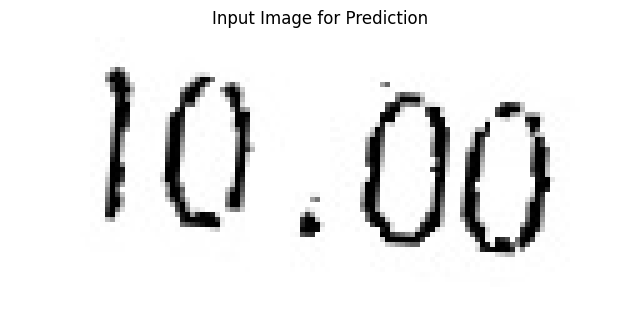

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


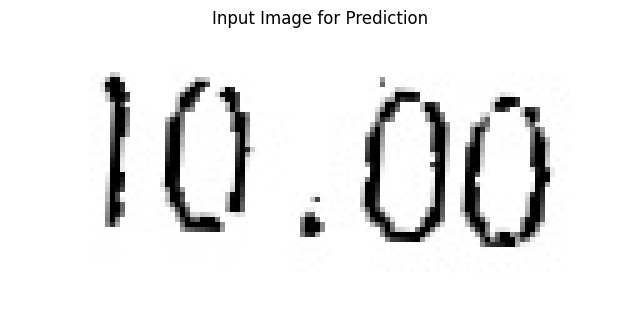

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


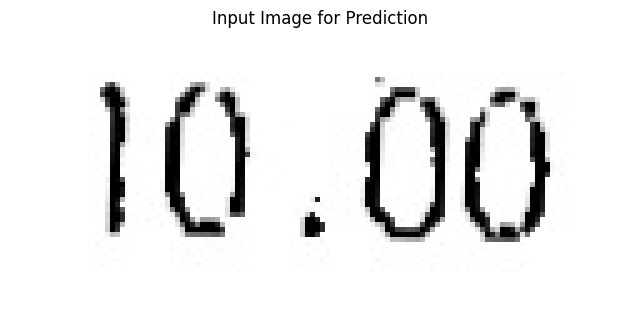

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


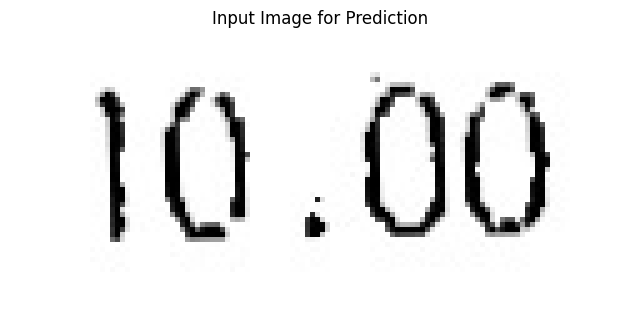

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


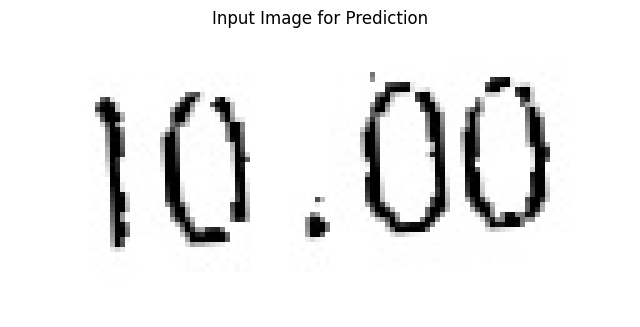

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


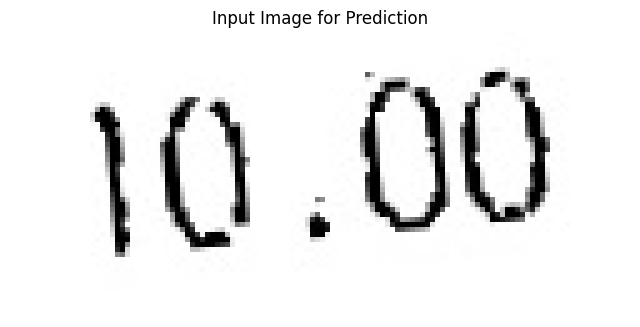

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


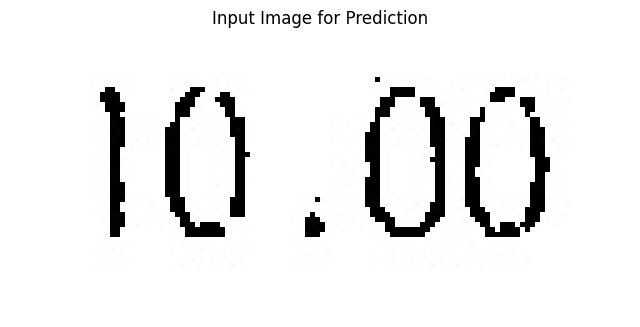

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


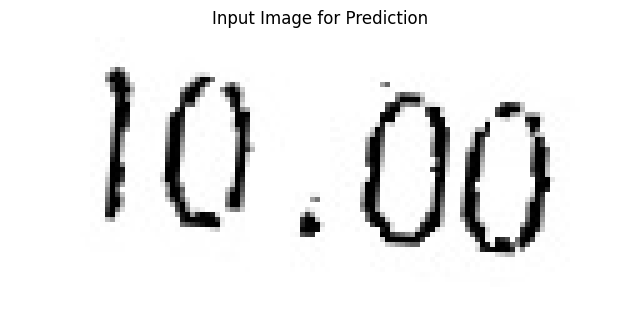

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


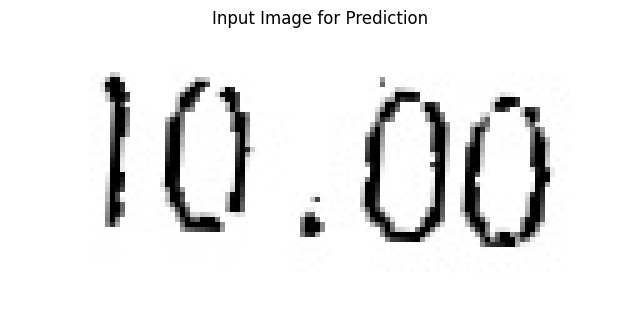

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


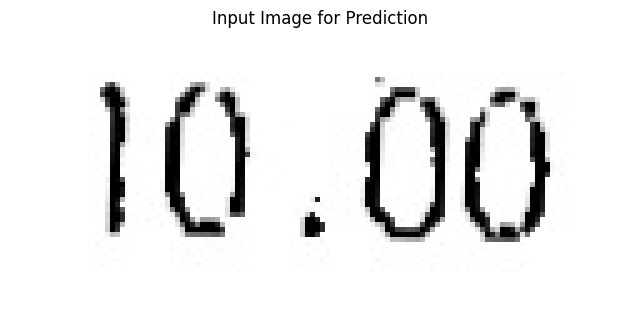

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


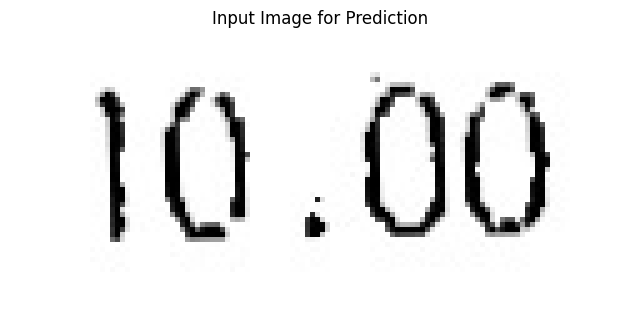

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


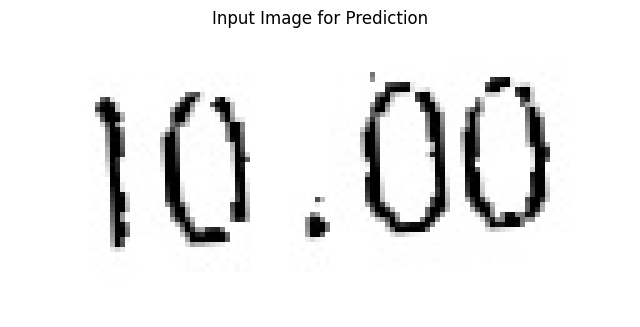

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


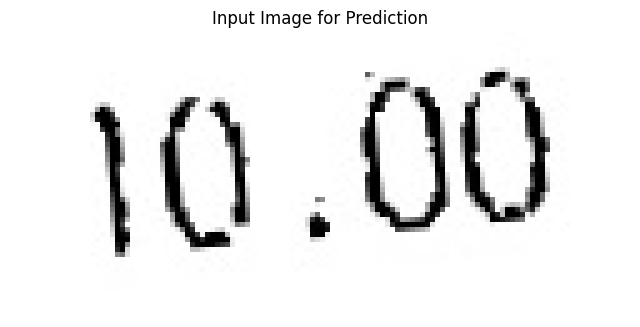

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


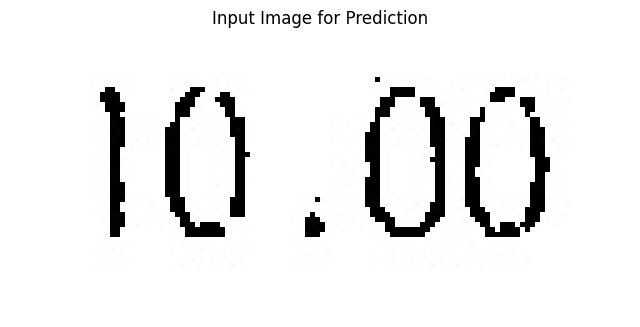

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


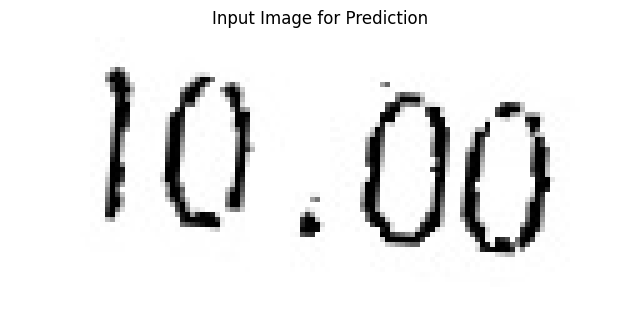

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


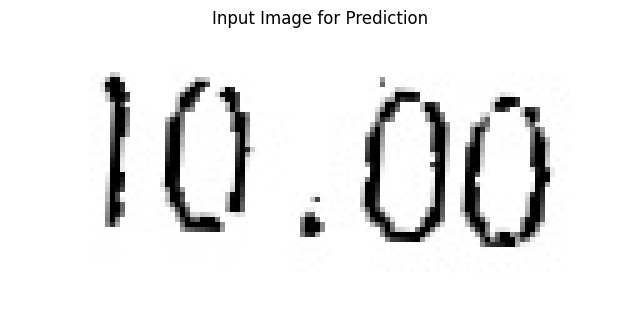

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


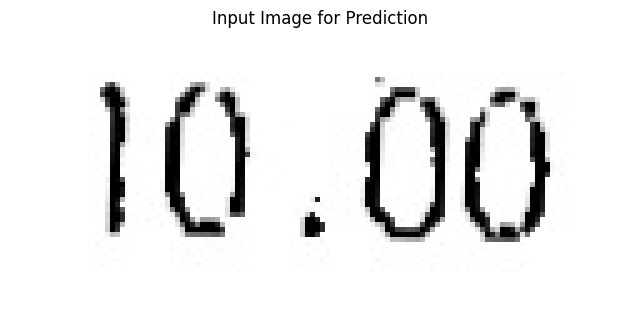

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


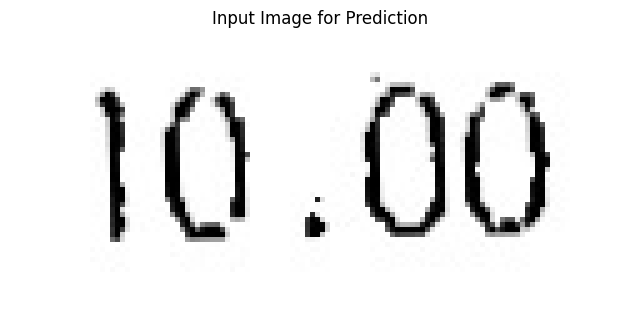

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


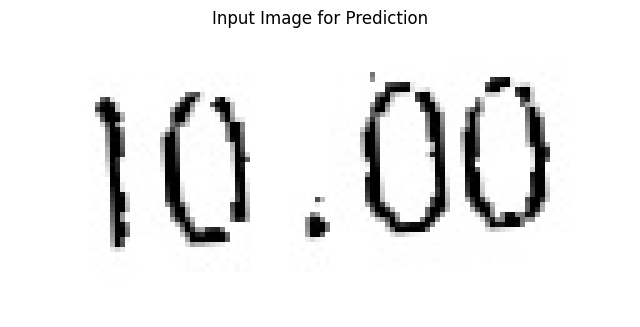

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


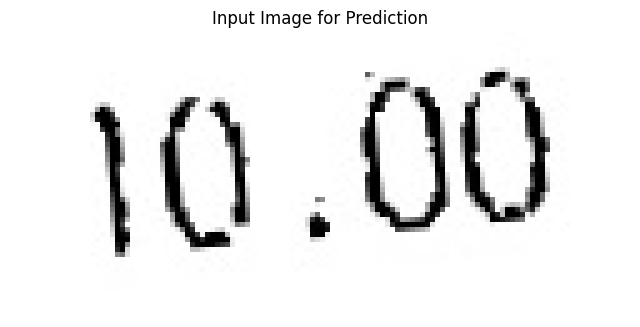

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


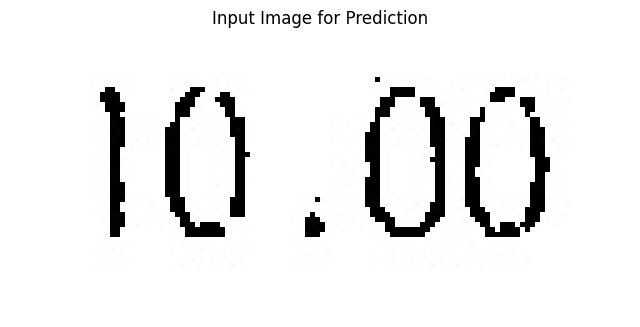

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


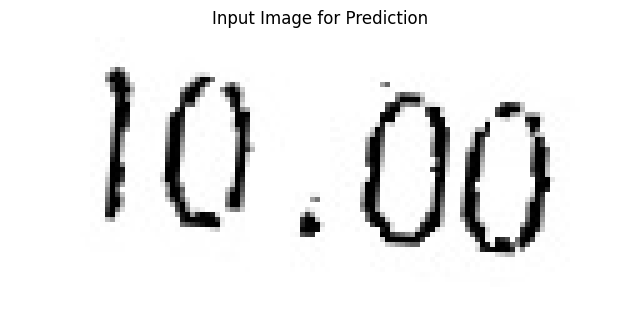

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


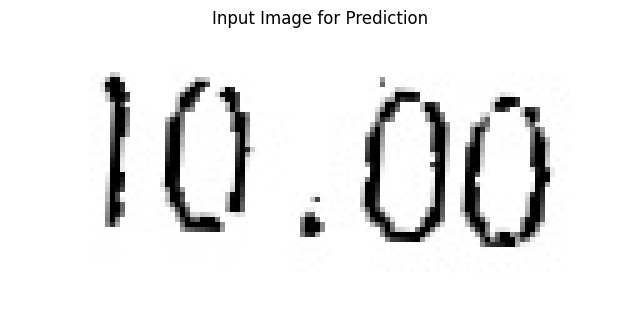

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


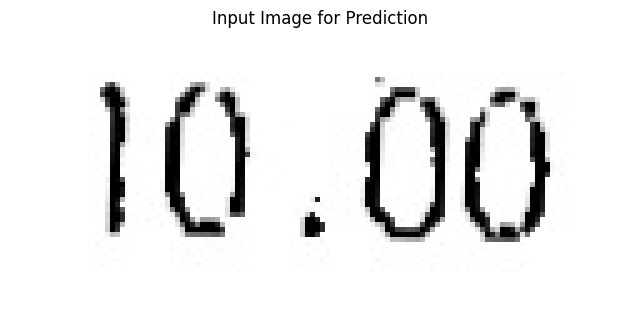

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


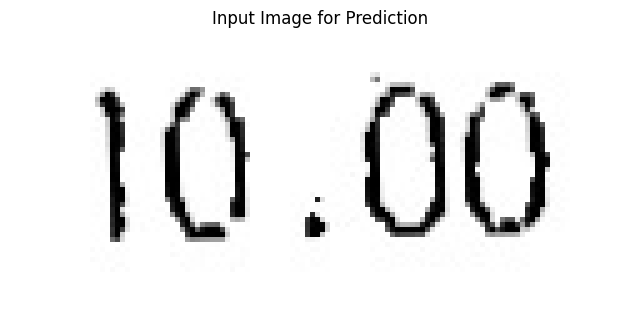

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


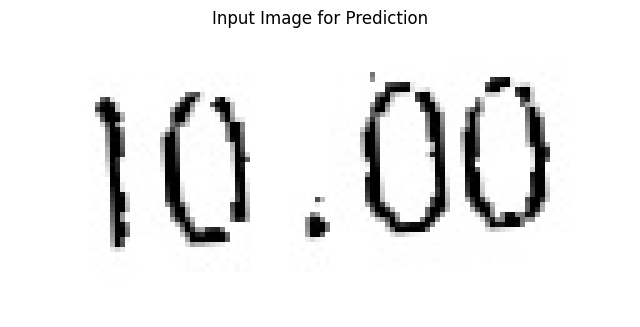

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


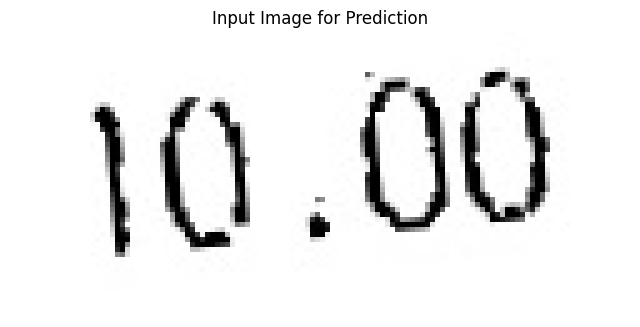

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


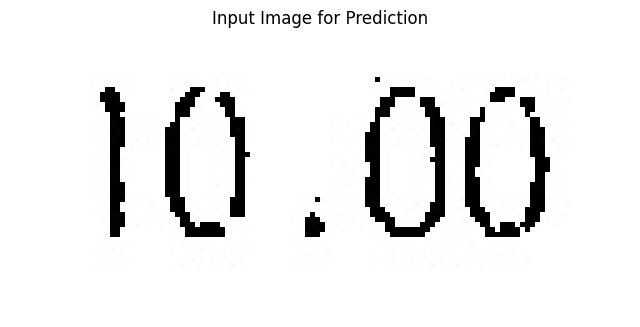

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


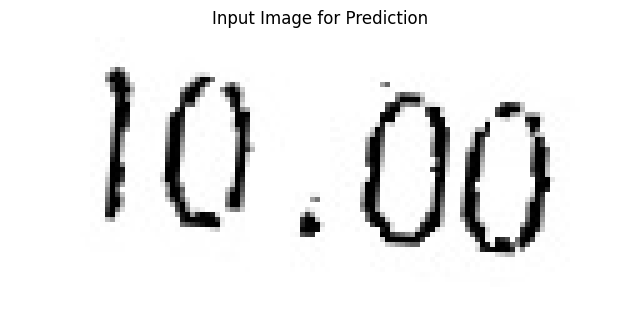

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


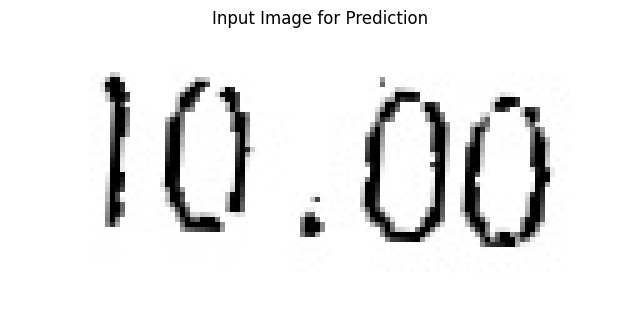

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


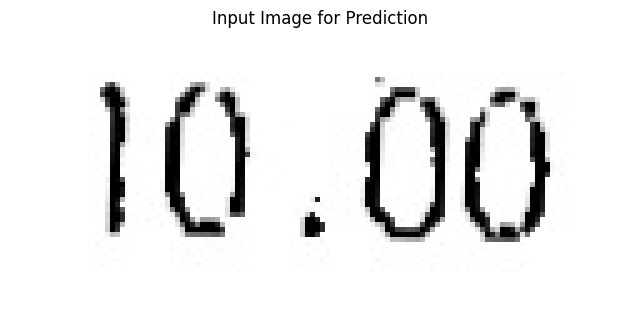

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


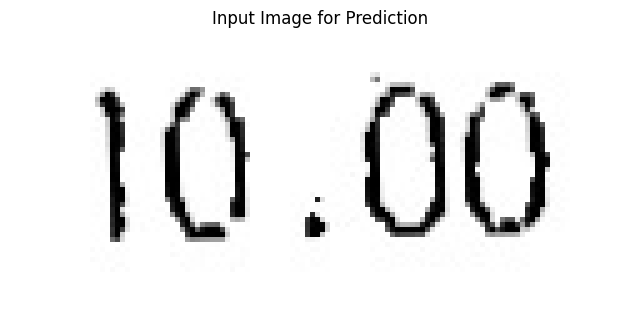

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


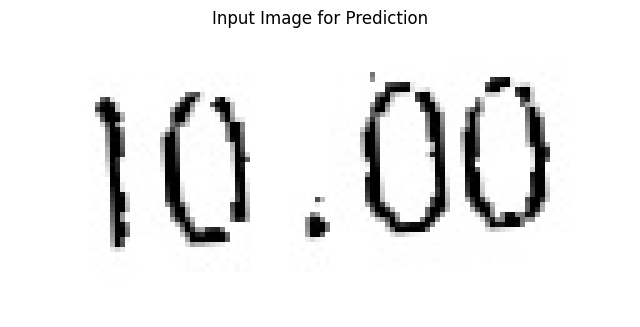

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


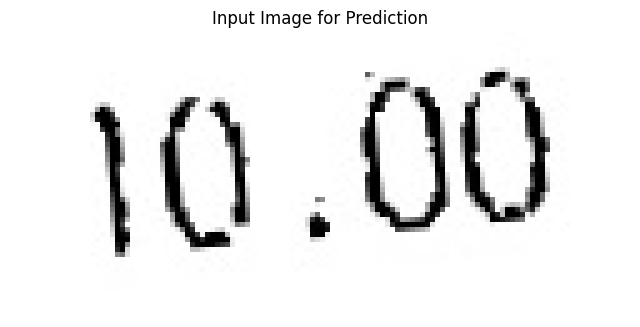

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


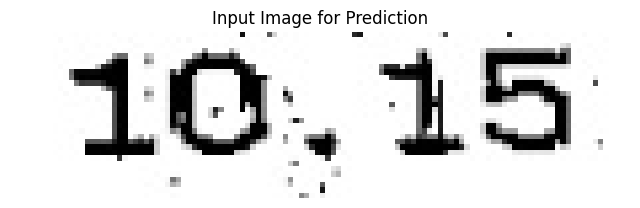

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Decoded: ['1', '0', '.', '1', '5']
Decoded: ['1', '0', '.', '1', '5']


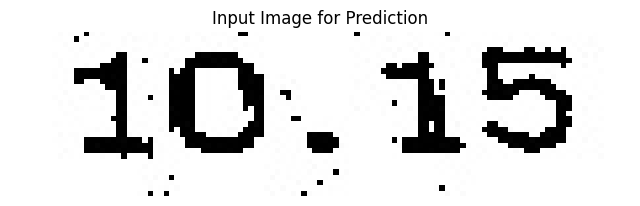

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '0', '.', '1', '5']
Decoded: ['1', '0', '.', '1', '5']


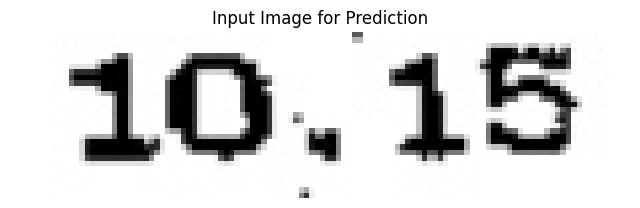

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '0', '.', '1', '5']
Decoded: ['1', '0', '.', '1', '5']


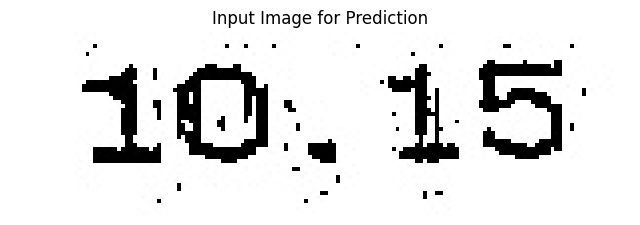

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '0', '.', '1', '5']
Decoded: ['1', '0', '.', '1', '5']


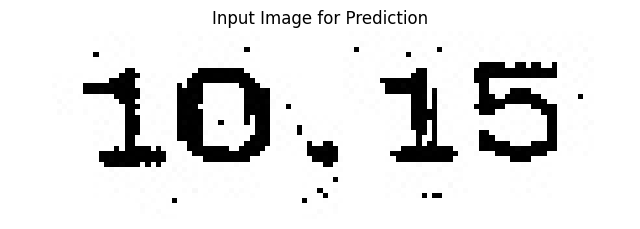

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '0', '.', '1', '5']
Decoded: ['1', '0', '.', '1', '5']


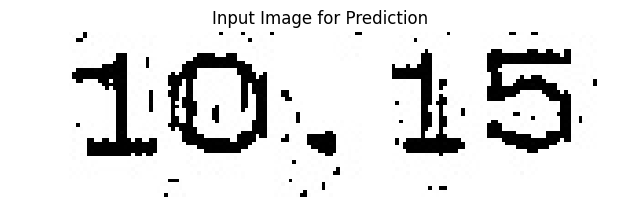

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '0', '.', '1', '5']
Decoded: ['1', '0', '.', '1', '5']


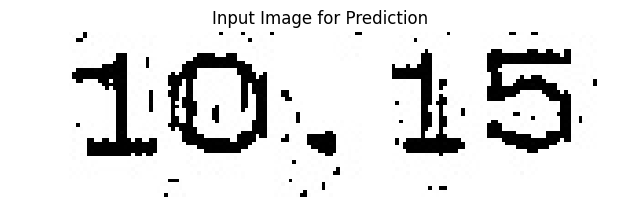

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '0', '.', '1', '5']
Decoded: ['1', '0', '.', '1', '5']


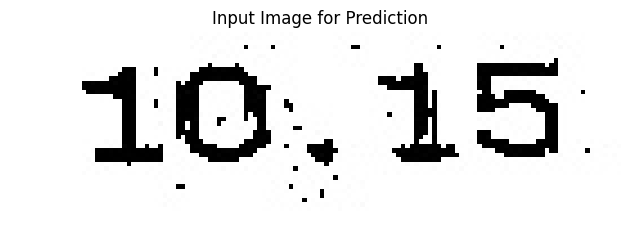

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Decoded: ['1', '0', '.', '1', '5']
Decoded: ['1', '0', '.', '1', '5']


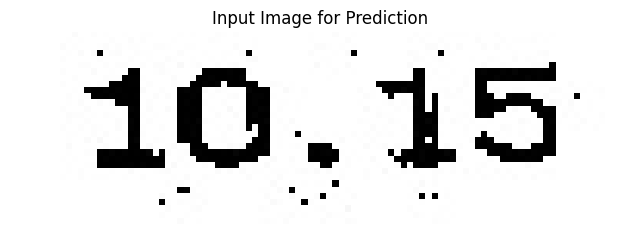

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Decoded: ['1', '0', '.', '1', '5']
Decoded: ['1', '0', '.', '1', '5']


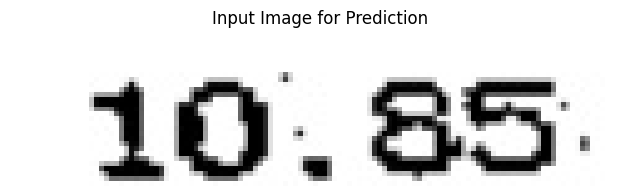

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Decoded: ['1', '0', '.', '8', '5']
Decoded: ['1', '0', '.', '8', '5']


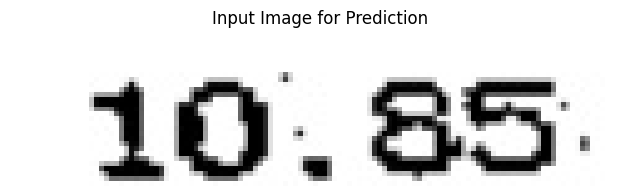

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Decoded: ['1', '0', '.', '8', '5']
Decoded: ['1', '0', '.', '8', '5']


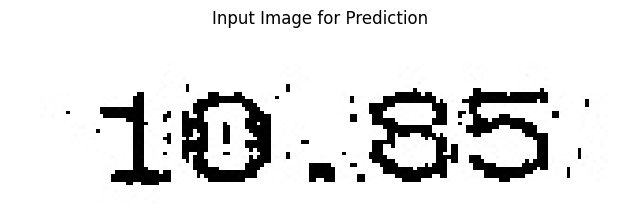

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Decoded: ['1', '0', '.', '8', '5']
Decoded: ['1', '0', '.', '8', '5']


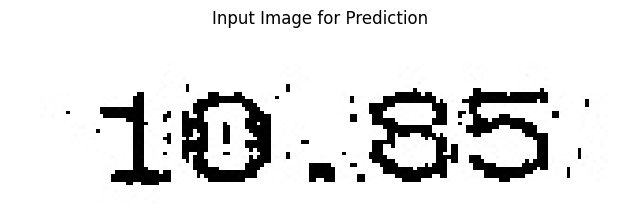

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Decoded: ['1', '0', '.', '8', '5']
Decoded: ['1', '0', '.', '8', '5']


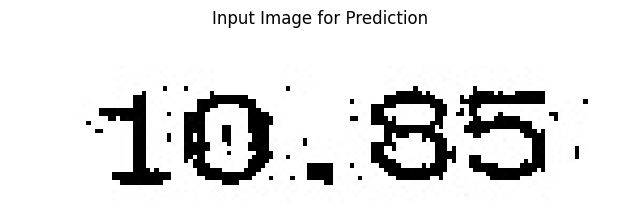

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '0', '.', '8', '5']
Decoded: ['1', '0', '.', '8', '5']


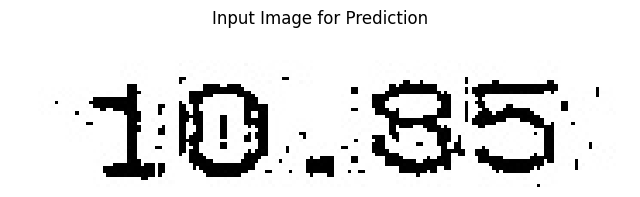

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Decoded: ['1', '0', '.', '8', '5']
Decoded: ['1', '0', '.', '8', '5']


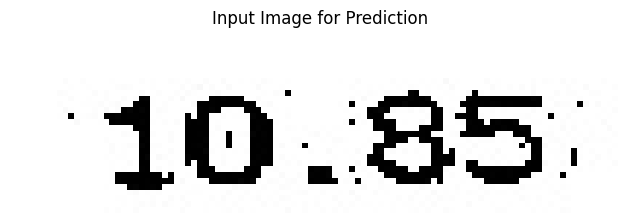

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Decoded: ['1', '0', '.', '8', '5']
Decoded: ['1', '0', '.', '8', '5']


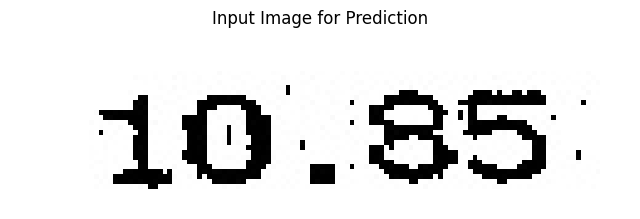

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['1', '0', '.', '8', '5']
Decoded: ['1', '0', '.', '8', '5']


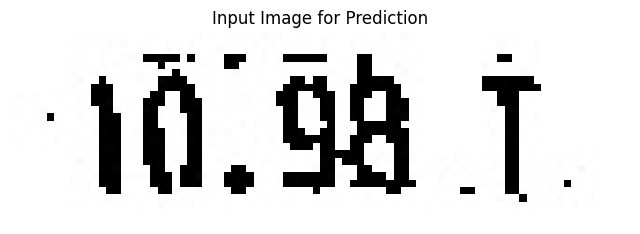

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Decoded: ['1', '0', '.', '9', '8']
Decoded: ['1', '0', '.', '9', '8']


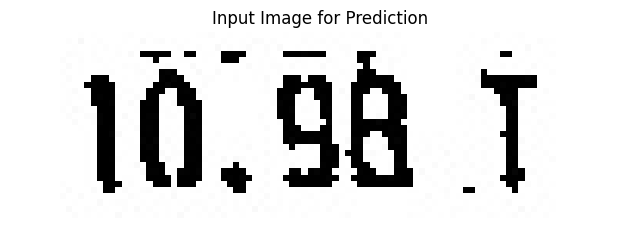

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Decoded: ['1', '0', '.', '9', '8']
Decoded: ['1', '0', '.', '9', '8']


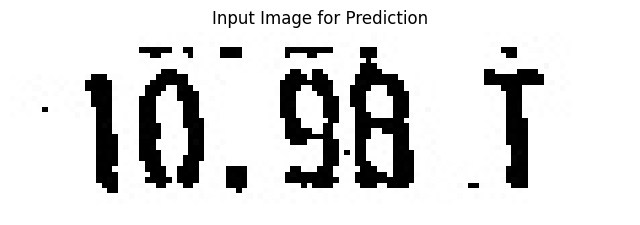

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Decoded: ['1', '0', '.', '9', '8']
Decoded: ['1', '0', '.', '9', '8']


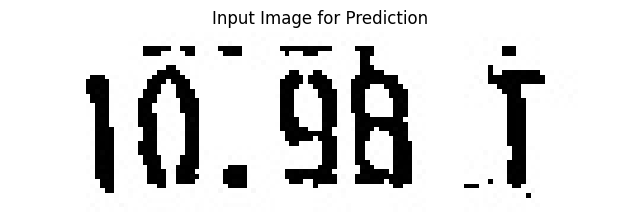

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Decoded: ['1', '0', '.', '9', '8']
Decoded: ['1', '0', '.', '9', '8']


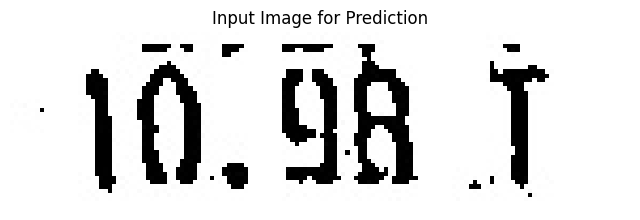

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '0', '.', '9', '8']
Decoded: ['1', '0', '.', '9', '8']


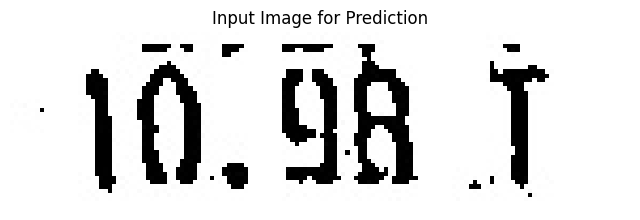

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '0', '.', '9', '8']
Decoded: ['1', '0', '.', '9', '8']


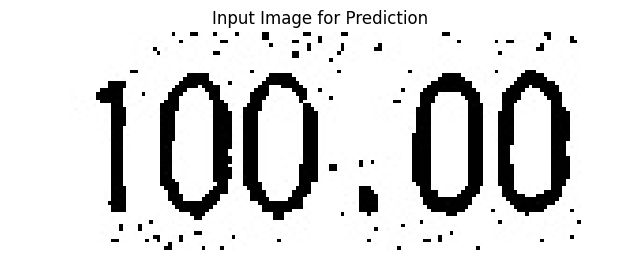

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '0', '.', '0', '0']


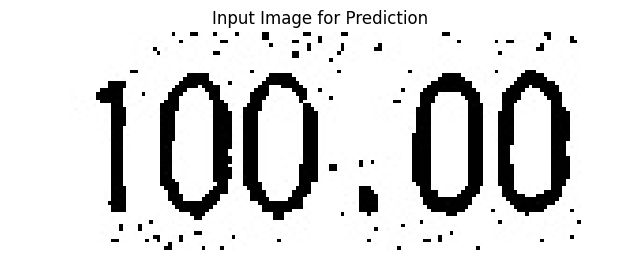

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '0', '.', '0', '0']


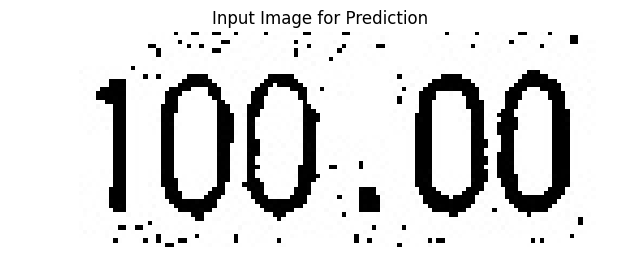

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '0', '.', '0', '0']


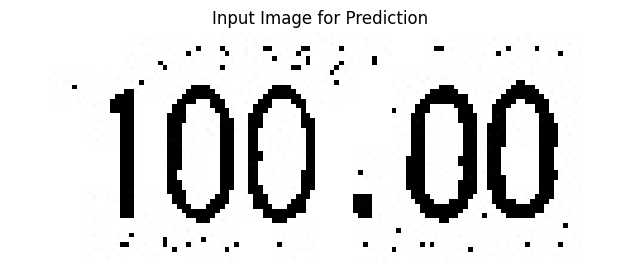

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '0', '.', '0', '0']


In [5]:
import matplotlib.pyplot as plt
import cv2

for i in range(400):
  # Read the first image
  img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)

  # Display
  plt.figure(figsize=(8,4))
  plt.imshow(img, cmap='gray')
  plt.title("Input Image for Prediction")
  plt.axis('off')
  plt.show()


  # -------------------
  # Inference example
  # -------------------
  # Preprocess the image for inference
  # img = cv2.imread(image_paths[10], cv2.IMREAD_GRAYSCALE)

  # Apply the same preprocessing as in the data generator
  # Preprocess
  img_height = 31

  # Add margin by creating a slightly larger canvas
  # h, w = img.shape[:2]
  # canvas = np.ones((h + 2*margin, w + 2*margin), dtype=np.uint8) * 255
  # canvas[margin:margin+h, margin:margin+w] = img
  # img = canvas

  h, w = img.shape[:2]
  scale = img_height / h
  new_w = int(w * scale)
  resized = cv2.resize(img, (new_w, img_height))

  img = resized.astype(np.float32) / 255.0
  img = np.expand_dims(img, axis=(0, -1)) # Add batch and channel dimensions


  preds = base_model.predict(img)
  decoded, _ = tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=False, beam_width=8)

  decoded_indices = decoded[0].numpy()[0]
  decoded_text = [idx_to_char[i] for i in decoded_indices if i > 0]  # skip 0 and negatives
  print("Decoded:", decoded_text)

  decoded, _ = tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)
  decoded_indices = decoded[0].numpy()[0]
  decoded_text = [idx_to_char[i] for i in decoded_indices if i > 0]  # skip 0 and negatives
  print("Decoded:", decoded_text)

In [6]:
base_model.save("crnn_model.keras")

In [7]:
base_model.save("crnn_model.h5")
